# Visualization notebook for:
- multi-class classification
- Multiple Binary classfiers

**NB:** Whenever there is a "Complete", one must fill it with the corresponding outputs after running the code on the cluster (to copy-paste from the terminal)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import evaluate
import regex as re
import io
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from datasets import load_metric

In [5]:
# plot train/val loss and accuracy across epochs
def plot_train_val_loss_acc(train_losses, val_losses, avg_train_acc_per_epoch, avg_val_acc_per_epoch, epochs, cm, class_labels, plot_cm):
    fig, axs = plt.subplots(1,3, figsize = (14,5))
    axs[0].plot(range(epochs), train_losses, label='Training Loss')
    axs[0].plot(range(epochs), val_losses, label='Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training and Validation Loss over Epochs')
    axs[0].set_xticks(np.arange(epochs))
    axs[0].legend()

    axs[1].plot(range(epochs), avg_train_acc_per_epoch, label='Training Accuracy')
    axs[1].plot(range(epochs), avg_val_acc_per_epoch, label='Validation Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Training and Validation Accuracy over Epochs')
    axs[1].set_xticks(np.arange(epochs))
    axs[1].legend()
    
    if plot_cm:
    #cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
        # Create a heatmap for the confusion matrix
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, ax = axs[2])
        axs[2].set_xlabel("Predicted")
        axs[2].set_ylabel("True")
        axs[2].set_title("Confusion Matrix")
    
    plt.tight_layout()
    plt.show()

---

# Multiclass CLF with CV

In [6]:

def plot_multiclass_CV(train_loss_list, val_loss_list, train_acc_list, val_acc_list, n_splits, epochs):
    
    train_loss_array = np.array(train_loss_list).reshape(n_splits,epochs)
    mean_train_loss = np.mean(train_loss_array, axis=0)
    ci_train_loss = np.percentile(train_loss_array, [2.5, 97.5], axis=0)

    val_loss_array = np.array(val_loss_list).reshape(n_splits,epochs)
    mean_val_loss = np.mean(val_loss_array, axis=0)
    ci_val_loss = np.percentile(val_loss_array, [2.5, 97.5], axis=0)
    
    # Create a DataFrame for Seaborn
    df_train_loss = pd.DataFrame({
        'Epochs': np.arange(epochs),
        'Mean_Train_Loss': mean_train_loss,
        'Lower_CI': ci_train_loss[0],
        'Upper_CI': ci_train_loss[1]})

    df_val_loss = pd.DataFrame({
        'Epochs': np.arange(epochs),
        'Mean_Val_Loss': mean_val_loss,
        'Lower_CI': ci_val_loss[0],
        'Upper_CI': ci_val_loss[1]})

    # Code for Accuracy Plot (Second Subplot)
    train_acc_array = np.array(train_acc_list).reshape(n_splits, epochs)
    val_acc_array = np.array(val_acc_list).reshape(n_splits, epochs)
    ci_train_acc = np.percentile(train_acc_array, [2.5, 97.5], axis=0)

    mean_train_acc = np.mean(train_acc_array, axis=0)
    mean_val_acc = np.mean(val_acc_array, axis=0)
    ci_val_acc = np.percentile(val_acc_array, [2.5, 97.5], axis=0)

    df_train_acc = pd.DataFrame({
        'Epochs': np.arange(epochs), 
        'Mean_Train_Accuracy': mean_train_acc,
        'Lower_CI': ci_train_acc[0],
        'Upper_CI': ci_train_acc[1]})

    df_val_acc = pd.DataFrame({
        'Epochs': np.arange(epochs),
        'Mean_Val_Accuracy': mean_val_acc,
        'Lower_CI': ci_val_acc[0],
        'Upper_CI': ci_val_acc[1]})

    #df_train_loss.head()
    #df_val_loss.head()

    fig, axs = plt.subplots(1,2, figsize=(12,5))
    # Plot the mean accuracy line
    sns.pointplot(data=df_train_loss, x='Epochs', y='Mean_Train_Loss', color='blue', ax = axs[0])
    sns.pointplot(data=df_val_loss, x='Epochs', y='Mean_Val_Loss', color='orange', ax = axs[0])

    sns.pointplot(data=df_train_acc, x='Epochs', y='Mean_Train_Accuracy', color='blue', ax = axs[1])
    sns.pointplot(data=df_val_acc, x='Epochs', y='Mean_Val_Accuracy', color='orange', ax = axs[1])

    # Fill between the confidence interval
    axs[0].fill_between(df_train_loss['Epochs'], df_train_loss['Lower_CI'], df_train_loss['Upper_CI'], color='blue', alpha=0.3, label = 'train')
    axs[0].fill_between(df_val_loss['Epochs'], df_val_loss['Lower_CI'], df_val_loss['Upper_CI'], color='orange', alpha=0.3, label = 'val')
    axs[0].legend()
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('CV Loss with 95% CI')

    axs[1].fill_between(df_train_acc['Epochs'], df_train_acc['Lower_CI'], df_train_acc['Upper_CI'], color='blue', alpha=0.3, label = 'train')
    axs[1].fill_between(df_val_acc['Epochs'], df_val_acc['Lower_CI'], df_val_acc['Upper_CI'], color='orange', alpha=0.3, label = 'val')

    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('CV Accuracy with 95% CI')

    plt.legend()
    plt.show()

def test_multiclass_CV(true_labels, predicted_labels, pred_confidence, class_labels):
    # Generate classification report
    report = classification_report(true_labels, predicted_labels, zero_division = 1, target_names=class_labels)
    print(report)
    # Create confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    # Subplot 1: Confusion Matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, ax=axs[0])
    axs[0].set_xlabel("Predicted")
    axs[0].set_ylabel("True")
    axs[0].set_title("Confusion Matrix")
    # Subplot 2: Confidence Scores Histogram
    correct_confidence = [pred_confidence[i] for i in range(len(predicted_labels)) if predicted_labels[i] == true_labels[i]]
    incorrect_confidence = [pred_confidence[i] for i in range(len(predicted_labels)) if predicted_labels[i] != true_labels[i]]
    #correct_confidence = [pred_confidence[i] for i in range(len(pred_confidence)) if predicted_labels[i] == true_labels[i] and pred_confidence[i] < 10]
    #incorrect_confidence = [pred_confidence[i] for i in range(len(pred_confidence)) if predicted_labels[i] != true_labels[i] and pred_confidence[i] < 10]
    
    axs[1].hist(correct_confidence, bins=50, color='green', alpha=0.7, label='Correct Predictions')
    axs[1].hist(incorrect_confidence, bins=50, color='red', alpha=0.7, label='Incorrect Predictions')
    axs[1].legend()
    axs[1].set_xlabel('Confidence score')
    axs[1].set_ylabel('Number of predictions')
    axs[1].set_title('Confidence score of predictions')
    plt.tight_layout()
    plt.show()


## Evaluate multiclass clf

In [11]:
predicted_labels = ['Feeling' 'Other' 'Other' 'Experience' 'Difficulty' 'Feeling' 'Other'
 'Other' 'Other' 'Experience' 'Feeling' 'Other' 'Experience' 'Other'
 'Feeling' 'Experience' 'Experience' 'Experience' 'Other' 'Other'
 'Experience' 'Experience' 'Experience' 'Difficulty' 'Other' 'Belief'
 'Other' 'Feeling' 'Experience' 'Feeling' 'Feeling' 'Other' 'Belief'
 'Other' 'Difficulty' 'Other' 'Feeling' 'Other' 'Experience' 'Feeling'
 'Feeling' 'Other' 'Difficulty' 'Other' 'Experience' 'Intention' 'Other'
 'Other' 'Other' 'Experience' 'Other' 'Experience' 'Other' 'Intention'
 'Feeling' 'Other' 'Experience' 'Feeling' 'Other' 'Other' 'Other'
 'Experience' 'Experience' 'Other' 'Experience' 'Difficulty' 'Other'
 'Experience' 'Feeling' 'Experience' 'Feeling' 'Other' 'Experience'
 'Other' 'Other' 'Experience' 'Other' 'Feeling' 'Feeling' 'Difficulty'
 'Feeling' 'Difficulty' 'Experience' 'Other' 'Other' 'Experience'
 'Experience' 'Other' 'Intention' 'Other' 'Experience' 'Other' 'Other'
 'Other' 'Belief' 'Difficulty' 'Other' 'Experience' 'Other' 'Feeling'
 'Feeling' 'Experience' 'Other' 'Experience' 'Experience' 'Experience'
 'Other' 'Experience' 'Feeling' 'Experience' 'Belief' 'Experience'
 'Feeling' 'Feeling' 'Difficulty' 'Feeling' 'Feeling' 'Experience' 'Other'
 'Other' 'Experience' 'Belief' 'Feeling' 'Other' 'Experience' 'Feeling'
 'Other' 'Other' 'Belief' 'Experience' 'Other' 'Learning' 'Other' 'Other'
 'Experience' 'Feeling' 'Other' 'Other' 'Feeling' 'Belief' 'Feeling'
 'Feeling' 'Feeling' 'Other' 'Experience' 'Experience' 'Belief' 'Feeling'
 'Other' 'Other' 'Feeling' 'Intention' 'Learning' 'Experience' 'Belief'
 'Belief' 'Other' 'Experience' 'Other' 'Experience' 'Difficulty'
 'Experience' 'Experience' 'Difficulty' 'Feeling' 'Other' 'Feeling'
 'Difficulty' 'Feeling' 'Other' 'Feeling' 'Difficulty' 'Difficulty'
 'Feeling' 'Feeling' 'Other' 'Experience' 'Experience' 'Feeling' 'Other'
 'Belief' 'Feeling' 'Other' 'Experience' 'Belief' 'Other' 'Intention'
 'Feeling' 'Feeling' 'Difficulty' 'Other' 'Experience' 'Experience'
 'Experience' 'Experience' 'Difficulty' 'Other' 'Experience' 'Feeling'
 'Other' 'Experience' 'Learning' 'Other' 'Experience' 'Experience' 'Other'
 'Other' 'Experience' 'Other' 'Experience' 'Other' 'Experience'
 'Difficulty' 'Feeling' 'Feeling' 'Experience' 'Other' 'Feeling' 'Other'
 'Feeling' 'Experience' 'Difficulty' 'Other' 'Experience' 'Other' 'Other'
 'Experience' 'Feeling' 'Difficulty' 'Feeling' 'Difficulty' 'Feeling'
 'Other' 'Other' 'Feeling' 'Experience' 'Feeling' 'Experience' 'Other'
 'Experience' 'Other' 'Feeling' 'Experience' 'Difficulty' 'Difficulty'
 'Difficulty' 'Belief' 'Feeling' 'Other' 'Other' 'Other' 'Experience'
 'Experience' 'Other' 'Feeling' 'Other' 'Feeling' 'Feeling' 'Experience'
 'Other' 'Experience' 'Feeling' 'Experience' 'Other' 'Feeling'
 'Experience' 'Feeling' 'Feeling' 'Other' 'Intention' 'Experience'
 'Experience' 'Other' 'Difficulty' 'Feeling' 'Feeling' 'Difficulty'
 'Experience' 'Experience' 'Other' 'Other' 'Difficulty' 'Experience'
 'Other' 'Belief' 'Experience' 'Difficulty' 'Experience' 'Feeling' 'Other'
 'Belief' 'Other' 'Feeling' 'Experience' 'Experience' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Feeling' 'Learning' 'Feeling' 'Belief'
 'Difficulty' 'Feeling' 'Other' 'Other' 'Difficulty' 'Experience'
 'Intention' 'Other' 'Experience' 'Other' 'Experience' 'Experience'
 'Other' 'Experience' 'Experience' 'Experience' 'Experience' 'Difficulty'
 'Other' 'Belief' 'Feeling' 'Experience' 'Other' 'Other' 'Difficulty'
 'Experience' 'Other' 'Experience' 'Experience' 'Experience' 'Other'
 'Other' 'Feeling' 'Difficulty' 'Learning' 'Other' 'Belief' 'Feeling'
 'Other' 'Other' 'Experience' 'Experience' 'Belief' 'Feeling' 'Other'
 'Other' 'Experience' 'Feeling' 'Experience' 'Other' 'Feeling' 'Other'
 'Experience' 'Feeling' 'Other' 'Experience' 'Other' 'Difficulty'
 'Experience' 'Belief' 'Other' 'Feeling' 'Experience' 'Experience'
 'Experience' 'Difficulty' 'Experience' 'Difficulty' 'Experience'
 'Feeling' 'Feeling' 'Feeling' 'Difficulty' 'Other' 'Intention' 'Other'
 'Feeling' 'Difficulty' 'Experience' 'Other' 'Difficulty' 'Other'
 'Feeling' 'Belief' 'Experience' 'Other' 'Belief' 'Other' 'Other'
 'Experience' 'Feeling' 'Learning' 'Other' 'Difficulty' 'Other' 'Feeling'
 'Experience' 'Experience' 'Other' 'Other' 'Intention' 'Other' 'Other'
 'Experience' 'Experience' 'Other' 'Experience' 'Feeling' 'Difficulty'
 'Feeling' 'Other' 'Difficulty' 'Experience' 'Feeling' 'Difficulty'
 'Experience' 'Other' 'Belief' 'Belief' 'Other' 'Other' 'Experience'
 'Feeling' 'Experience' 'Difficulty' 'Other' 'Other' 'Feeling'
 'Difficulty' 'Other' 'Feeling' 'Experience' 'Difficulty' 'Other'
 'Feeling' 'Other' 'Experience' 'Other' 'Feeling' 'Other' 'Feeling'
 'Experience' 'Difficulty' 'Other' 'Feeling' 'Intention' 'Feeling' 'Other'
 'Experience' 'Difficulty' 'Experience' 'Experience' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Feeling' 'Feeling' 'Experience'
 'Experience' 'Other' 'Feeling' 'Feeling' 'Other' 'Experience' 'Belief'
 'Feeling' 'Belief' 'Feeling' 'Experience' 'Other' 'Experience' 'Feeling'
 'Experience' 'Difficulty' 'Experience' 'Other' 'Other' 'Other'
 'Experience' 'Feeling' 'Feeling' 'Feeling' 'Experience' 'Other' 'Feeling'
 'Feeling' 'Experience' 'Experience' 'Other' 'Other' 'Experience'
 'Experience' 'Other' 'Other' 'Feeling' 'Other' 'Experience' 'Experience'
 'Intention' 'Experience' 'Other' 'Difficulty' 'Intention' 'Learning'
 'Experience' 'Experience' 'Experience' 'Other' 'Feeling' 'Other'
 'Experience' 'Experience' 'Experience' 'Experience' 'Difficulty'
 'Experience' 'Feeling' 'Difficulty' 'Other' 'Difficulty' 'Difficulty'
 'Feeling' 'Experience' 'Belief' 'Experience' 'Experience' 'Feeling'
 'Experience' 'Other' 'Other' 'Belief' 'Other' 'Feeling' 'Other' 'Other'
 'Experience' 'Learning' 'Experience' 'Experience' 'Other' 'Feeling'
 'Experience' 'Feeling' 'Experience' 'Intention' 'Belief' 'Feeling'
 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Experience' 'Experience'
 'Other' 'Feeling' 'Feeling' 'Feeling' 'Experience' 'Other' 'Other'
 'Other' 'Experience' 'Feeling' 'Difficulty' 'Feeling' 'Experience'
 'Belief' 'Experience' 'Difficulty' 'Feeling' 'Feeling' 'Difficulty'
 'Difficulty' 'Difficulty' 'Experience' 'Experience' 'Other' 'Difficulty'
 'Feeling' 'Other' 'Experience' 'Other' 'Experience' 'Feeling'
 'Experience' 'Other' 'Feeling' 'Difficulty' 'Experience' 'Perspective'
 'Experience' 'Experience' 'Feeling' 'Feeling' 'Difficulty' 'Other'
 'Experience' 'Belief' 'Other' 'Experience' 'Feeling' 'Experience'
 'Feeling' 'Feeling' 'Other' 'Difficulty' 'Other' 'Other' 'Other'
 'Experience' 'Feeling' 'Other' 'Feeling' 'Perspective' 'Difficulty'
 'Feeling' 'Experience' 'Other' 'Feeling' 'Difficulty' 'Other'
 'Experience' 'Feeling' 'Experience' 'Experience' 'Feeling' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Experience' 'Experience' 'Other'
 'Other' 'Difficulty' 'Difficulty' 'Other' 'Feeling' 'Experience'
 'Experience' 'Other' 'Feeling' 'Other' 'Experience' 'Belief' 'Belief'
 'Other' 'Intention' 'Feeling' 'Other' 'Other' 'Experience' 'Experience'
 'Experience' 'Experience' 'Other' 'Experience' 'Feeling' 'Belief'
 'Perspective' 'Feeling' 'Learning' 'Feeling' 'Experience' 'Other' 'Other'
 'Other' 'Feeling' 'Difficulty' 'Difficulty' 'Feeling' 'Intention'
 'Difficulty' 'Difficulty' 'Intention' 'Feeling' 'Experience' 'Feeling'
 'Other' 'Other' 'Feeling' 'Belief' 'Feeling' 'Experience' 'Other'
 'Learning' 'Experience' 'Experience' 'Experience' 'Feeling' 'Experience'
 'Other' 'Belief' 'Other' 'Feeling' 'Feeling' 'Experience' 'Experience'
 'Difficulty' 'Belief' 'Experience' 'Other' 'Experience' 'Difficulty'
 'Experience' 'Feeling' 'Difficulty' 'Experience' 'Difficulty'
 'Experience' 'Feeling' 'Intention' 'Belief' 'Feeling' 'Experience'
 'Feeling' 'Difficulty' 'Experience' 'Other' 'Feeling' 'Difficulty'
 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Belief'
 'Other' 'Experience' 'Other' 'Feeling' 'Feeling' 'Other' 'Experience'
 'Intention' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Experience'
 'Difficulty' 'Other' 'Perspective' 'Other' 'Experience' 'Difficulty'
 'Other' 'Difficulty' 'Intention' 'Experience' 'Feeling' 'Experience'
 'Difficulty' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Feeling'
 'Difficulty' 'Experience' 'Experience' 'Experience' 'Feeling' 'Feeling'
 'Experience' 'Difficulty' 'Feeling' 'Difficulty' 'Experience' 'Intention'
 'Experience' 'Other' 'Other' 'Feeling' 'Difficulty' 'Intention' 'Other'
 'Difficulty' 'Experience' 'Difficulty' 'Experience' 'Perspective'
 'Experience' 'Other' 'Experience' 'Difficulty' 'Experience' 'Belief'
 'Feeling' 'Other' 'Experience' 'Experience' 'Experience' 'Feeling'
 'Feeling' 'Difficulty' 'Other' 'Other' 'Feeling' 'Difficulty' 'Feeling'
 'Difficulty' 'Other' 'Other' 'Experience' 'Experience' 'Other' 'Feeling'
 'Other' 'Other' 'Experience' 'Experience' 'Feeling' 'Other' 'Other'
 'Feeling' 'Other' 'Intention' 'Experience' 'Difficulty' 'Intention'
 'Experience' 'Other' 'Experience' 'Experience' 'Difficulty' 'Other'
 'Feeling' 'Other' 'Other' 'Experience' 'Experience' 'Experience' 'Other'
 'Feeling' 'Experience' 'Experience' 'Feeling' 'Other' 'Feeling']

true_labels = ['Feeling' 'Other' 'Other' 'Experience' 'Other' 'Feeling' 'Other' 'Other'
 'Difficulty' 'Experience' 'Belief' 'Other' 'Experience' 'Other' 'Feeling'
 'Perspective' 'Experience' 'Experience' 'Belief' 'Experience' 'Intention'
 'Experience' 'Difficulty' 'Difficulty' 'Feeling' 'Belief' 'Other'
 'Feeling' 'Experience' 'Feeling' 'Feeling' 'Other' 'Other' 'Other'
 'Difficulty' 'Other' 'Feeling' 'Other' 'Experience' 'Belief' 'Feeling'
 'Other' 'Difficulty' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Experience' 'Other' 'Belief' 'Feeling' 'Other'
 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Experience' 'Experience'
 'Other' 'Experience' 'Feeling' 'Belief' 'Experience' 'Feeling'
 'Experience' 'Feeling' 'Belief' 'Experience' 'Other' 'Other' 'Difficulty'
 'Belief' 'Feeling' 'Feeling' 'Experience' 'Feeling' 'Difficulty'
 'Experience' 'Other' 'Belief' 'Experience' 'Experience' 'Experience'
 'Intention' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Experience'
 'Difficulty' 'Belief' 'Experience' 'Feeling' 'Feeling' 'Feeling'
 'Experience' 'Other' 'Experience' 'Experience' 'Experience' 'Other'
 'Other' 'Feeling' 'Other' 'Belief' 'Experience' 'Feeling' 'Feeling'
 'Difficulty' 'Feeling' 'Feeling' 'Experience' 'Perspective' 'Other'
 'Experience' 'Belief' 'Feeling' 'Other' 'Feeling' 'Feeling' 'Other'
 'Other' 'Other' 'Experience' 'Experience' 'Learning' 'Other' 'Other'
 'Experience' 'Perspective' 'Experience' 'Other' 'Feeling' 'Difficulty'
 'Feeling' 'Feeling' 'Feeling' 'Other' 'Experience' 'Experience' 'Belief'
 'Feeling' 'Other' 'Other' 'Feeling' 'Intention' 'Learning' 'Experience'
 'Belief' 'Intention' 'Other' 'Experience' 'Other' 'Feeling' 'Difficulty'
 'Experience' 'Experience' 'Difficulty' 'Feeling' 'Learning' 'Feeling'
 'Experience' 'Feeling' 'Other' 'Feeling' 'Feeling' 'Experience'
 'Experience' 'Experience' 'Other' 'Experience' 'Other' 'Feeling' 'Other'
 'Belief' 'Feeling' 'Other' 'Experience' 'Other' 'Other' 'Intention'
 'Feeling' 'Feeling' 'Other' 'Other' 'Experience' 'Experience'
 'Experience' 'Experience' 'Other' 'Other' 'Experience' 'Feeling' 'Other'
 'Experience' 'Experience' 'Other' 'Experience' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Experience' 'Other' 'Experience' 'Difficulty'
 'Feeling' 'Experience' 'Intention' 'Other' 'Feeling' 'Other' 'Feeling'
 'Experience' 'Difficulty' 'Other' 'Experience' 'Other' 'Other'
 'Experience' 'Feeling' 'Difficulty' 'Feeling' 'Difficulty' 'Feeling'
 'Other' 'Other' 'Feeling' 'Experience' 'Experience' 'Experience' 'Other'
 'Experience' 'Difficulty' 'Feeling' 'Other' 'Difficulty' 'Other'
 'Difficulty' 'Perspective' 'Feeling' 'Other' 'Experience' 'Belief'
 'Experience' 'Difficulty' 'Other' 'Feeling' 'Other' 'Feeling' 'Feeling'
 'Difficulty' 'Other' 'Experience' 'Feeling' 'Experience' 'Other'
 'Feeling' 'Other' 'Feeling' 'Feeling' 'Other' 'Belief' 'Other'
 'Experience' 'Belief' 'Difficulty' 'Feeling' 'Feeling' 'Difficulty'
 'Experience' 'Experience' 'Other' 'Other' 'Difficulty' 'Experience'
 'Other' 'Difficulty' 'Experience' 'Difficulty' 'Experience' 'Feeling'
 'Other' 'Belief' 'Other' 'Experience' 'Belief' 'Experience' 'Experience'
 'Belief' 'Other' 'Other' 'Other' 'Experience' 'Belief' 'Feeling' 'Belief'
 'Difficulty' 'Feeling' 'Other' 'Other' 'Difficulty' 'Experience'
 'Intention' 'Other' 'Experience' 'Other' 'Difficulty' 'Experience'
 'Other' 'Experience' 'Experience' 'Experience' 'Experience' 'Difficulty'
 'Other' 'Feeling' 'Feeling' 'Experience' 'Difficulty' 'Other'
 'Difficulty' 'Experience' 'Other' 'Experience' 'Experience' 'Experience'
 'Other' 'Other' 'Feeling' 'Difficulty' 'Learning' 'Experience' 'Belief'
 'Feeling' 'Other' 'Other' 'Experience' 'Experience' 'Belief' 'Other'
 'Other' 'Other' 'Experience' 'Feeling' 'Experience' 'Other' 'Feeling'
 'Belief' 'Experience' 'Feeling' 'Other' 'Experience' 'Other' 'Difficulty'
 'Experience' 'Other' 'Other' 'Feeling' 'Experience' 'Experience' 'Other'
 'Belief' 'Experience' 'Difficulty' 'Experience' 'Feeling' 'Feeling'
 'Feeling' 'Belief' 'Other' 'Intention' 'Other' 'Feeling' 'Belief'
 'Belief' 'Other' 'Difficulty' 'Other' 'Feeling' 'Belief' 'Experience'
 'Other' 'Belief' 'Other' 'Other' 'Experience' 'Feeling' 'Learning'
 'Other' 'Perspective' 'Other' 'Feeling' 'Perspective' 'Experience'
 'Experience' 'Perspective' 'Intention' 'Feeling' 'Other' 'Experience'
 'Difficulty' 'Other' 'Other' 'Feeling' 'Difficulty' 'Feeling' 'Other'
 'Difficulty' 'Other' 'Feeling' 'Difficulty' 'Experience' 'Other'
 'Experience' 'Intention' 'Experience' 'Other' 'Experience' 'Feeling'
 'Experience' 'Difficulty' 'Belief' 'Other' 'Feeling' 'Difficulty' 'Other'
 'Feeling' 'Experience' 'Feeling' 'Experience' 'Feeling' 'Experience'
 'Experience' 'Other' 'Experience' 'Other' 'Feeling' 'Experience'
 'Difficulty' 'Other' 'Feeling' 'Intention' 'Feeling' 'Belief'
 'Experience' 'Difficulty' 'Experience' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Feeling' 'Feeling' 'Feeling' 'Experience'
 'Experience' 'Other' 'Feeling' 'Other' 'Other' 'Experience' 'Belief'
 'Feeling' 'Other' 'Feeling' 'Experience' 'Other' 'Other' 'Feeling'
 'Experience' 'Difficulty' 'Experience' 'Other' 'Other' 'Other'
 'Experience' 'Feeling' 'Feeling' 'Feeling' 'Experience' 'Other' 'Feeling'
 'Feeling' 'Other' 'Experience' 'Feeling' 'Other' 'Experience'
 'Experience' 'Other' 'Other' 'Feeling' 'Other' 'Perspective' 'Other'
 'Intention' 'Experience' 'Other' 'Difficulty' 'Intention' 'Belief'
 'Experience' 'Experience' 'Experience' 'Other' 'Feeling' 'Other'
 'Experience' 'Experience' 'Experience' 'Difficulty' 'Difficulty'
 'Experience' 'Feeling' 'Difficulty' 'Other' 'Difficulty' 'Difficulty'
 'Feeling' 'Experience' 'Other' 'Experience' 'Experience' 'Feeling'
 'Experience' 'Belief' 'Belief' 'Belief' 'Other' 'Feeling' 'Other' 'Other'
 'Feeling' 'Learning' 'Experience' 'Experience' 'Other' 'Feeling'
 'Experience' 'Feeling' 'Experience' 'Feeling' 'Other' 'Feeling' 'Other'
 'Other' 'Other' 'Other' 'Learning' 'Perspective' 'Experience' 'Other'
 'Other' 'Feeling' 'Feeling' 'Experience' 'Experience' 'Other' 'Other'
 'Experience' 'Experience' 'Difficulty' 'Feeling' 'Experience' 'Belief'
 'Experience' 'Difficulty' 'Feeling' 'Feeling' 'Feeling' 'Experience'
 'Difficulty' 'Experience' 'Experience' 'Other' 'Difficulty' 'Feeling'
 'Belief' 'Other' 'Other' 'Experience' 'Feeling' 'Experience' 'Other'
 'Experience' 'Experience' 'Experience' 'Perspective' 'Experience'
 'Experience' 'Feeling' 'Feeling' 'Difficulty' 'Other' 'Experience'
 'Experience' 'Other' 'Experience' 'Learning' 'Experience' 'Experience'
 'Feeling' 'Other' 'Difficulty' 'Other' 'Belief' 'Other' 'Experience'
 'Feeling' 'Other' 'Feeling' 'Perspective' 'Learning' 'Feeling' 'Feeling'
 'Other' 'Feeling' 'Feeling' 'Other' 'Experience' 'Feeling' 'Other'
 'Experience' 'Feeling' 'Other' 'Feeling' 'Other' 'Other' 'Difficulty'
 'Experience' 'Experience' 'Other' 'Other' 'Difficulty' 'Difficulty'
 'Other' 'Feeling' 'Experience' 'Experience' 'Other' 'Feeling' 'Other'
 'Experience' 'Other' 'Belief' 'Other' 'Belief' 'Feeling' 'Belief' 'Other'
 'Experience' 'Experience' 'Experience' 'Experience' 'Other' 'Experience'
 'Feeling' 'Belief' 'Perspective' 'Feeling' 'Experience' 'Feeling'
 'Experience' 'Other' 'Other' 'Belief' 'Difficulty' 'Other' 'Experience'
 'Feeling' 'Belief' 'Difficulty' 'Difficulty' 'Intention' 'Feeling'
 'Experience' 'Feeling' 'Other' 'Other' 'Feeling' 'Belief' 'Feeling'
 'Experience' 'Other' 'Learning' 'Learning' 'Experience' 'Other' 'Feeling'
 'Difficulty' 'Other' 'Belief' 'Other' 'Feeling' 'Feeling' 'Experience'
 'Experience' 'Belief' 'Belief' 'Experience' 'Other' 'Experience'
 'Experience' 'Experience' 'Feeling' 'Difficulty' 'Intention' 'Difficulty'
 'Experience' 'Feeling' 'Feeling' 'Learning' 'Other' 'Experience'
 'Feeling' 'Difficulty' 'Experience' 'Other' 'Feeling' 'Difficulty'
 'Feeling' 'Belief' 'Other' 'Other' 'Belief' 'Experience' 'Learning'
 'Other' 'Experience' 'Perspective' 'Feeling' 'Feeling' 'Other' 'Other'
 'Other' 'Other' 'Difficulty' 'Other' 'Experience' 'Other' 'Experience'
 'Difficulty' 'Other' 'Perspective' 'Other' 'Experience' 'Difficulty'
 'Other' 'Difficulty' 'Other' 'Experience' 'Feeling' 'Experience'
 'Difficulty' 'Other' 'Other' 'Experience' 'Experience' 'Other' 'Feeling'
 'Difficulty' 'Experience' 'Other' 'Experience' 'Feeling' 'Feeling'
 'Experience' 'Difficulty' 'Feeling' 'Difficulty' 'Experience' 'Intention'
 'Experience' 'Other' 'Experience' 'Feeling' 'Difficulty' 'Intention'
 'Other' 'Experience' 'Experience' 'Difficulty' 'Other' 'Perspective'
 'Experience' 'Other' 'Experience' 'Difficulty' 'Other' 'Belief' 'Feeling'
 'Other' 'Experience' 'Experience' 'Experience' 'Feeling' 'Feeling'
 'Belief' 'Other' 'Other' 'Feeling' 'Other' 'Feeling' 'Difficulty' 'Other'
 'Other' 'Experience' 'Experience' 'Other' 'Feeling' 'Other' 'Other'
 'Experience' 'Experience' 'Feeling' 'Other' 'Other' 'Feeling' 'Other'
 'Intention' 'Experience' 'Difficulty' 'Intention' 'Experience' 'Other'
 'Experience' 'Experience' 'Difficulty' 'Other' 'Feeling' 'Belief' 'Other'
 'Experience' 'Experience' 'Perspective' 'Other' 'Feeling' 'Experience'
 'Experience' 'Feeling' 'Other' 'Feeling']

pred_confidence = [0.97451586, 0.9049515, 0.9372752, 0.97830623, 0.49864587, 0.8793673, 0.97075987, 0.54567575, 0.48951235, 0.9488647, 0.8289975, 0.8368804, 0.7683254, 0.9742467, 0.9778486, 0.44951153, 0.9650849, 0.97376955, 0.95622444, 0.6880161, 0.93420863, 0.9783946, 0.97554207, 0.77155924, 0.9268752, 0.70927244, 0.9701589, 0.97695106, 0.8149186, 0.9696721, 0.8327481, 0.4864001, 0.34533855, 0.85430217, 0.7375856, 0.97315884, 0.97470236, 0.970499, 0.38866845, 0.9639718, 0.9757062, 0.46185237, 0.87742686, 0.9316121, 0.94858325, 0.51520354, 0.9675158, 0.9466682, 0.87696135, 0.5608562, 0.9667004, 0.94578373, 0.91321313, 0.4659083, 0.9655176, 0.95992213, 0.8377873, 0.9704817, 0.8991446, 0.8699043, 0.960658, 0.9270133, 0.9766534, 0.47681934, 0.94068474, 0.50818986, 0.6166564, 0.97551596, 0.9763926, 0.6081846, 0.9704891, 0.8679248, 0.7661855, 0.5725373, 0.97273964, 0.82864124, 0.949255, 0.9762114, 0.9457052, 0.56323814, 0.976168, 0.63553625, 0.95986253, 0.87514657, 0.82281995, 0.97488946, 0.5536927, 0.8721061, 0.4073491, 0.8480996, 0.97386634, 0.9645045, 0.94785833, 0.9694687, 0.37537786, 0.8886902, 0.5844119, 0.95141923, 0.9631402, 0.9718319, 0.9693721, 0.9782058, 0.96682733, 0.9774638, 0.9733889, 0.97596866, 0.9703987, 0.7500248, 0.97234863, 0.86457795, 0.5235129, 0.59874964, 0.9766286, 0.9757141, 0.8953531, 0.97699374, 0.97791904, 0.9602652, 0.4208242, 0.8625034, 0.95754385, 0.7240341, 0.97805345, 0.4027448, 0.61650115, 0.976224, 0.9635779, 0.97065127, 0.5961567, 0.9529775, 0.55332017, 0.4108656, 0.425179, 0.9445605, 0.9701866, 0.4780298, 0.49480078, 0.9569766, 0.9744937, 0.5080917, 0.9742081, 0.97771287, 0.9766343, 0.96411717, 0.97215503, 0.9786427, 0.50783366, 0.97714293, 0.9186762, 0.93607366, 0.9682092, 0.32363117, 0.36722386, 0.97607815, 0.72394186, 0.46220496, 0.974391, 0.9717056, 0.97386396, 0.8470058, 0.7629757, 0.97056246, 0.9759443, 0.8173277, 0.9722641, 0.27938655, 0.9188332, 0.7771706, 0.977085, 0.79294753, 0.9777425, 0.4344106, 0.5296646, 0.594302, 0.81031126, 0.96336836, 0.9753625, 0.9722325, 0.9757248, 0.9701286, 0.6206552, 0.9750495, 0.9329322, 0.9498245, 0.5683268, 0.95284575, 0.43301758, 0.87768877, 0.97774774, 0.4739038, 0.97547376, 0.9738763, 0.97249943, 0.9446629, 0.9294109, 0.877972, 0.9220121, 0.9646367, 0.9757091, 0.87144285, 0.754411, 0.31888893, 0.9575158, 0.9791837, 0.6916769, 0.9244933, 0.95848775, 0.5477381, 0.9703471, 0.87541, 0.9513608, 0.9454128, 0.49639112, 0.9755855, 0.9354512, 0.74705625, 0.93796957, 0.97511756, 0.6970068, 0.8526629, 0.9794939, 0.8845056, 0.9067785, 0.44486725, 0.6992129, 0.95023036, 0.9741432, 0.9784144, 0.8953193, 0.80227834, 0.8897177, 0.9686655, 0.76882756, 0.9696605, 0.9783262, 0.9741572, 0.9757498, 0.9548439, 0.5219216, 0.7829824, 0.95777303, 0.93802685, 0.79667896, 0.8796384, 0.60689557, 0.7696109, 0.40331024, 0.9618204, 0.8827458, 0.5418423, 0.9664904, 0.9593171, 0.8843424, 0.3140562, 0.9720943, 0.9765638, 0.9771249, 0.9747618, 0.8378621, 0.6095285, 0.9460064, 0.97701424, 0.7242546, 0.62086374, 0.9747624, 0.9743894, 0.78969663, 0.9749068, 0.90421474, 0.28213295, 0.75925726, 0.71663105, 0.6340799, 0.8866131, 0.93834007, 0.9663285, 0.8577481, 0.6275376, 0.95656604, 0.9462154, 0.8078091, 0.86129445, 0.40672022, 0.5514366, 0.40484357, 0.713169, 0.7135775, 0.9742361, 0.9767939, 0.95316774, 0.42337617, 0.92635965, 0.6415133, 0.42527762, 0.97096133, 0.7635624, 0.9075861, 0.52229804, 0.93119293, 0.9727951, 0.975609, 0.20108461, 0.9776587, 0.41117325, 0.68278086, 0.9782543, 0.73737055, 0.9408673, 0.74115735, 0.4262432, 0.59818125, 0.9733738, 0.91010696, 0.9680396, 0.90688086, 0.971283, 0.90649337, 0.97372466, 0.9726494, 0.9145078, 0.9710088, 0.8560583, 0.9609103, 0.39427984, 0.9775505, 0.9659501, 0.43106943, 0.9237675, 0.7089191, 0.8679505, 0.95924926, 0.8674775, 0.9762724, 0.9765509, 0.5185774, 0.6636133, 0.96139383, 0.78340334, 0.41887248, 0.83483636, 0.71571743, 0.9565173, 0.68281573, 0.95565045, 0.97228426, 0.8715035, 0.60554606, 0.8250816, 0.97246563, 0.9597875, 0.25846335, 0.9704553, 0.82749164, 0.97496504, 0.97183967, 0.7420061, 0.50231457, 0.9579385, 0.9111187, 0.8563061, 0.9311494, 0.67645425, 0.96119285, 0.60744315, 0.77815723, 0.97566426, 0.97596276, 0.9595575, 0.8672819, 0.88655496, 0.928198, 0.84202486, 0.97669446, 0.9704146, 0.9091212, 0.95714146, 0.88720024, 0.7536999, 0.24634527, 0.4242903, 0.93709505, 0.47519964, 0.64482534, 0.9114971, 0.6847409, 0.96327657, 0.9767834, 0.68531466, 0.97493047, 0.9672218, 0.50057757, 0.97411525, 0.96278733, 0.9741474, 0.972474, 0.47631124, 0.9409269, 0.8654355, 0.9679363, 0.9610339, 0.84314466, 0.91099334, 0.8481378, 0.9161833, 0.38189903, 0.52010816, 0.9714903, 0.96390235, 0.4866061, 0.6943053, 0.6886698, 0.9672675, 0.89550114, 0.9006234, 0.9709616, 0.88346815, 0.9332572, 0.9738754, 0.8592915, 0.97857565, 0.52355975, 0.5525145, 0.37747398, 0.77560574, 0.94589037, 0.9643426, 0.97681695, 0.9733488, 0.49956742, 0.5419074, 0.9260036, 0.9760199, 0.79497623, 0.8592326, 0.977849, 0.9787982, 0.8339134, 0.77119195, 0.97446877, 0.84731907, 0.8988528, 0.49695763, 0.85595584, 0.66662395, 0.9304341, 0.7127554, 0.7150404, 0.9733384, 0.95090455, 0.56403196, 0.96821475, 0.58750993, 0.97202355, 0.862775, 0.9762589, 0.89627796, 0.9727207, 0.96839464, 0.95156157, 0.9688579, 0.9683887, 0.36874247, 0.9665335, 0.97519976, 0.9590501, 0.96601313, 0.9637294, 0.9119076, 0.43610686, 0.97468793, 0.8893727, 0.65686923, 0.9716572, 0.5174027, 0.97166395, 0.96163, 0.50172734, 0.9695728, 0.97516656, 0.7837332, 0.5886225, 0.9648887, 0.9353036, 0.97221935, 0.48465028, 0.9750939, 0.9769325, 0.9782734, 0.9542192, 0.9620125, 0.69174516, 0.95166045, 0.97759455, 0.5812257, 0.93955046, 0.9415902, 0.9676721, 0.91526014, 0.9517082, 0.9655786, 0.9625169, 0.9767768, 0.9721329, 0.715118, 0.96173304, 0.56678873, 0.97304046, 0.943737, 0.73228735, 0.3642594, 0.3946185, 0.92460734, 0.95828104, 0.97613645, 0.96933144, 0.97785836, 0.9704178, 0.97018045, 0.9584829, 0.96317786, 0.9315057, 0.7827834, 0.96430415, 0.82415605, 0.8610849, 0.9550323, 0.8641038, 0.5075862, 0.97758514, 0.8935345, 0.6031731, 0.97192174, 0.40393072, 0.9756478, 0.97037446, 0.7267886, 0.73749244, 0.5909705, 0.9746466, 0.89633226, 0.82606286, 0.95969737, 0.9152684, 0.42966485, 0.97530395, 0.81354505, 0.9519398, 0.96997344, 0.9704982, 0.54052246, 0.97556823, 0.44569457, 0.3832996, 0.97697234, 0.935615, 0.9723911, 0.9455554, 0.85449255, 0.94697684, 0.41653746, 0.5142695, 0.89318216, 0.45499036, 0.9281519, 0.97360003, 0.9626147, 0.9337399, 0.64239484, 0.9582299, 0.9785472, 0.959802, 0.8626957, 0.97662044, 0.9196895, 0.57061046, 0.8351816, 0.29438898, 0.97475713, 0.9733279, 0.7608722, 0.48972115, 0.89242506, 0.97160697, 0.9680995, 0.96138984, 0.87900466, 0.9695188, 0.66511804, 0.6129492, 0.9740142, 0.9775553, 0.97058004, 0.9721657, 0.73614335, 0.87711036, 0.68056715, 0.97715104, 0.46516, 0.7723208, 0.8986147, 0.9681668, 0.82479286, 0.89074093, 0.51830435, 0.977643, 0.25390032, 0.96618, 0.6114655, 0.841829, 0.8391487, 0.5796436, 0.97183007, 0.9401224, 0.84001887, 0.96658576, 0.9709283, 0.8572134, 0.9709683, 0.97320515, 0.9518274, 0.97743165, 0.46038076, 0.80282044, 0.9778441, 0.6980146, 0.971741, 0.97694063, 0.8474939, 0.8771639, 0.9708746, 0.9713614, 0.9298681, 0.9551022, 0.9770433, 0.958266, 0.8183458, 0.96173704, 0.9738226, 0.8509021, 0.8651712, 0.70518667, 0.972518, 0.9687874, 0.45547852, 0.8581677, 0.9636303, 0.9775, 0.9514688, 0.9018373, 0.9443525, 0.96684027, 0.9277103, 0.74298507, 0.7793861, 0.740609, 0.49702924, 0.5222516, 0.973475, 0.6522909, 0.9108952, 0.8046504, 0.97396356, 0.9778665, 0.9557395, 0.95380455, 0.62184274, 0.97559273, 0.6756794, 0.41488737, 0.96802986, 0.3761309, 0.97508144, 0.3915511, 0.96085465, 0.9698169, 0.9274873, 0.95351833, 0.7523776, 0.6895484, 0.85930973, 0.39476672, 0.2719053, 0.8891547, 0.30724156, 0.97745323, 0.96665525, 0.9606917, 0.941039, 0.94232595, 0.9769348, 0.38899818, 0.9491507, 0.8900625, 0.5986846, 0.4850482, 0.4054243, 0.97779226, 0.96595085, 0.9757001, 0.7001816, 0.9689396, 0.536895, 0.9741323, 0.9765805, 0.97836417, 0.97176313, 0.97710365, 0.3218248, 0.7049746, 0.9751967, 0.9685555, 0.84902954, 0.88647246, 0.91672593, 0.46537817, 0.64646024, 0.8041345, 0.8770084, 0.44167212, 0.9632513, 0.35459355, 0.48449045, 0.8700411, 0.9484864, 0.97652745, 0.82826024, 0.9743789, 0.96461093, 0.97069037, 0.5772562, 0.7173015, 0.52456236, 0.9746221, 0.95603645, 0.67207944, 0.9768058, 0.67882615, 0.84676373, 0.95957744, 0.61806965, 0.9775205, 0.73680824, 0.7722082, 0.9419625, 0.5941729, 0.7861621, 0.76532376, 0.9695939, 0.94401586, 0.9108489, 0.56861615, 0.5664254, 0.96149296, 0.43926248, 0.7441167, 0.9751272, 0.84188044, 0.9270054, 0.5668749, 0.584612, 0.97553456, 0.9684645, 0.9741871, 0.85090905, 0.9631401, 0.94399023, 0.9520132, 0.9588151, 0.9713542, 0.9765459, 0.8176127, 0.9545731, 0.8854221, 0.3109652, 0.972728, 0.8001433, 0.29847246, 0.6742999, 0.32008395, 0.83390373, 0.9625584, 0.6350769, 0.9725542, 0.9651712, 0.65003085, 0.97240496, 0.7639444, 0.6204016, 0.6017907, 0.82085407, 0.7917088, 0.6709027, 0.516733, 0.39756617, 0.9714409, 0.9080742, 0.9788214, 0.8748167, 0.49114618, 0.58298033, 0.972796, 0.9659174, 0.8793638, 0.96699184, 0.95849603, 0.67268807, 0.93511695, 0.7740871, 0.94188166, 0.97496754, 0.7055327, 0.7456267, 0.9738253, 0.8473773, 0.95475256, 0.5096097, 0.50633997, 0.4906434, 0.9482158, 0.5303071, 0.9403232, 0.9424025, 0.5004379, 0.97886115, 0.51988864, 0.8873116, 0.9302797, 0.97725964, 0.9442788, 0.5539961, 0.9742503, 0.89457494, 0.46673667, 0.97326535, 0.76545113, 0.9580129, 0.6031649, 0.8665124, 0.9643962, 0.9761948, 0.503261, 0.96727943, 0.83919144, 0.9750464, 0.58404243, 0.84318703, 0.97687244, 0.97715116, 0.8773748, 0.9764682, 0.94976074, 0.97495043]

class_labels = ['Belief', 'Difficulty', 'Experience', 'Feeling', 'Intention', 'Learning', 'Other', 'Perspective']

              precision    recall  f1-score   support

      Belief       0.53      0.37      0.43        57
  Difficulty       0.71      0.82      0.76        82
  Experience       0.81      0.83      0.82       236
     Feeling       0.89      0.90      0.89       177
   Intention       0.61      0.74      0.67        19
    Learning       0.60      0.46      0.52        13
       Other       0.81      0.83      0.82       252
 Perspective       1.00      0.31      0.48        16

    accuracy                           0.80       852
   macro avg       0.74      0.66      0.67       852
weighted avg       0.79      0.80      0.79       852



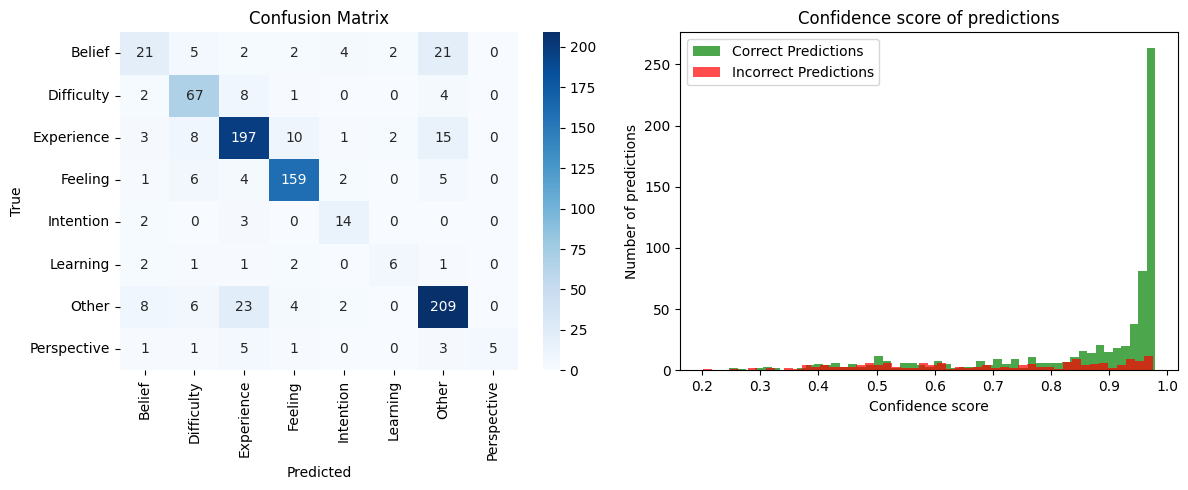

In [12]:
predicted_labels = ' '.join(predicted_labels)
true_labels = ' '.join(true_labels)

predicted_labels = re.sub(r'(?<!^)(?=[A-Z])', ' ', predicted_labels).split() # add a comma before each label in capital letters
true_labels = re.sub(r'(?<!^)(?=[A-Z])', ' ', true_labels).split()

test_multiclass_CV(true_labels, predicted_labels, pred_confidence, class_labels)

In [98]:
### HP ###
bs = 16
n_splits = 5
epochs = 10

### Training results ###

train_loss_list = [1.1686225113543598, 0.6528626948225597, 0.4121940547969839, 0.2435560079353038, 0.13940672782703864, 0.08570936274876402, 0.05667252548631619, 0.03965399115469522, 0.030609601017564905, 0.05452426668248824, 1.3114573361952442, 0.7613869650858985, 0.5111314375415321, 0.31500400259536654, 0.2011231005515072, 0.12529104610150757, 0.08630121209512441, 0.06120809242668108, 0.04725002014455347, 0.042029619594066106, 1.3184735040403595, 0.7959916892746264, 0.5356201877094005, 0.3381296045431667, 0.20913226099700227, 0.12422211824970181, 0.087859440922029, 0.06272783665340548, 0.047359730628865566, 0.03868556863913113, 1.3769527439736138, 0.8216380289147708, 0.5453904325311835, 0.3291921093752069, 0.18383673282170837, 0.11301389499759872, 0.07466789544752438, 0.053852134522758735, 0.04128276468600985, 0.035564291714267296, 1.360321336541294, 0.8536505503964819, 0.5782216648178652, 0.3751048535909042, 0.2362558733641116, 0.14926539054371354, 0.09964623764034145, 0.07383313531456284, 0.05537583209066228, 0.04730360956924144]

val_loss_list = [0.8561615069381526, 0.6852014528923347, 0.7067605674755378, 0.756350578343282, 0.8010671177848441, 0.8289088047430163, 0.8781354744903377, 0.8918799535661447, 0.9200573070127456, 0.9276627910430314, 0.9184021842284281, 0.7492094833831318, 0.7283192676354627, 0.7448018168816801, 0.7786853418487018, 0.8501767910039816, 0.8542363946097064, 0.921858787322875, 0.9185296284706622, 0.9204453685488857, 0.9291203945386605, 0.7072305071060775, 0.6769066722910912, 0.7125358891780259, 0.7515167016841349, 0.8022700502369248, 0.8266985863141838, 0.8688718255792485, 0.8876947747146497, 0.8961204026566177, 1.048172778770572, 0.8038928200964068, 0.7433682367449901, 0.8744938757087364, 0.8402268158607795, 0.9192915908137306, 0.9580370006991215, 0.9967968048619442, 1.0313239722955423, 1.0175103423048237, 0.9688006913075682, 0.7747230314817585, 0.7245263530582678, 0.7528767720109126, 0.8033180298497442, 0.8705871665819747, 0.9124524341743501, 0.9133702404186373, 0.9452290495888132, 0.9480211746985795]

train_acc_list = [0.6144672024889811, 0.8014000518537724, 0.8747731397459165, 0.9294788695877625, 0.9655172413793104, 0.9826289862587503, 0.9896292455276121, 0.9932590095929479, 0.9955924293492352, 0.9974073113819031, 0.556390977443609, 0.7656209489240342, 0.8454757583614207, 0.9121078558465129, 0.9465906144672025, 0.9719989629245528, 0.9802955665024631, 0.9891107078039928, 0.9942960850401866, 0.9955924293492352, 0.5495075168481078, 0.7579056505961638, 0.8343701399688958, 0.9066874027993779, 0.9455676516329704, 0.9730430274753759, 0.9813374805598756, 0.9893727319854847, 0.993260756868844, 0.9955935717988595, 0.5160705028512182, 0.7511664074650077, 0.8395541731467081, 0.9048729911871436, 0.9520476931052358, 0.9764126490409538, 0.9867807153965785, 0.9909279419388284, 0.994556765163297, 0.995334370139969, 0.5373250388802489, 0.7405391394504924, 0.8242612752721618, 0.8913945049248315, 0.9370139968895801, 0.9652669777086573, 0.9787454639709694, 0.9860031104199067, 0.9917055469155003, 0.9930015552099534]

val_acc_list = [0.7378238341968912, 0.7823834196891192, 0.783419689119171, 0.7906735751295336, 0.783419689119171, 0.794818652849741, 0.7927461139896373, 0.7968911917098446, 0.794818652849741, 0.7927461139896373, 0.7316062176165803, 0.7740932642487046, 0.7761658031088083, 0.7813471502590673, 0.7854922279792746, 0.7689119170984456, 0.7844559585492228, 0.7751295336787565, 0.7823834196891192, 0.7813471502590673, 0.7157676348547718, 0.7925311203319502, 0.7966804979253111, 0.7956431535269709, 0.7852697095435685, 0.7863070539419087, 0.799792531120332, 0.7883817427385892, 0.7894190871369294, 0.7935684647302904, 0.6804979253112033, 0.7375518672199171, 0.7603734439834025, 0.7520746887966805, 0.7676348547717843, 0.7603734439834025, 0.7614107883817427, 0.7614107883817427, 0.7634854771784232, 0.7686721991701245, 0.6950207468879668, 0.7593360995850622, 0.766597510373444, 0.7531120331950207, 0.7717842323651453, 0.7655601659751037, 0.7686721991701245, 0.7697095435684648, 0.7738589211618258, 0.770746887966805]
#Accuracy on test dataset =  0.789

### Evaluation results ###

predicted_labels = ['Feeling' 'Other' 'Other' 'Experience' 'Other' 'Feeling' 'Other'
 'Difficulty' 'Difficulty' 'Experience' 'Feeling' 'Other' 'Experience'
 'Other' 'Feeling' 'Perspective' 'Experience' 'Experience' 'Other'
 'Experience' 'Experience' 'Experience' 'Experience' 'Difficulty' 'Other'
 'Belief' 'Other' 'Feeling' 'Experience' 'Feeling' 'Feeling' 'Difficulty'
 'Other' 'Other' 'Difficulty' 'Other' 'Feeling' 'Other' 'Experience'
 'Feeling' 'Feeling' 'Other' 'Difficulty' 'Other' 'Experience'
 'Experience' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Experience'
 'Other' 'Intention' 'Feeling' 'Other' 'Other' 'Feeling' 'Other' 'Other'
 'Other' 'Experience' 'Experience' 'Other' 'Experience' 'Feeling' 'Other'
 'Experience' 'Feeling' 'Experience' 'Feeling' 'Other' 'Experience'
 'Other' 'Other' 'Experience' 'Other' 'Feeling' 'Feeling' 'Experience'
 'Feeling' 'Difficulty' 'Experience' 'Other' 'Other' 'Experience'
 'Experience' 'Other' 'Intention' 'Other' 'Experience' 'Other' 'Other'
 'Other' 'Experience' 'Difficulty' 'Feeling' 'Experience' 'Other'
 'Feeling' 'Feeling' 'Experience' 'Other' 'Experience' 'Experience'
 'Experience' 'Other' 'Other' 'Feeling' 'Other' 'Belief' 'Experience'
 'Feeling' 'Feeling' 'Difficulty' 'Feeling' 'Feeling' 'Experience' 'Other'
 'Other' 'Other' 'Belief' 'Feeling' 'Experience' 'Experience' 'Feeling'
 'Other' 'Other' 'Belief' 'Experience' 'Experience' 'Learning' 'Other'
 'Other' 'Experience' 'Perspective' 'Perspective' 'Other' 'Feeling'
 'Learning' 'Feeling' 'Feeling' 'Feeling' 'Other' 'Experience'
 'Experience' 'Belief' 'Feeling' 'Other' 'Other' 'Feeling' 'Other'
 'Learning' 'Experience' 'Belief' 'Belief' 'Other' 'Experience' 'Other'
 'Experience' 'Difficulty' 'Experience' 'Experience' 'Difficulty'
 'Feeling' 'Belief' 'Feeling' 'Experience' 'Feeling' 'Other' 'Feeling'
 'Difficulty' 'Difficulty' 'Experience' 'Experience' 'Other' 'Experience'
 'Experience' 'Feeling' 'Other' 'Belief' 'Feeling' 'Other' 'Experience'
 'Belief' 'Other' 'Intention' 'Experience' 'Feeling' 'Other' 'Other'
 'Experience' 'Experience' 'Experience' 'Experience' 'Difficulty' 'Other'
 'Experience' 'Feeling' 'Other' 'Experience' 'Learning' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Experience'
 'Other' 'Experience' 'Difficulty' 'Feeling' 'Feeling' 'Other' 'Other'
 'Feeling' 'Other' 'Feeling' 'Experience' 'Difficulty' 'Other'
 'Experience' 'Other' 'Other' 'Experience' 'Feeling' 'Difficulty' 'Other'
 'Difficulty' 'Feeling' 'Other' 'Other' 'Feeling' 'Experience' 'Feeling'
 'Experience' 'Experience' 'Experience' 'Other' 'Feeling' 'Experience'
 'Difficulty' 'Difficulty' 'Difficulty' 'Perspective' 'Feeling' 'Other'
 'Experience' 'Other' 'Experience' 'Difficulty' 'Other' 'Feeling' 'Other'
 'Feeling' 'Feeling' 'Difficulty' 'Other' 'Experience' 'Feeling'
 'Experience' 'Feeling' 'Feeling' 'Experience' 'Feeling' 'Feeling' 'Other'
 'Intention' 'Other' 'Difficulty' 'Other' 'Difficulty' 'Feeling' 'Feeling'
 'Difficulty' 'Experience' 'Experience' 'Other' 'Other' 'Difficulty'
 'Experience' 'Experience' 'Belief' 'Experience' 'Difficulty' 'Experience'
 'Feeling' 'Other' 'Other' 'Other' 'Feeling' 'Difficulty' 'Experience'
 'Other' 'Other' 'Belief' 'Other' 'Other' 'Feeling' 'Experience' 'Feeling'
 'Belief' 'Difficulty' 'Feeling' 'Other' 'Other' 'Difficulty'
 'Perspective' 'Intention' 'Other' 'Experience' 'Other' 'Experience'
 'Experience' 'Other' 'Experience' 'Experience' 'Experience' 'Experience'
 'Difficulty' 'Other' 'Feeling' 'Feeling' 'Experience' 'Experience'
 'Other' 'Difficulty' 'Experience' 'Other' 'Other' 'Experience'
 'Experience' 'Other' 'Other' 'Feeling' 'Difficulty' 'Learning' 'Other'
 'Belief' 'Feeling' 'Other' 'Other' 'Experience' 'Experience' 'Other'
 'Other' 'Other' 'Other' 'Feeling' 'Feeling' 'Experience' 'Other'
 'Feeling' 'Belief' 'Difficulty' 'Feeling' 'Other' 'Other' 'Other'
 'Difficulty' 'Experience' 'Belief' 'Difficulty' 'Feeling' 'Experience'
 'Experience' 'Experience' 'Difficulty' 'Experience' 'Difficulty'
 'Experience' 'Feeling' 'Feeling' 'Feeling' 'Difficulty' 'Other' 'Other'
 'Other' 'Feeling' 'Difficulty' 'Experience' 'Other' 'Difficulty' 'Other'
 'Feeling' 'Belief' 'Experience' 'Other' 'Belief' 'Other' 'Other'
 'Experience' 'Feeling' 'Learning' 'Other' 'Difficulty' 'Other' 'Feeling'
 'Experience' 'Experience' 'Other' 'Other' 'Belief' 'Difficulty' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Feeling' 'Difficulty' 'Feeling'
 'Other' 'Difficulty' 'Experience' 'Feeling' 'Difficulty' 'Experience'
 'Difficulty' 'Belief' 'Intention' 'Other' 'Other' 'Experience' 'Feeling'
 'Experience' 'Belief' 'Other' 'Other' 'Feeling' 'Difficulty' 'Other'
 'Feeling' 'Experience' 'Difficulty' 'Feeling' 'Feeling' 'Other'
 'Experience' 'Belief' 'Feeling' 'Other' 'Feeling' 'Experience'
 'Difficulty' 'Other' 'Feeling' 'Intention' 'Feeling' 'Other' 'Experience'
 'Difficulty' 'Experience' 'Experience' 'Other' 'Other' 'Experience'
 'Other' 'Other' 'Other' 'Feeling' 'Feeling' 'Experience' 'Experience'
 'Other' 'Feeling' 'Feeling' 'Other' 'Experience' 'Belief' 'Feeling'
 'Other' 'Feeling' 'Experience' 'Other' 'Experience' 'Feeling'
 'Difficulty' 'Difficulty' 'Experience' 'Other' 'Other' 'Other'
 'Experience' 'Feeling' 'Feeling' 'Feeling' 'Experience' 'Other' 'Feeling'
 'Feeling' 'Experience' 'Experience' 'Other' 'Other' 'Experience'
 'Experience' 'Other' 'Other' 'Feeling' 'Other' 'Experience' 'Experience'
 'Intention' 'Experience' 'Other' 'Difficulty' 'Intention' 'Learning'
 'Experience' 'Experience' 'Experience' 'Other' 'Feeling' 'Other'
 'Experience' 'Experience' 'Experience' 'Experience' 'Difficulty'
 'Experience' 'Feeling' 'Difficulty' 'Other' 'Difficulty' 'Difficulty'
 'Feeling' 'Experience' 'Other' 'Experience' 'Intention' 'Feeling'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other'
 'Experience' 'Learning' 'Experience' 'Experience' 'Other' 'Feeling'
 'Experience' 'Feeling' 'Experience' 'Intention' 'Belief' 'Feeling'
 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Perspective' 'Difficulty'
 'Other' 'Feeling' 'Feeling' 'Feeling' 'Experience' 'Other' 'Other'
 'Other' 'Experience' 'Feeling' 'Difficulty' 'Feeling' 'Experience'
 'Belief' 'Experience' 'Other' 'Feeling' 'Feeling' 'Difficulty'
 'Experience' 'Difficulty' 'Experience' 'Experience' 'Other' 'Difficulty'
 'Feeling' 'Belief' 'Experience' 'Other' 'Experience' 'Feeling'
 'Experience' 'Other' 'Feeling' 'Difficulty' 'Experience' 'Perspective'
 'Experience' 'Experience' 'Feeling' 'Feeling' 'Difficulty' 'Experience'
 'Experience' 'Belief' 'Other' 'Experience' 'Feeling' 'Perspective'
 'Feeling' 'Feeling' 'Other' 'Difficulty' 'Other' 'Other' 'Other'
 'Experience' 'Feeling' 'Other' 'Feeling' 'Perspective' 'Difficulty'
 'Feeling' 'Experience' 'Other' 'Feeling' 'Difficulty' 'Other'
 'Experience' 'Feeling' 'Other' 'Experience' 'Feeling' 'Other' 'Feeling'
 'Other' 'Other' 'Difficulty' 'Experience' 'Experience' 'Other' 'Other'
 'Difficulty' 'Difficulty' 'Other' 'Feeling' 'Experience' 'Experience'
 'Other' 'Feeling' 'Other' 'Perspective' 'Belief' 'Belief' 'Experience'
 'Intention' 'Feeling' 'Other' 'Other' 'Experience' 'Experience'
 'Experience' 'Experience' 'Other' 'Other' 'Feeling' 'Belief'
 'Perspective' 'Feeling' 'Learning' 'Feeling' 'Experience' 'Other' 'Other'
 'Other' 'Feeling' 'Difficulty' 'Difficulty' 'Experience' 'Other'
 'Difficulty' 'Difficulty' 'Intention' 'Feeling' 'Experience' 'Feeling'
 'Other' 'Other' 'Feeling' 'Belief' 'Feeling' 'Difficulty' 'Other'
 'Learning' 'Experience' 'Experience' 'Experience' 'Feeling' 'Experience'
 'Other' 'Other' 'Other' 'Feeling' 'Feeling' 'Experience' 'Experience'
 'Other' 'Belief' 'Experience' 'Other' 'Experience' 'Difficulty'
 'Experience' 'Experience' 'Difficulty' 'Intention' 'Difficulty'
 'Difficulty' 'Feeling' 'Intention' 'Belief' 'Experience' 'Feeling'
 'Feeling' 'Intention' 'Experience' 'Other' 'Feeling' 'Difficulty'
 'Difficulty' 'Belief' 'Other' 'Other' 'Other' 'Experience' 'Belief'
 'Other' 'Experience' 'Other' 'Feeling' 'Feeling' 'Difficulty'
 'Experience' 'Intention' 'Other' 'Difficulty' 'Other' 'Other' 'Other'
 'Feeling' 'Difficulty' 'Other' 'Perspective' 'Other' 'Experience'
 'Difficulty' 'Other' 'Difficulty' 'Other' 'Experience' 'Feeling'
 'Experience' 'Difficulty' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Feeling' 'Difficulty' 'Experience' 'Other' 'Experience' 'Feeling'
 'Feeling' 'Difficulty' 'Experience' 'Feeling' 'Difficulty' 'Experience'
 'Intention' 'Experience' 'Other' 'Other' 'Feeling' 'Experience'
 'Intention' 'Belief' 'Difficulty' 'Experience' 'Difficulty' 'Other'
 'Difficulty' 'Experience' 'Other' 'Experience' 'Difficulty' 'Other'
 'Belief' 'Feeling' 'Other' 'Experience' 'Experience' 'Experience'
 'Feeling' 'Feeling' 'Difficulty' 'Other' 'Other' 'Feeling' 'Other'
 'Feeling' 'Difficulty' 'Other' 'Other' 'Experience' 'Experience' 'Other'
 'Belief' 'Other' 'Other' 'Experience' 'Experience' 'Feeling' 'Other'
 'Other' 'Feeling' 'Other' 'Intention' 'Experience' 'Difficulty'
 'Intention' 'Experience' 'Other' 'Experience' 'Experience' 'Difficulty'
 'Other' 'Feeling' 'Belief' 'Other' 'Experience' 'Experience' 'Experience'
 'Other' 'Feeling' 'Experience' 'Experience' 'Feeling' 'Other' 'Feeling']

true_labels = ['Feeling' 'Other' 'Other' 'Experience' 'Other' 'Feeling' 'Other' 'Other'
 'Difficulty' 'Experience' 'Belief' 'Other' 'Experience' 'Other' 'Feeling'
 'Perspective' 'Experience' 'Experience' 'Belief' 'Experience' 'Intention'
 'Experience' 'Difficulty' 'Difficulty' 'Feeling' 'Belief' 'Other'
 'Feeling' 'Experience' 'Feeling' 'Feeling' 'Other' 'Other' 'Other'
 'Difficulty' 'Other' 'Feeling' 'Other' 'Experience' 'Belief' 'Feeling'
 'Other' 'Difficulty' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Experience' 'Other' 'Belief' 'Feeling' 'Other'
 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Experience' 'Experience'
 'Other' 'Experience' 'Feeling' 'Belief' 'Experience' 'Feeling'
 'Experience' 'Feeling' 'Belief' 'Experience' 'Other' 'Other' 'Difficulty'
 'Belief' 'Feeling' 'Feeling' 'Experience' 'Feeling' 'Difficulty'
 'Experience' 'Other' 'Belief' 'Experience' 'Experience' 'Experience'
 'Intention' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Experience'
 'Difficulty' 'Belief' 'Experience' 'Feeling' 'Feeling' 'Feeling'
 'Experience' 'Other' 'Experience' 'Experience' 'Experience' 'Other'
 'Other' 'Feeling' 'Other' 'Belief' 'Experience' 'Feeling' 'Feeling'
 'Difficulty' 'Feeling' 'Feeling' 'Experience' 'Perspective' 'Other'
 'Experience' 'Belief' 'Feeling' 'Other' 'Feeling' 'Feeling' 'Other'
 'Other' 'Other' 'Experience' 'Experience' 'Learning' 'Other' 'Other'
 'Experience' 'Perspective' 'Experience' 'Other' 'Feeling' 'Difficulty'
 'Feeling' 'Feeling' 'Feeling' 'Other' 'Experience' 'Experience' 'Belief'
 'Feeling' 'Other' 'Other' 'Feeling' 'Intention' 'Learning' 'Experience'
 'Belief' 'Intention' 'Other' 'Experience' 'Other' 'Feeling' 'Difficulty'
 'Experience' 'Experience' 'Difficulty' 'Feeling' 'Learning' 'Feeling'
 'Experience' 'Feeling' 'Other' 'Feeling' 'Feeling' 'Experience'
 'Experience' 'Experience' 'Other' 'Experience' 'Other' 'Feeling' 'Other'
 'Belief' 'Feeling' 'Other' 'Experience' 'Other' 'Other' 'Intention'
 'Feeling' 'Feeling' 'Other' 'Other' 'Experience' 'Experience'
 'Experience' 'Experience' 'Other' 'Other' 'Experience' 'Feeling' 'Other'
 'Experience' 'Experience' 'Other' 'Experience' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Experience' 'Other' 'Experience' 'Difficulty'
 'Feeling' 'Experience' 'Intention' 'Other' 'Feeling' 'Other' 'Feeling'
 'Experience' 'Difficulty' 'Other' 'Experience' 'Other' 'Other'
 'Experience' 'Feeling' 'Difficulty' 'Feeling' 'Difficulty' 'Feeling'
 'Other' 'Other' 'Feeling' 'Experience' 'Experience' 'Experience' 'Other'
 'Experience' 'Difficulty' 'Feeling' 'Other' 'Difficulty' 'Other'
 'Difficulty' 'Perspective' 'Feeling' 'Other' 'Experience' 'Belief'
 'Experience' 'Difficulty' 'Other' 'Feeling' 'Other' 'Feeling' 'Feeling'
 'Difficulty' 'Other' 'Experience' 'Feeling' 'Experience' 'Other'
 'Feeling' 'Other' 'Feeling' 'Feeling' 'Other' 'Belief' 'Other'
 'Experience' 'Belief' 'Difficulty' 'Feeling' 'Feeling' 'Difficulty'
 'Experience' 'Experience' 'Other' 'Other' 'Difficulty' 'Experience'
 'Other' 'Difficulty' 'Experience' 'Difficulty' 'Experience' 'Feeling'
 'Other' 'Belief' 'Other' 'Experience' 'Belief' 'Experience' 'Experience'
 'Belief' 'Other' 'Other' 'Other' 'Experience' 'Belief' 'Feeling' 'Belief'
 'Difficulty' 'Feeling' 'Other' 'Other' 'Difficulty' 'Experience'
 'Intention' 'Other' 'Experience' 'Other' 'Difficulty' 'Experience'
 'Other' 'Experience' 'Experience' 'Experience' 'Experience' 'Difficulty'
 'Other' 'Feeling' 'Feeling' 'Experience' 'Difficulty' 'Other'
 'Difficulty' 'Experience' 'Other' 'Experience' 'Experience' 'Experience'
 'Other' 'Other' 'Feeling' 'Difficulty' 'Learning' 'Experience' 'Belief'
 'Feeling' 'Other' 'Other' 'Experience' 'Experience' 'Belief' 'Other'
 'Other' 'Other' 'Experience' 'Feeling' 'Experience' 'Other' 'Feeling'
 'Belief' 'Experience' 'Feeling' 'Other' 'Experience' 'Other' 'Difficulty'
 'Experience' 'Other' 'Other' 'Feeling' 'Experience' 'Experience' 'Other'
 'Belief' 'Experience' 'Difficulty' 'Experience' 'Feeling' 'Feeling'
 'Feeling' 'Belief' 'Other' 'Intention' 'Other' 'Feeling' 'Belief'
 'Belief' 'Other' 'Difficulty' 'Other' 'Feeling' 'Belief' 'Experience'
 'Other' 'Belief' 'Other' 'Other' 'Experience' 'Feeling' 'Learning'
 'Other' 'Perspective' 'Other' 'Feeling' 'Perspective' 'Experience'
 'Experience' 'Perspective' 'Intention' 'Feeling' 'Other' 'Experience'
 'Difficulty' 'Other' 'Other' 'Feeling' 'Difficulty' 'Feeling' 'Other'
 'Difficulty' 'Other' 'Feeling' 'Difficulty' 'Experience' 'Other'
 'Experience' 'Intention' 'Experience' 'Other' 'Experience' 'Feeling'
 'Experience' 'Difficulty' 'Belief' 'Other' 'Feeling' 'Difficulty' 'Other'
 'Feeling' 'Experience' 'Feeling' 'Experience' 'Feeling' 'Experience'
 'Experience' 'Other' 'Experience' 'Other' 'Feeling' 'Experience'
 'Difficulty' 'Other' 'Feeling' 'Intention' 'Feeling' 'Belief'
 'Experience' 'Difficulty' 'Experience' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Feeling' 'Feeling' 'Feeling' 'Experience'
 'Experience' 'Other' 'Feeling' 'Other' 'Other' 'Experience' 'Belief'
 'Feeling' 'Other' 'Feeling' 'Experience' 'Other' 'Other' 'Feeling'
 'Experience' 'Difficulty' 'Experience' 'Other' 'Other' 'Other'
 'Experience' 'Feeling' 'Feeling' 'Feeling' 'Experience' 'Other' 'Feeling'
 'Feeling' 'Other' 'Experience' 'Feeling' 'Other' 'Experience'
 'Experience' 'Other' 'Other' 'Feeling' 'Other' 'Perspective' 'Other'
 'Intention' 'Experience' 'Other' 'Difficulty' 'Intention' 'Belief'
 'Experience' 'Experience' 'Experience' 'Other' 'Feeling' 'Other'
 'Experience' 'Experience' 'Experience' 'Difficulty' 'Difficulty'
 'Experience' 'Feeling' 'Difficulty' 'Other' 'Difficulty' 'Difficulty'
 'Feeling' 'Experience' 'Other' 'Experience' 'Experience' 'Feeling'
 'Experience' 'Belief' 'Belief' 'Belief' 'Other' 'Feeling' 'Other' 'Other'
 'Feeling' 'Learning' 'Experience' 'Experience' 'Other' 'Feeling'
 'Experience' 'Feeling' 'Experience' 'Feeling' 'Other' 'Feeling' 'Other'
 'Other' 'Other' 'Other' 'Learning' 'Perspective' 'Experience' 'Other'
 'Other' 'Feeling' 'Feeling' 'Experience' 'Experience' 'Other' 'Other'
 'Experience' 'Experience' 'Difficulty' 'Feeling' 'Experience' 'Belief'
 'Experience' 'Difficulty' 'Feeling' 'Feeling' 'Feeling' 'Experience'
 'Difficulty' 'Experience' 'Experience' 'Other' 'Difficulty' 'Feeling'
 'Belief' 'Other' 'Other' 'Experience' 'Feeling' 'Experience' 'Other'
 'Experience' 'Experience' 'Experience' 'Perspective' 'Experience'
 'Experience' 'Feeling' 'Feeling' 'Difficulty' 'Other' 'Experience'
 'Experience' 'Other' 'Experience' 'Learning' 'Experience' 'Experience'
 'Feeling' 'Other' 'Difficulty' 'Other' 'Belief' 'Other' 'Experience'
 'Feeling' 'Other' 'Feeling' 'Perspective' 'Learning' 'Feeling' 'Feeling'
 'Other' 'Feeling' 'Feeling' 'Other' 'Experience' 'Feeling' 'Other'
 'Experience' 'Feeling' 'Other' 'Feeling' 'Other' 'Other' 'Difficulty'
 'Experience' 'Experience' 'Other' 'Other' 'Difficulty' 'Difficulty'
 'Other' 'Feeling' 'Experience' 'Experience' 'Other' 'Feeling' 'Other'
 'Experience' 'Other' 'Belief' 'Other' 'Belief' 'Feeling' 'Belief' 'Other'
 'Experience' 'Experience' 'Experience' 'Experience' 'Other' 'Experience'
 'Feeling' 'Belief' 'Perspective' 'Feeling' 'Experience' 'Feeling'
 'Experience' 'Other' 'Other' 'Belief' 'Difficulty' 'Other' 'Experience'
 'Feeling' 'Belief' 'Difficulty' 'Difficulty' 'Intention' 'Feeling'
 'Experience' 'Feeling' 'Other' 'Other' 'Feeling' 'Belief' 'Feeling'
 'Experience' 'Other' 'Learning' 'Learning' 'Experience' 'Other' 'Feeling'
 'Difficulty' 'Other' 'Belief' 'Other' 'Feeling' 'Feeling' 'Experience'
 'Experience' 'Belief' 'Belief' 'Experience' 'Other' 'Experience'
 'Experience' 'Experience' 'Feeling' 'Difficulty' 'Intention' 'Difficulty'
 'Experience' 'Feeling' 'Feeling' 'Learning' 'Other' 'Experience'
 'Feeling' 'Difficulty' 'Experience' 'Other' 'Feeling' 'Difficulty'
 'Feeling' 'Belief' 'Other' 'Other' 'Belief' 'Experience' 'Learning'
 'Other' 'Experience' 'Perspective' 'Feeling' 'Feeling' 'Other' 'Other'
 'Other' 'Other' 'Difficulty' 'Other' 'Experience' 'Other' 'Experience'
 'Difficulty' 'Other' 'Perspective' 'Other' 'Experience' 'Difficulty'
 'Other' 'Difficulty' 'Other' 'Experience' 'Feeling' 'Experience'
 'Difficulty' 'Other' 'Other' 'Experience' 'Experience' 'Other' 'Feeling'
 'Difficulty' 'Experience' 'Other' 'Experience' 'Feeling' 'Feeling'
 'Experience' 'Difficulty' 'Feeling' 'Difficulty' 'Experience' 'Intention'
 'Experience' 'Other' 'Experience' 'Feeling' 'Difficulty' 'Intention'
 'Other' 'Experience' 'Experience' 'Difficulty' 'Other' 'Perspective'
 'Experience' 'Other' 'Experience' 'Difficulty' 'Other' 'Belief' 'Feeling'
 'Other' 'Experience' 'Experience' 'Experience' 'Feeling' 'Feeling'
 'Belief' 'Other' 'Other' 'Feeling' 'Other' 'Feeling' 'Difficulty' 'Other'
 'Other' 'Experience' 'Experience' 'Other' 'Feeling' 'Other' 'Other'
 'Experience' 'Experience' 'Feeling' 'Other' 'Other' 'Feeling' 'Other'
 'Intention' 'Experience' 'Difficulty' 'Intention' 'Experience' 'Other'
 'Experience' 'Experience' 'Difficulty' 'Other' 'Feeling' 'Belief' 'Other'
 'Experience' 'Experience' 'Perspective' 'Other' 'Feeling' 'Experience'
 'Experience' 'Feeling' 'Other' 'Feeling']

pred_confidence = [0.9930177, 0.98170567, 0.9954489, 0.996438, 0.9611754, 0.99178666, 0.9923413, 0.47792226, 0.72768337, 0.9935122, 0.9881765, 0.98158777, 0.9114245, 0.99610645, 0.99312323, 0.64514685, 0.99662316, 0.99689746, 0.9938898, 0.9317089, 0.96632665, 0.9625734, 0.9966738, 0.75909686, 0.9876744, 0.9853345, 0.9959586, 0.9931605, 0.9949545, 0.9935163, 0.9348447, 0.6415958, 0.7224505, 0.99592257, 0.9542326, 0.99604225, 0.9929289, 0.9963153, 0.6254503, 0.9934824, 0.9931692, 0.9235401, 0.91708434, 0.99250585, 0.9720666, 0.9799707, 0.9939359, 0.9943962, 0.84873223, 0.80687237, 0.99476045, 0.99530303, 0.994994, 0.94780225, 0.9933647, 0.99542385, 0.49637738, 0.9927108, 0.996378, 0.98554265, 0.99436355, 0.9964702, 0.99661994, 0.9910556, 0.995203, 0.5121621, 0.9896444, 0.99657506, 0.99334466, 0.9916088, 0.9936684, 0.95321125, 0.9878853, 0.9300036, 0.99653304, 0.8329715, 0.992029, 0.9937215, 0.9392801, 0.92346823, 0.9930441, 0.67246604, 0.99597603, 0.97148347, 0.9900305, 0.9967961, 0.9925833, 0.99124724, 0.9315736, 0.9672967, 0.99556893, 0.88707024, 0.9926146, 0.99689263, 0.8304106, 0.9858161, 0.8078333, 0.9960814, 0.9922537, 0.99336195, 0.9910424, 0.9958021, 0.99587375, 0.99650866, 0.99691063, 0.99610525, 0.9961092, 0.7002719, 0.9919167, 0.98771787, 0.9647462, 0.7505011, 0.9934801, 0.99314606, 0.9856011, 0.9935115, 0.99293655, 0.9962613, 0.43373945, 0.99658906, 0.82327956, 0.9802437, 0.993291, 0.55955726, 0.9813378, 0.99381423, 0.99601585, 0.9933389, 0.9872435, 0.98302346, 0.8849142, 0.8325994, 0.9637304, 0.9928756, 0.99475753, 0.4374685, 0.7496814, 0.99336994, 0.993683, 0.61664075, 0.99084574, 0.99353, 0.99375594, 0.9938676, 0.99556583, 0.9965166, 0.89531237, 0.9937697, 0.58549875, 0.9924158, 0.9907692, 0.47852322, 0.9302545, 0.99648666, 0.98580754, 0.8312044, 0.9954894, 0.9817873, 0.9947246, 0.9940149, 0.9483812, 0.99538547, 0.9962676, 0.6210395, 0.99335164, 0.56037056, 0.99321586, 0.90230113, 0.9940445, 0.9855399, 0.9932106, 0.734267, 0.9573927, 0.9681102, 0.97941154, 0.9920306, 0.99642664, 0.9965857, 0.993258, 0.99622726, 0.96408594, 0.993523, 0.98833805, 0.9955332, 0.97766006, 0.99567753, 0.94545597, 0.49885798, 0.99323153, 0.83866984, 0.9960985, 0.99470586, 0.99671847, 0.95095336, 0.994517, 0.97840846, 0.9954169, 0.9958144, 0.9912725, 0.9955329, 0.9887333, 0.39793482, 0.9728563, 0.996797, 0.9169188, 0.9670638, 0.98543, 0.9718285, 0.9936957, 0.995323, 0.9947748, 0.9947218, 0.98454064, 0.99362683, 0.95454484, 0.85209835, 0.99306387, 0.9928227, 0.91112417, 0.99109346, 0.9964553, 0.96586823, 0.9929744, 0.9792844, 0.8396866, 0.9957897, 0.9963018, 0.9932121, 0.98578924, 0.98364013, 0.98428047, 0.9926076, 0.972703, 0.9934057, 0.9939036, 0.9966852, 0.99411726, 0.99671644, 0.6716001, 0.9811833, 0.98630583, 0.9866571, 0.5585033, 0.9865833, 0.9423728, 0.9827137, 0.7757313, 0.9932027, 0.9919314, 0.9482089, 0.9930528, 0.99663854, 0.9627422, 0.4121604, 0.99327177, 0.9947484, 0.9939639, 0.99370015, 0.5688267, 0.7110724, 0.94588965, 0.9936098, 0.9951142, 0.9530227, 0.9907761, 0.95592934, 0.99283844, 0.9934495, 0.97405255, 0.4802332, 0.6553264, 0.5058892, 0.9927105, 0.9857932, 0.9853895, 0.98747694, 0.9714868, 0.9752077, 0.99349135, 0.9960284, 0.916713, 0.98466426, 0.9941754, 0.9628453, 0.9458897, 0.9944793, 0.9586708, 0.99611133, 0.9938034, 0.9847703, 0.5951947, 0.9961979, 0.98795205, 0.8358109, 0.99624676, 0.97673994, 0.90796775, 0.5106488, 0.9938269, 0.9933302, 0.9936067, 0.9197188, 0.99369967, 0.946669, 0.97641593, 0.99264526, 0.99567443, 0.99346066, 0.9785458, 0.77646524, 0.9588342, 0.995109, 0.6139691, 0.9859346, 0.99525297, 0.99647874, 0.98979926, 0.99603695, 0.99634993, 0.99518234, 0.9964179, 0.97770864, 0.9792123, 0.8262059, 0.9936473, 0.9956499, 0.9864654, 0.9963588, 0.9441158, 0.99538994, 0.99609804, 0.9850782, 0.99688905, 0.9942425, 0.9878912, 0.99411654, 0.99165314, 0.9842128, 0.9308127, 0.98713315, 0.9778766, 0.9894639, 0.6220062, 0.99408543, 0.995374, 0.9951138, 0.5840012, 0.87188303, 0.99577016, 0.99243236, 0.84255594, 0.9936773, 0.97914666, 0.9963993, 0.99273986, 0.9603635, 0.9033547, 0.9925396, 0.9949517, 0.9871199, 0.96079874, 0.76039517, 0.9965217, 0.9843216, 0.8829174, 0.9939137, 0.99665415, 0.99318695, 0.9522956, 0.9775121, 0.9176334, 0.96891004, 0.9958385, 0.9901036, 0.9925459, 0.9916932, 0.97655743, 0.9585068, 0.8788891, 0.71646935, 0.9377349, 0.9483216, 0.78208447, 0.99460065, 0.8748128, 0.99604475, 0.9934242, 0.9804002, 0.9961356, 0.99569345, 0.56705403, 0.9959817, 0.9894956, 0.99647695, 0.9927159, 0.92863697, 0.9934191, 0.97619367, 0.99449193, 0.99173063, 0.56033576, 0.9306104, 0.9910891, 0.79052705, 0.893213, 0.48404765, 0.9922092, 0.9954052, 0.9851495, 0.9801759, 0.5003174, 0.9922082, 0.98352724, 0.988983, 0.9968004, 0.9832132, 0.995408, 0.983886, 0.9814873, 0.9967289, 0.6640057, 0.73958355, 0.7859019, 0.9381708, 0.99285334, 0.99586415, 0.9905319, 0.9967481, 0.61274844, 0.6928129, 0.98389566, 0.99338174, 0.9644627, 0.9905847, 0.9934394, 0.99641466, 0.9815591, 0.9900114, 0.9924746, 0.993962, 0.99353373, 0.84635717, 0.98144424, 0.6591107, 0.982941, 0.8730578, 0.9512035, 0.99043816, 0.98430437, 0.9324433, 0.98943603, 0.80201834, 0.9966773, 0.9824865, 0.99640226, 0.9833371, 0.9956085, 0.99647033, 0.9906921, 0.9941836, 0.99656314, 0.963285, 0.991063, 0.99364704, 0.9968791, 0.9836526, 0.9937723, 0.55490524, 0.55853945, 0.9929716, 0.8027479, 0.979645, 0.9932111, 0.9351211, 0.99345535, 0.9907923, 0.95863265, 0.99638784, 0.9927522, 0.6166236, 0.76436365, 0.9965681, 0.9947805, 0.99393445, 0.9970017, 0.9962632, 0.9940171, 0.99351853, 0.9938643, 0.99636614, 0.85323584, 0.99211895, 0.9933129, 0.9873782, 0.99220455, 0.9962843, 0.9964896, 0.9964647, 0.9965913, 0.98055947, 0.9879589, 0.9937219, 0.9954236, 0.5207998, 0.99462175, 0.9223798, 0.9963039, 0.8716858, 0.9836622, 0.8564775, 0.874209, 0.98146605, 0.9952989, 0.99685234, 0.99669445, 0.9935668, 0.9959829, 0.9963744, 0.99611145, 0.99605453, 0.9891929, 0.98504424, 0.99347585, 0.8866283, 0.9782471, 0.99468154, 0.9841487, 0.8201734, 0.99344784, 0.99659497, 0.9227192, 0.9942906, 0.3412507, 0.99330455, 0.996546, 0.98849034, 0.9559017, 0.7545642, 0.99542564, 0.9924035, 0.9949216, 0.99007416, 0.9949557, 0.9312467, 0.99672323, 0.99404293, 0.9953075, 0.99305236, 0.9966324, 0.9662121, 0.9963754, 0.8466631, 0.96334636, 0.9935347, 0.98324573, 0.99615616, 0.9248689, 0.9657549, 0.9849614, 0.54227847, 0.52271926, 0.9943553, 0.96256626, 0.96101207, 0.99315697, 0.99683076, 0.9856227, 0.8509165, 0.9929188, 0.99677926, 0.99251324, 0.9629469, 0.9936009, 0.93623215, 0.985269, 0.9867019, 0.69212633, 0.9935656, 0.99378103, 0.82311565, 0.9862505, 0.9853324, 0.99626786, 0.99672, 0.99616134, 0.9796743, 0.9935768, 0.8470117, 0.714255, 0.92967516, 0.9968094, 0.9935486, 0.9965378, 0.99380314, 0.98052394, 0.97416955, 0.9968266, 0.67552185, 0.9852024, 0.9950199, 0.99331963, 0.9792459, 0.98527247, 0.99575824, 0.99686134, 0.6610142, 0.9963483, 0.99157953, 0.9918607, 0.652165, 0.6134653, 0.99291235, 0.99598604, 0.97732395, 0.9942848, 0.9921268, 0.9938258, 0.9968777, 0.99245316, 0.9945241, 0.99356854, 0.8237616, 0.98078936, 0.99319035, 0.96591836, 0.9953601, 0.9938917, 0.9847083, 0.813434, 0.996409, 0.99241674, 0.6404303, 0.9961312, 0.9937729, 0.99418145, 0.98848224, 0.99287415, 0.99660987, 0.5479232, 0.97101134, 0.99517894, 0.9964204, 0.9947666, 0.72222954, 0.97579557, 0.9958534, 0.99348795, 0.9937576, 0.99499786, 0.9952571, 0.97981524, 0.99634427, 0.44552004, 0.96069276, 0.9803003, 0.9638279, 0.8618416, 0.9923751, 0.8636548, 0.99310666, 0.88990456, 0.99657035, 0.99655557, 0.9963337, 0.9840126, 0.37152845, 0.9922903, 0.83153504, 0.81326336, 0.993288, 0.9224064, 0.99310017, 0.9628488, 0.9945146, 0.9961971, 0.99110126, 0.9878392, 0.81603414, 0.9825832, 0.749363, 0.51086915, 0.97563565, 0.9837552, 0.7936481, 0.9935155, 0.9963838, 0.99275726, 0.9739105, 0.93492717, 0.99288285, 0.9606908, 0.9925122, 0.61889136, 0.98183686, 0.92966634, 0.8940165, 0.9962178, 0.9957157, 0.9932476, 0.7312382, 0.99691147, 0.79656804, 0.9964393, 0.9939329, 0.9934916, 0.99653697, 0.9964265, 0.7918063, 0.923625, 0.9961796, 0.99254966, 0.81106824, 0.98561156, 0.99682045, 0.9792829, 0.76059353, 0.72033674, 0.98521185, 0.98274696, 0.9883349, 0.51783335, 0.59437716, 0.866878, 0.98763704, 0.9931206, 0.44254243, 0.9963063, 0.99677026, 0.99353576, 0.67317045, 0.9636825, 0.7085672, 0.9965712, 0.99442977, 0.75810105, 0.99583215, 0.950742, 0.9403662, 0.99183464, 0.9792894, 0.99350715, 0.9923786, 0.50305134, 0.9948695, 0.8848259, 0.99121124, 0.86327934, 0.9958477, 0.99528056, 0.99604887, 0.91874665, 0.9841717, 0.9934789, 0.75751656, 0.9457089, 0.9959926, 0.9774514, 0.9725046, 0.9635441, 0.69697994, 0.9963534, 0.98639685, 0.996729, 0.97583157, 0.99274313, 0.9421363, 0.9892781, 0.99382293, 0.9932908, 0.99347043, 0.96327245, 0.99635196, 0.9793671, 0.747898, 0.99313354, 0.8902695, 0.30807725, 0.9550825, 0.9851577, 0.87059206, 0.9948042, 0.94752485, 0.996932, 0.9959507, 0.9254265, 0.98593926,2158, 0.99128866, 0.9938636, 0.9952604, 0.95769274, 0.9966955, 0.98421615, 0.73939174, 0.9962585, 0.9616548, 0.99247605, 0.9932463, 0.9846777, 0.9887388, 0.99324244, 0.95650256, 0.9956713, 0.9665141, 0.99652004, 0.8352545, 0.98564315, 0.9925073, 0.99659663, 0.9957539, 0.99387157, 0.98728323, 0.9937382]

class_labels = ['Belief', 'Difficulty', 'Experience', 'Feeling', 'Intention', 'Learning', 'Other', 'Perspective']


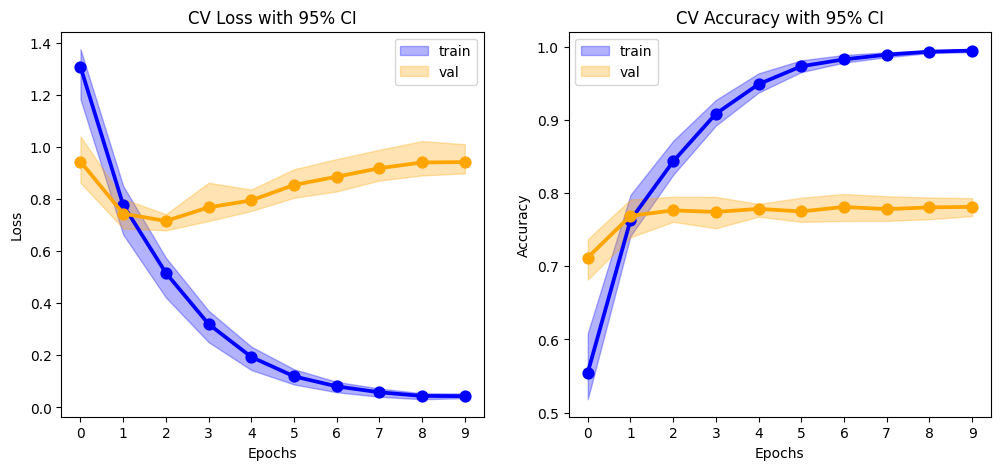

In [99]:
plot_multiclass_CV(train_loss_list, val_loss_list, train_acc_list, val_acc_list, n_splits, epochs)

852
852
813
              precision    recall  f1-score   support

      Belief       0.54      0.37      0.44        57
  Difficulty       0.66      0.80      0.73        82
  Experience       0.82      0.80      0.81       236
     Feeling       0.88      0.88      0.88       177
   Intention       0.62      0.68      0.65        19
    Learning       0.60      0.46      0.52        13
       Other       0.81      0.85      0.83       252
 Perspective       0.67      0.50      0.57        16

    accuracy                           0.79       852
   macro avg       0.70      0.67      0.68       852
weighted avg       0.79      0.79      0.78       852



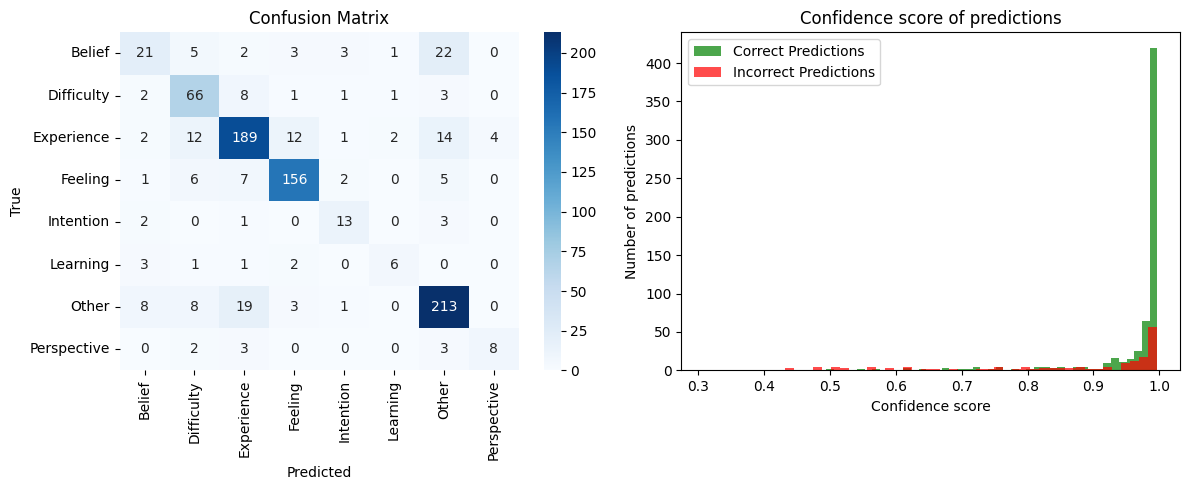

In [100]:
predicted_labels = ' '.join(predicted_labels)
true_labels = ' '.join(true_labels)

predicted_labels = re.sub(r'(?<!^)(?=[A-Z])', ' ', predicted_labels).split() # add a comma before each label in capital letters
true_labels = re.sub(r'(?<!^)(?=[A-Z])', ' ', true_labels).split()

print(len(true_labels))
print(len(predicted_labels))
print(len(pred_confidence))


test_multiclass_CV(true_labels, predicted_labels, pred_confidence, class_labels)

---

# Multiple Binary CLF with CV

### Training/validation

In [7]:
# for testing
def test_more_metrics(reflective_categories, true_labels_df, predicted_labels_df):
    from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score

    label_encoder = LabelEncoder()
    # Initialize variables to store sum of metrics and count of classes
    sum_accuracy = 0.0
    sum_weighted_accuracy = 0.0
    sum_f1 = 0.0
    sum_auc = 0.0
    count_classes = 0

    # Iterate over each 'cat'
    for cat in reflective_categories:
        predicted_labels = predicted_labels_df[cat].values
        true_labels = true_labels_df[cat].values
        
        # Encode labels
        label_encoder = LabelEncoder()
        true_labels_encoded = label_encoder.fit_transform(true_labels)
        predicted_labels_encoded = label_encoder.transform(predicted_labels)
        
        # Calculate metrics
        accuracy = accuracy_score(true_labels, predicted_labels)
        balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
        #f1 = f1_score(true_labels, predicted_labels, labels = [cat, 'Other'], pos_label = cat)
        f1_scores = f1_score(true_labels_encoded, predicted_labels_encoded, pos_label=label_encoder.transform([cat])[0])
        #auc = roc_auc_score(true_labels, predicted_labels) if len(set(true_labels)) > 1 else None  # AUC requires both classes
        auc = roc_auc_score(true_labels_encoded, predicted_labels_encoded) if len(set(true_labels_encoded)) > 1 else None
        
        # Sum metrics
        sum_accuracy += accuracy
        sum_weighted_accuracy += balanced_accuracy
        sum_f1 += f1
        if auc is not None:
            sum_auc += auc
        
        # Increment count of classes
        count_classes += 1
        
        # Print metrics for the current class
        print(f"Overall accuracy for class '{cat}' = {accuracy:.4f}")
        print(f"Balanced accuracy for class '{cat}' = {balanced_accuracy:.4f}")
        print(f"F1 score for class '{cat}' = {f1_scores:.4f}")
        if auc is not None:
            print(f"AUC for class '{cat}' = {auc:.4f}")
        else:
            print(f"AUC for class '{cat}' cannot be computed due to insufficient data")
        print("--------------------------------------")

    # Calculate averages
    avg_accuracy = sum_accuracy / count_classes if count_classes > 0 else 0.0
    avg_weighted_accuracy = sum_weighted_accuracy / count_classes if count_classes > 0 else 0.0
    avg_f1 = sum_f1 / count_classes if count_classes > 0 else 0.0
    avg_auc = sum_auc / count_classes if count_classes > 0 else None
    
        # Print average metrics
    print("#########################################")
    print("############## AVERAGE ##################")
    print("#########################################")
    print(f"Average accuracy across classes = {avg_accuracy:.4f}")
    print(f"Average weighted accuracy across classes = {avg_weighted_accuracy:.4f}")
    print(f"Average F1 score across classes = {avg_f1:.4f}")
    if avg_auc is not None:
        print(f"Average AUC across classes = {avg_auc:.4f}")
    else:
        print("Average AUC across classes cannot be computed due to insufficient data")


**Complete below for training loss**

In [8]:
feeling = '''
   Epochs  Mean_Train_Loss  Lower_CI  Upper_CI
0       0         0.412348  0.362441  0.496602
1       1         0.163087  0.136153  0.189055
2       2         0.073721  0.057389  0.091713
3       3         0.034856  0.023394  0.045682
4       4         0.021661  0.015008  0.029714
'''

experience = '''
   Epochs  Mean_Train_Loss  Lower_CI  Upper_CI
0       0         0.494989  0.417696  0.527123
1       1         0.397372  0.231178  0.510437
2       2         0.304299  0.118310  0.502992
3       3         0.228408  0.049791  0.493273
4       4         0.185744  0.017027  0.483008
'''

difficulty = '''
   Epochs  Mean_Train_Loss  Lower_CI  Upper_CI
0       0         0.431589  0.425170  0.435468
1       1         0.328153  0.263129  0.411474
2       2         0.184859  0.140368  0.268781
3       3         0.081009  0.048250  0.121582
4       4         0.041503  0.022722  0.058204
'''

belief = '''
   Epochs  Mean_Train_Loss  Lower_CI  Upper_CI
0       0         0.394363  0.381661  0.403670
1       1         0.316489  0.253942  0.401059
2       2         0.222532  0.117602  0.389237
3       3         0.161787  0.050997  0.380854
4       4         0.126948  0.020463  0.368583
'''

intention = '''
   Epochs  Mean_Train_Loss  Lower_CI  Upper_CI
0       0         0.151003  0.140991  0.156156
1       1         0.117456  0.092279  0.140695
2       2         0.070182  0.062129  0.086132
3       3         0.036895  0.028337  0.048481
4       4         0.021393  0.013846  0.035571
'''

learning = '''
   Epochs  Mean_Train_Loss  Lower_CI  Upper_CI
0       0         0.143390  0.139680  0.149596
1       1         0.134036  0.124625  0.138847
2       2         0.127190  0.113681  0.137346
3       3         0.092949  0.052462  0.137456
4       4         0.067530  0.025971  0.130073
'''

perspective = '''
   Epochs  Mean_Train_Loss  Lower_CI  Upper_CI
0       0         0.140413  0.126825  0.156826
1       1         0.104921  0.085656  0.138887
2       2         0.076843  0.050783  0.126026
3       3         0.046906  0.021071  0.092827
4       4         0.029405  0.008652  0.067012
'''

In [9]:
dfs_train = {}

# Convert the string data to a file-like object and read the data into a pandas DataFrame
dfs_train['Experience'] = pd.read_csv(io.StringIO(experience), delim_whitespace=True)
dfs_train['Feeling'] = pd.read_csv(io.StringIO(feeling), delim_whitespace=True)
dfs_train['Difficulty'] = pd.read_csv(io.StringIO(difficulty), delim_whitespace=True)
dfs_train['Belief'] = pd.read_csv(io.StringIO(belief), delim_whitespace=True)
dfs_train['Intention'] = pd.read_csv(io.StringIO(intention), delim_whitespace=True)
dfs_train['Perspective'] = pd.read_csv(io.StringIO(perspective), delim_whitespace=True)
dfs_train['Learning'] = pd.read_csv(io.StringIO(learning), delim_whitespace=True)

dfs_train['Experience'].head()

,Epochs,Mean_Train_Loss,Lower_CI,Upper_CI
0,0,0.494989,0.417696,0.527123
1,1,0.397372,0.231178,0.510437
2,2,0.304299,0.118310,0.502992
3,3,0.228408,0.049791,0.493273
4,4,0.185744,0.017027,0.483008


**Complete below for val loss**

In [10]:
feeling = '''
   Epochs  Mean_Val_Loss  Lower_CI  Upper_CI
0       0       0.291354  0.171535  0.418332
1       1       0.182439  0.132933  0.236524
2       2       0.209329  0.133748  0.299935
3       3       0.238236  0.138512  0.318279
4       4       0.244022  0.147396  0.332310
'''

experience = '''
   Epochs  Mean_Val_Loss  Lower_CI  Upper_CI
0       0       0.451925  0.286528  0.551458
1       1       0.379364  0.256345  0.536550
2       2       0.364608  0.266237  0.528538
3       3       0.377592  0.280096  0.521512
4       4       0.386808  0.310931  0.524105
'''

difficulty = '''
   Epochs  Mean_Val_Loss  Lower_CI  Upper_CI
0       0       0.407692  0.297063  0.476808
1       1       0.272870  0.212441  0.403849
2       2       0.247229  0.195220  0.299335
3       3       0.274530  0.213563  0.345782
4       4       0.291568  0.243498  0.339568
'''

belief = '''
   Epochs  Mean_Val_Loss  Lower_CI  Upper_CI
0       0       0.378089  0.281802  0.444645
1       1       0.282557  0.193899  0.399458
2       2       0.280294  0.217287  0.390231
3       3       0.312009  0.261664  0.391298
4       4       0.315480  0.282244  0.372703
'''

intention = '''
   Epochs  Mean_Val_Loss  Lower_CI  Upper_CI
0       0       0.135268  0.118029  0.153803
1       1       0.103228  0.066055  0.155479
2       2       0.078480  0.052966  0.108060
3       3       0.069741  0.053179  0.084733
4       4       0.081761  0.054258  0.114074
'''

learning = '''
   Epochs  Mean_Val_Loss  Lower_CI  Upper_CI
0       0       0.135546  0.109155  0.171753
1       1       0.130736  0.109603  0.164115
2       2       0.111996  0.097536  0.132829
3       3       0.092684  0.057108  0.130624
4       4       0.089674  0.060695  0.128329
'''

perspective = '''
   Epochs  Mean_Val_Loss  Lower_CI  Upper_CI
0       0       0.121653  0.087631  0.152013
1       1       0.095408  0.078102  0.133578
2       2       0.087808  0.063327  0.104140
3       3       0.076394  0.043576  0.106967
4       4       0.085208  0.044051  0.117189
'''


In [11]:
dfs_val = {}

# Convert the string data to a file-like object and read the data into a pandas DataFrame
dfs_val['Experience'] = pd.read_csv(io.StringIO(experience), delim_whitespace=True)
dfs_val['Feeling'] = pd.read_csv(io.StringIO(feeling), delim_whitespace=True)
dfs_val['Difficulty'] = pd.read_csv(io.StringIO(difficulty), delim_whitespace=True)
dfs_val['Belief'] = pd.read_csv(io.StringIO(belief), delim_whitespace=True)
dfs_val['Intention'] = pd.read_csv(io.StringIO(intention), delim_whitespace=True)
dfs_val['Perspective'] = pd.read_csv(io.StringIO(perspective), delim_whitespace=True)
dfs_val['Learning'] = pd.read_csv(io.StringIO(learning), delim_whitespace=True)

dfs_val['Experience'].head()

,Epochs,Mean_Val_Loss,Lower_CI,Upper_CI
0,0,0.451925,0.286528,0.551458
1,1,0.379364,0.256345,0.536550
2,2,0.364608,0.266237,0.528538
3,3,0.377592,0.280096,0.521512
4,4,0.386808,0.310931,0.524105


**Complete below for train acc**

In [13]:
feeling = '''
   Epochs  Mean_Train_Acc  Lower_CI  Upper_CI
0       0        0.833433  0.795682  0.860218
1       1        0.942258  0.930801  0.954704
2       2        0.977424  0.971956  0.983716
3       3        0.990741  0.985900  0.994954
4       4        0.994486  0.990947  0.996826
'''

experience = '''
   Epochs  Mean_Train_Acc  Lower_CI  Upper_CI
0       0        0.799732  0.785907  0.828460
1       1        0.838542  0.796765  0.910666
2       2        0.877451  0.794425  0.959834
3       3        0.912091  0.803909  0.984391
4       4        0.928734  0.806614  0.995890
'''

difficulty = '''
   Epochs  Mean_Train_Acc  Lower_CI  Upper_CI
0       0        0.848211  0.847042  0.850424
1       1        0.873596  0.854283  0.892350
2       2        0.930090  0.893132  0.950887
3       3        0.975761  0.958657  0.987046
4       4        0.990949  0.986687  0.995578
'''

belief = '''
   Epochs  Mean_Train_Acc  Lower_CI  Upper_CI
0       0        0.861736  0.857700  0.869466
1       1        0.877236  0.865245  0.891577
2       2        0.915102  0.866493  0.954841
3       3        0.944125  0.869095  0.987618
4       4        0.956088  0.871228  0.996306
'''

intention = '''
   Epochs  Mean_Train_Acc  Lower_CI  Upper_CI
0       0        0.965668  0.964724  0.966199
1       1        0.967957  0.965209  0.971189
2       2        0.972534  0.969473  0.976848
3       3        0.988036  0.985433  0.990947
4       4        0.994590  0.990375  0.996880
'''

learning = '''
   Epochs  Mean_Train_Acc  Lower_CI  Upper_CI
0       0        0.969413  0.966493  0.970877
1       1        0.970869  0.969303  0.973269
2       2        0.970974  0.969303  0.973321
3       3        0.977216  0.969460  0.986005
4       4        0.983043  0.969460  0.994381
'''

perspective = '''
   Epochs  Mean_Train_Acc  Lower_CI  Upper_CI
0       0        0.968373  0.964726  0.973571
1       1        0.971182  0.968992  0.972437
2       2        0.976176  0.969148  0.983767
3       3        0.983875  0.970605  0.993236
4       4        0.991781  0.981062  0.998387
'''



In [14]:
dfs_train_acc = {}

# Convert the string data to a file-like object and read the data into a pandas DataFrame
dfs_train_acc['Experience'] = pd.read_csv(io.StringIO(experience), delim_whitespace=True)
dfs_train_acc['Feeling'] = pd.read_csv(io.StringIO(feeling), delim_whitespace=True)
dfs_train_acc['Difficulty'] = pd.read_csv(io.StringIO(difficulty), delim_whitespace=True)
dfs_train_acc['Belief'] = pd.read_csv(io.StringIO(belief), delim_whitespace=True)
dfs_train_acc['Intention'] = pd.read_csv(io.StringIO(intention), delim_whitespace=True)
dfs_train_acc['Perspective'] = pd.read_csv(io.StringIO(perspective), delim_whitespace=True)
dfs_train_acc['Learning'] = pd.read_csv(io.StringIO(learning), delim_whitespace=True)

dfs_train_acc['Experience'].head()

,Epochs,Mean_Train_Acc,Lower_CI,Upper_CI
0,0,0.799732,0.785907,0.828460
1,1,0.838542,0.796765,0.910666
2,2,0.877451,0.794425,0.959834
3,3,0.912091,0.803909,0.984391
4,4,0.928734,0.806614,0.995890


**Complete below for val acc**

In [15]:
feeling = '''
   Epochs  Mean_Val_Acc  Lower_CI  Upper_CI
0       0      0.872250  0.760468  0.936798
1       1      0.928410  0.907708  0.948649
2       2      0.932155  0.911667  0.956341
3       3      0.933820  0.915417  0.956341
4       4      0.935485  0.919167  0.956549
'''

experience = '''
   Epochs  Mean_Val_Acc  Lower_CI  Upper_CI
0       0      0.818123  0.769599  0.873805
1       1      0.841028  0.769599  0.899189
2       2      0.854352  0.773974  0.900187
3       3      0.860599  0.776474  0.899813
4       4      0.860185  0.777099  0.897899
'''

difficulty = '''
   Epochs  Mean_Val_Acc  Lower_CI  Upper_CI
0       0      0.859351  0.838365  0.897530
1       1      0.893453  0.842315  0.918694
2       2      0.909279  0.898562  0.920773
3       3      0.908863  0.890646  0.926475
4       4      0.911354  0.881894  0.926891
'''

belief = '''
   Epochs  Mean_Val_Acc  Lower_CI  Upper_CI
0       0      0.863928  0.840125  0.878776
1       1      0.877264  0.800832  0.919810
2       2      0.894727  0.861538  0.923682
3       3      0.890147  0.861538  0.916198
4       4      0.889732  0.861538  0.911830
'''

intention = '''
   Epochs  Mean_Val_Acc  Lower_CI  Upper_CI
0       0      0.967542  0.960907  0.974838
1       1      0.967542  0.960907  0.974838
2       2      0.970040  0.964865  0.974797
3       3      0.977110  0.973130  0.982744
4       4      0.977531  0.971310  0.982921
'''

learning = '''
   Epochs  Mean_Val_Acc  Lower_CI  Upper_CI
0       0      0.970865  0.961256  0.977131
1       1      0.970865  0.961256  0.977131
2       2      0.971697  0.961458  0.977131
3       3      0.977110  0.971255  0.982948
4       4      0.976279  0.971255  0.979206
'''

perspective = '''
   Epochs  Mean_Val_Acc  Lower_CI  Upper_CI
0       0      0.971701  0.963195  0.982323
1       1      0.971286  0.963195  0.982323
2       2      0.970030  0.955625  0.982328
3       3      0.975028  0.969167  0.986071
4       4      0.974195  0.967292  0.984200
'''

In [16]:
dfs_val_acc = {}

# Convert the string data to a file-like object and read the data into a pandas DataFrame
dfs_val_acc['Experience'] = pd.read_csv(io.StringIO(experience), delim_whitespace=True)
dfs_val_acc['Feeling'] = pd.read_csv(io.StringIO(feeling), delim_whitespace=True)
dfs_val_acc['Difficulty'] = pd.read_csv(io.StringIO(difficulty), delim_whitespace=True)
dfs_val_acc['Belief'] = pd.read_csv(io.StringIO(belief), delim_whitespace=True)
dfs_val_acc['Intention'] = pd.read_csv(io.StringIO(intention), delim_whitespace=True)
dfs_val_acc['Perspective'] = pd.read_csv(io.StringIO(perspective), delim_whitespace=True)
dfs_val_acc['Learning'] = pd.read_csv(io.StringIO(learning), delim_whitespace=True)

dfs_val_acc['Experience'].head()

,Epochs,Mean_Val_Acc,Lower_CI,Upper_CI
0,0,0.818123,0.769599,0.873805
1,1,0.841028,0.769599,0.899189
2,2,0.854352,0.773974,0.900187
3,3,0.860599,0.776474,0.899813
4,4,0.860185,0.777099,0.897899


**Complete below for balanced train acc**

In [17]:

feeling = '''
   Epochs  Mean_Train_Balanced_Acc  Lower_CI  Upper_CI
0       0                 0.626748  0.539531  0.686958
1       1                 0.912824  0.900456  0.936732
2       2                 0.966171  0.956487  0.975769
3       3                 0.987138  0.982236  0.992935
4       4                 0.991940  0.987375  0.995947
'''

experience = '''
   Epochs  Mean_Train_Balanced_Acc  Lower_CI  Upper_CI
0       0                 0.530489  0.498972  0.632666
1       1                 0.648164  0.500000  0.851825
2       2                 0.744694  0.504599  0.935370
3       3                 0.819396  0.524681  0.974818
4       4                 0.847383  0.530188  0.993324
'''

difficulty = '''
   Epochs  Mean_Train_Balanced_Acc  Lower_CI  Upper_CI
0       0                 0.500269  0.497970  0.501827
1       1                 0.634641  0.510850  0.752376
2       2                 0.839146  0.719074  0.892272
3       3                 0.948659  0.913875  0.972677
4       4                 0.979184  0.970519  0.989886
'''

belief = '''
   Epochs  Mean_Train_Balanced_Acc  Lower_CI  Upper_CI
0       0                 0.499368  0.497509  0.500085
1       1                 0.595355  0.500825  0.690342
2       2                 0.748469  0.512652  0.904846
3       3                 0.827038  0.524743  0.974864
4       4                 0.855528  0.531096  0.992815
'''

intention = '''
   Epochs  Mean_Train_Balanced_Acc  Lower_CI  Upper_CI
0       0                 0.500675  0.498200  0.505695
1       1                 0.530898  0.499516  0.581152
2       2                 0.655246  0.613141  0.719212
3       3                 0.909575  0.878693  0.948725
4       4                 0.968715  0.926337  0.983405
'''

learning = '''
   Epochs  Mean_Train_Balanced_Acc  Lower_CI  Upper_CI
0       0                 0.500892  0.498291  0.505936
1       1                 0.500000  0.500000  0.500000
2       2                 0.501818  0.500000  0.508182
3       3                 0.644758  0.500000  0.791398
4       4                 0.735008  0.500000  0.923733
'''

perspective = '''
   Epochs  Mean_Train_Balanced_Acc  Lower_CI  Upper_CI
0       0                 0.498286  0.496657  0.499920
1       1                 0.505276  0.499759  0.516837
2       2                 0.631485  0.500000  0.797377
3       3                 0.762929  0.548042  0.936776
4       4                 0.890103  0.721520  0.978955
'''


In [18]:
dfs_train_balanced_acc = {}

# Convert the string data to a file-like object and read the data into a pandas DataFrame
dfs_train_balanced_acc['Experience'] = pd.read_csv(io.StringIO(experience), delim_whitespace=True)
dfs_train_balanced_acc['Feeling'] = pd.read_csv(io.StringIO(feeling), delim_whitespace=True)
dfs_train_balanced_acc['Difficulty'] = pd.read_csv(io.StringIO(difficulty), delim_whitespace=True)
dfs_train_balanced_acc['Belief'] = pd.read_csv(io.StringIO(belief), delim_whitespace=True)
dfs_train_balanced_acc['Intention'] = pd.read_csv(io.StringIO(intention), delim_whitespace=True)
dfs_train_balanced_acc['Perspective'] = pd.read_csv(io.StringIO(perspective), delim_whitespace=True)
dfs_train_balanced_acc['Learning'] = pd.read_csv(io.StringIO(learning), delim_whitespace=True)

dfs_train_balanced_acc['Experience'].head()

,Epochs,Mean_Train_Balanced_Acc,Lower_CI,Upper_CI
0,0,0.530489,0.498972,0.632666
1,1,0.648164,0.500000,0.851825
2,2,0.744694,0.504599,0.935370
3,3,0.819396,0.524681,0.974818
4,4,0.847383,0.530188,0.993324


**Complete below for balanced val acc**

In [19]:
feeling = '''
   Epochs  Mean_Val_Balanced_Acc  Lower_CI  Upper_CI
0       0               0.884283  0.834098  0.941077
1       1               0.900979  0.869581  0.921301
2       2               0.903978  0.869469  0.927526
3       3               0.897662  0.856945  0.936887
4       4               0.903145  0.867083  0.940253
'''

experience = '''
   Epochs  Mean_Val_Balanced_Acc  Lower_CI  Upper_CI
0       0               0.600439  0.500000  0.782388
1       1               0.681729  0.500000  0.810090
2       2               0.719112  0.511253  0.869199
3       3               0.734190  0.525180  0.827911
4       4               0.737518  0.524612  0.830798
'''

difficulty = '''
   Epochs  Mean_Val_Balanced_Acc  Lower_CI  Upper_CI
0       0               0.556003  0.500000  0.752015
1       1               0.745099  0.525699  0.860872
2       2               0.790676  0.726862  0.836541
3       3               0.833335  0.795225  0.886662
4       4               0.832310  0.794277  0.877348
'''

belief = '''
   Epochs  Mean_Val_Balanced_Acc  Lower_CI  Upper_CI
0       0               0.500000  0.500000  0.500000
1       1               0.693386  0.520518  0.778377
2       2               0.696251  0.517887  0.790588
3       3               0.723115  0.523573  0.834176
4       4               0.704800  0.519955  0.784475
'''

intention = '''
   Epochs  Mean_Val_Balanced_Acc  Lower_CI  Upper_CI
0       0               0.500000  0.500000  0.500000
1       1               0.500000  0.500000  0.500000
2       2               0.741861  0.552928  0.893125
3       3               0.834198  0.766357  0.906817
4       4               0.834416  0.767546  0.911315
'''

learning = '''
   Epochs  Mean_Val_Balanced_Acc  Lower_CI  Upper_CI
0       0               0.500000       0.5  0.500000
1       1               0.500000       0.5  0.500000
2       2               0.513333       0.5  0.560000
3       3               0.674933       0.5  0.851216
4       4               0.679553       0.5  0.851824
'''

perspective = '''
   Epochs  Mean_Val_Balanced_Acc  Lower_CI  Upper_CI
0       0               0.500000  0.500000  0.500000
1       1               0.527501  0.500000  0.623753
2       2               0.663034  0.500000  0.845202
3       3               0.675869  0.599597  0.790062
4       4               0.731526  0.601085  0.862651
'''

In [20]:
dfs_val_balanced_acc = {}

# Convert the string data to a file-like object and read the data into a pandas DataFrame
dfs_val_balanced_acc['Experience'] = pd.read_csv(io.StringIO(experience), delim_whitespace=True)
dfs_val_balanced_acc['Feeling'] = pd.read_csv(io.StringIO(feeling), delim_whitespace=True)
dfs_val_balanced_acc['Difficulty'] = pd.read_csv(io.StringIO(difficulty), delim_whitespace=True)
dfs_val_balanced_acc['Belief'] = pd.read_csv(io.StringIO(belief), delim_whitespace=True)
dfs_val_balanced_acc['Intention'] = pd.read_csv(io.StringIO(intention), delim_whitespace=True)
dfs_val_balanced_acc['Perspective'] = pd.read_csv(io.StringIO(perspective), delim_whitespace=True)
dfs_val_balanced_acc['Learning'] = pd.read_csv(io.StringIO(learning), delim_whitespace=True)

dfs_val_balanced_acc['Experience'].head()

,Epochs,Mean_Val_Balanced_Acc,Lower_CI,Upper_CI
0,0,0.600439,0.500000,0.782388
1,1,0.681729,0.500000,0.810090
2,2,0.719112,0.511253,0.869199
3,3,0.734190,0.525180,0.827911
4,4,0.737518,0.524612,0.830798


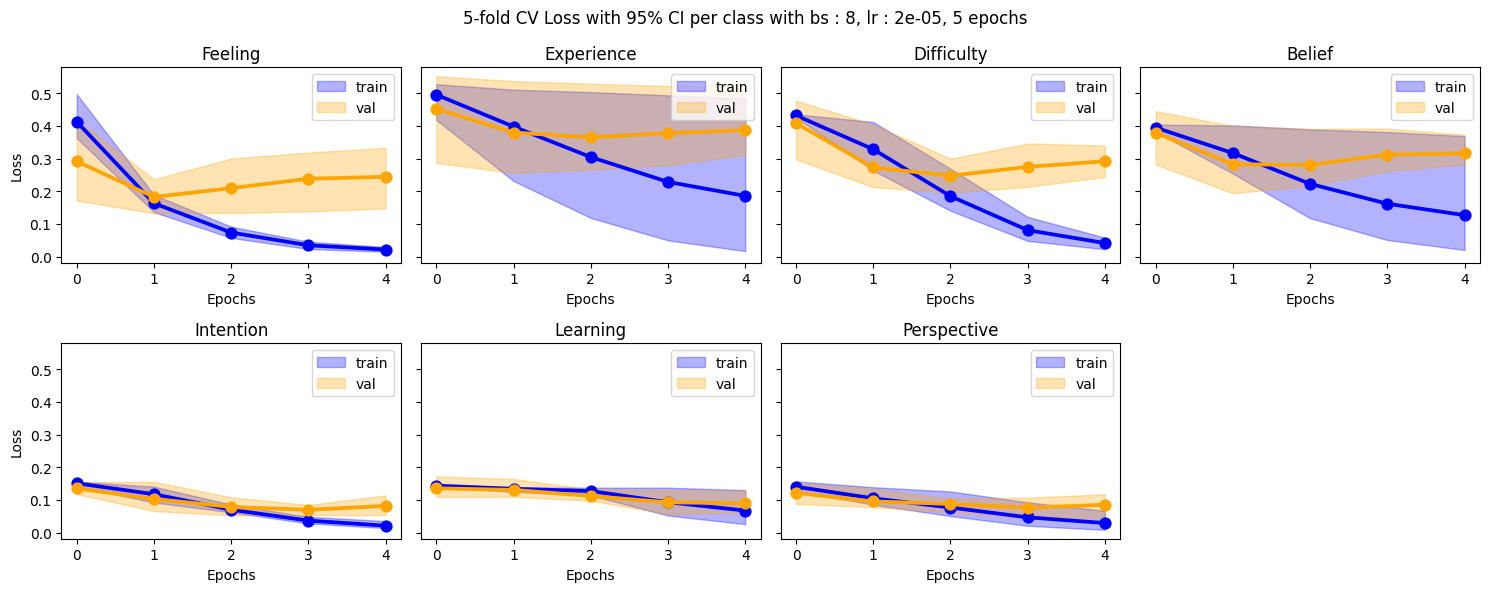

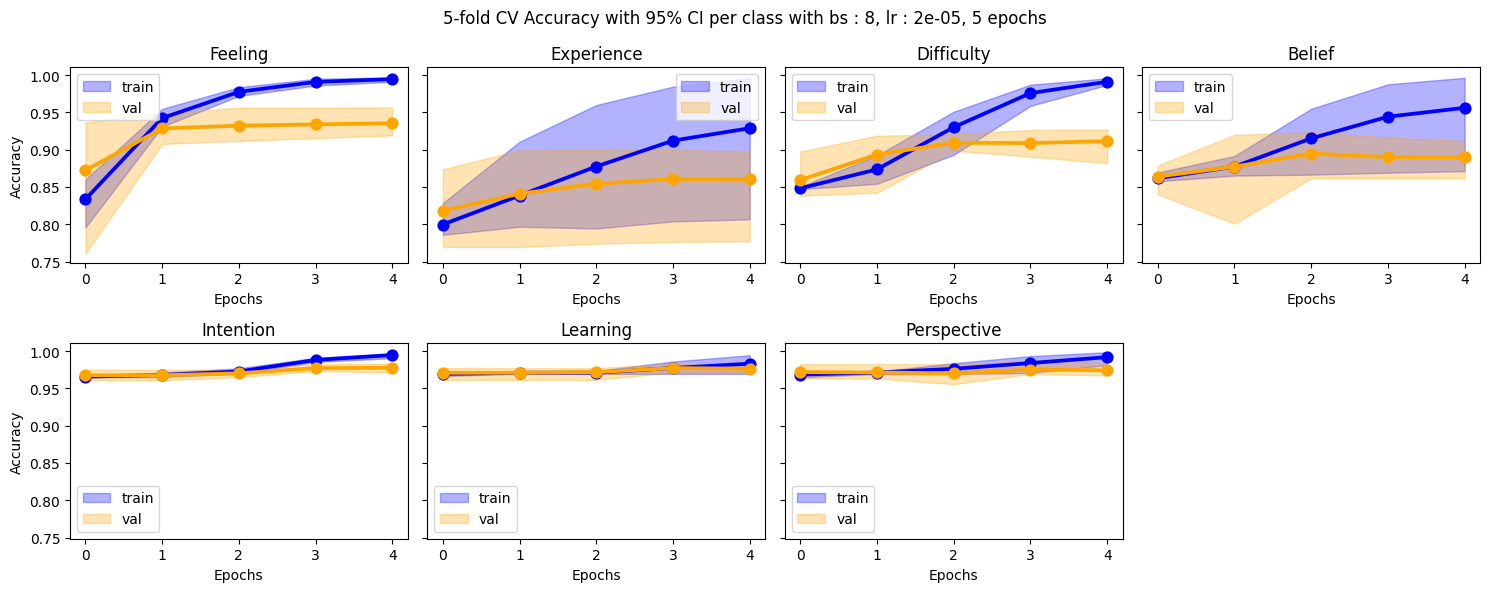

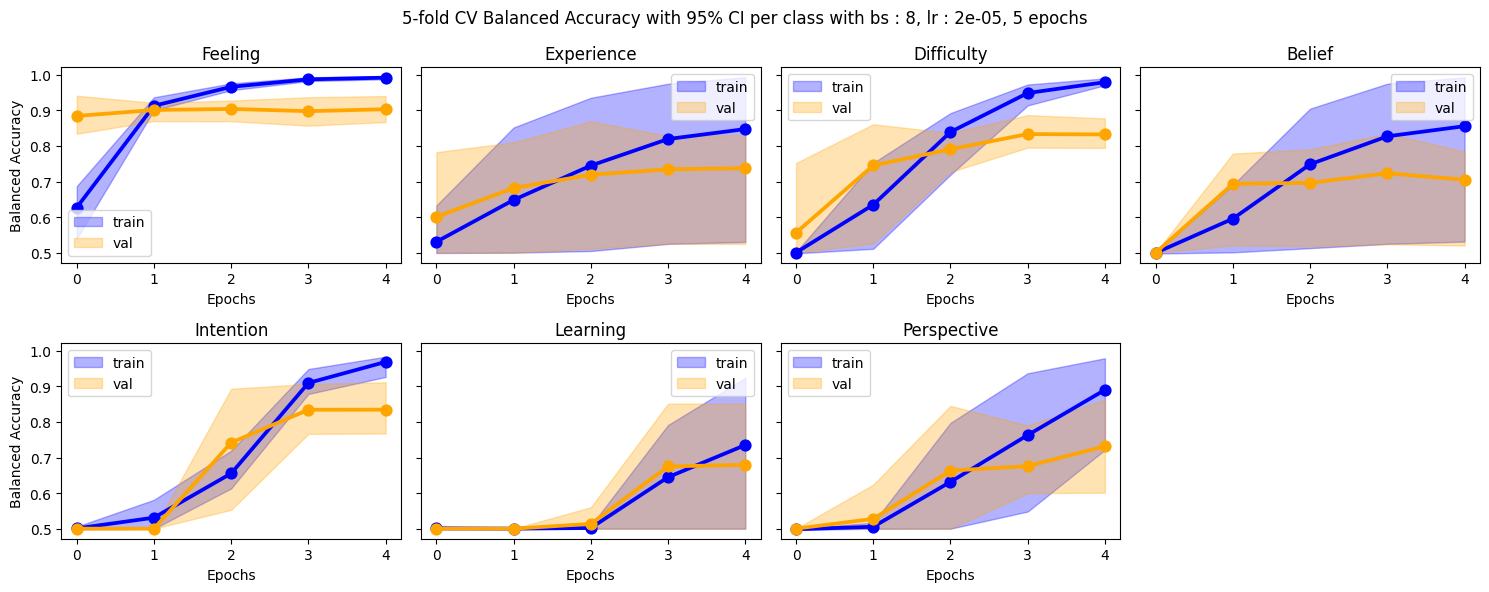

In [21]:
###### to copy ######
reflective_categories = ['Feeling', 'Experience', 'Difficulty', 'Belief', 'Intention', 'Learning', 'Perspective']
topN = 7
epochs = 5
epochs_eval = 3
n_splits = 5
batch_size = 8
learning_rate = 2e-05
cut_downsampling_train = 500
cut_downsampling_test = 100
#####################

fig, axs = plt.subplots(2, 4, figsize=(15, 6), sharey = True)  

# Sample iteration over the dictionary to plot subplots
for i, cat in enumerate(reflective_categories):
    df_train = dfs_train[cat]
    df_val = dfs_val[cat]
    ax = axs[i // 4, i % 4]
    
    # Mean lineplot
    sns.pointplot(data=df_train, x='Epochs', y='Mean_Train_Loss', color='blue', ax = ax)
    sns.pointplot(data=df_val, x='Epochs', y='Mean_Val_Loss', color='orange', ax = ax) 
    
    # Fill between the confidence interval
    ax.fill_between(df_train['Epochs'], df_train['Lower_CI'], df_train['Upper_CI'], color='blue', alpha=0.3, label = 'train')
    ax.fill_between(df_val['Epochs'], df_val['Lower_CI'], df_val['Upper_CI'], color='orange', alpha=0.3, label = 'val')
    
    #ax.set_xticks(np.arange(len(training_examples)), training_examples)
    ax.set_xlabel('Epochs')
    ax.set_ylabel("Loss")
    ax.set_title(f"{cat}") 
    ax.legend()
    
fig.delaxes(axs[1, 3])
plt.suptitle(f"{n_splits}-fold CV Loss with 95% CI per class with bs : {batch_size}, lr : {learning_rate}, {epochs} epochs") #, train_cut : {cut_downsampling_train}")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 4, figsize=(15, 6), sharey = True)  

# Sample iteration over the dictionary to plot subplots
for i, cat in enumerate(reflective_categories):
    df_train = dfs_train_acc[cat]
    df_acc = dfs_val_acc[cat]
    ax = axs[i // 4, i % 4]
    
    # Mean lineplot
    sns.pointplot(data=df_train, x='Epochs', y='Mean_Train_Acc', color='blue', ax = ax)
    sns.pointplot(data=df_acc, x='Epochs', y='Mean_Val_Acc', color='orange', ax = ax) 
    
    # Fill between the confidence interval
    ax.fill_between(df_train['Epochs'], df_train['Lower_CI'], df_train['Upper_CI'], color='blue', alpha=0.3, label = 'train')
    ax.fill_between(df_acc['Epochs'], df_acc['Lower_CI'], df_acc['Upper_CI'], color='orange', alpha=0.3, label = 'val')
    
    #ax.set_xticks(np.arange(len(training_examples)), training_examples)
    ax.set_xlabel('Epochs')
    ax.set_ylabel("Accuracy")
    ax.set_title(f"{cat}") 
    ax.legend()

fig.delaxes(axs[1, 3])
plt.suptitle(f"{n_splits}-fold CV Accuracy with 95% CI per class with bs : {batch_size}, lr : {learning_rate}, {epochs} epochs") #, train_cut : {cut_downsampling_train}")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 4, figsize=(15, 6), sharey = True)  

# Sample iteration over the dictionary to plot subplots
for i, cat in enumerate(reflective_categories):
    df_train = dfs_train_balanced_acc[cat]
    df_acc = dfs_val_balanced_acc[cat]
    ax = axs[i // 4, i % 4]
    
    # Mean lineplot
    sns.pointplot(data=df_train, x='Epochs', y='Mean_Train_Balanced_Acc', color='blue', ax = ax)
    sns.pointplot(data=df_acc, x='Epochs', y='Mean_Val_Balanced_Acc', color='orange', ax = ax) 
    
    # Fill between the confidence interval
    ax.fill_between(df_train['Epochs'], df_train['Lower_CI'], df_train['Upper_CI'], color='blue', alpha=0.3, label = 'train')
    ax.fill_between(df_acc['Epochs'], df_acc['Lower_CI'], df_acc['Upper_CI'], color='orange', alpha=0.3, label = 'val')
    
    #ax.set_xticks(np.arange(len(training_examples)), training_examples)
    ax.set_xlabel('Epochs')
    ax.set_ylabel("Balanced Accuracy")
    ax.set_title(f"{cat}") 
    ax.legend()

fig.delaxes(axs[1, 3])
plt.suptitle(f"{n_splits}-fold CV Balanced Accuracy with 95% CI per class with bs : {batch_size}, lr : {learning_rate}, {epochs} epochs") #, train_cut : {cut_downsampling_train}")
plt.tight_layout()
plt.show()

### Test dataset

In [28]:
accuracies_bin = [0.8931924882629108, 0.9436619718309859, 0.9530516431924883, 0.9307511737089202, 0.9776995305164319, 0.9753521126760564, 0.9812206572769953]
class_labels = [['Experience', 'Other'], ['Feeling', 'Other'], ['Difficulty', 'Other'], ['Belief', 'Other'], ['Intention', 'Other'], ['Learning', 'Other'], ['Other', 'Perspective']]

predicted_labels_experience = ['Other' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Experience' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other'
 'Experience' 'Experience' 'Other' 'Experience' 'Experience' 'Experience'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Experience' 'Other'
 'Other' 'Other' 'Experience' 'Other' 'Experience' 'Other' 'Experience'
 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience'
 'Experience' 'Other' 'Experience' 'Other' 'Other' 'Experience' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Other' 'Experience' 'Experience' 'Other' 'Other' 'Experience' 'Other'
 'Other' 'Experience' 'Experience' 'Experience' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Experience'
 'Experience' 'Experience' 'Other' 'Experience' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Other' 'Experience' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other'
 'Other' 'Other' 'Experience' 'Experience' 'Experience' 'Other' 'Other'
 'Experience' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Experience' 'Experience' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Experience'
 'Other' 'Other' 'Other' 'Experience' 'Experience' 'Other' 'Other' 'Other'
 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience'
 'Experience' 'Experience' 'Other' 'Experience' 'Experience' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Experience' 'Experience' 'Experience'
 'Experience' 'Experience' 'Other' 'Experience' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Experience' 'Other' 'Experience' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Experience' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Experience'
 'Other' 'Experience' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Experience'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Experience' 'Other' 'Experience' 'Other' 'Other' 'Experience' 'Other'
 'Other' 'Other' 'Experience' 'Other' 'Experience' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Experience' 'Experience' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Experience' 'Other' 'Experience' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Experience' 'Experience' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience'
 'Other' 'Experience' 'Experience' 'Other' 'Experience' 'Experience'
 'Experience' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Experience'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Experience' 'Experience' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Experience'
 'Other' 'Other' 'Experience' 'Other' 'Other' 'Experience' 'Other' 'Other'
 'Other' 'Experience' 'Experience' 'Experience' 'Other' 'Experience'
 'Other' 'Experience' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience'
 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience'
 'Other' 'Other' 'Experience' 'Experience' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience'
 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Experience' 'Other' 'Experience'
 'Experience' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Experience' 'Experience' 'Other' 'Other' 'Experience' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Experience' 'Other' 'Experience' 'Other' 'Experience' 'Other' 'Other'
 'Other' 'Experience' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other'
 'Other' 'Experience' 'Experience' 'Other' 'Other' 'Experience'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience'
 'Experience' 'Other' 'Other' 'Other' 'Experience' 'Experience'
 'Experience' 'Experience' 'Other' 'Experience' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Experience' 'Other' 'Experience' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Experience' 'Experience' 'Other' 'Other'
 'Experience' 'Experience' 'Experience' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other'
 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Experience' 'Other' 'Experience' 'Other' 'Experience' 'Other' 'Other'
 'Other' 'Other' 'Experience' 'Other' 'Experience' 'Experience' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Experience'
 'Other' 'Other' 'Other' 'Experience' 'Other' 'Experience' 'Experience'
 'Other' 'Other' 'Other' 'Experience' 'Experience' 'Other' 'Other' 'Other'
 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Experience' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Experience' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Experience'
 'Experience' 'Experience' 'Other' 'Experience' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience'
 'Other' 'Other' 'Other' 'Experience' 'Experience' 'Other' 'Experience'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Experience' 'Other'
 'Other' 'Experience' 'Other' 'Experience' 'Experience' 'Experience'
 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Experience' 'Experience' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other'
 'Other' 'Experience' 'Other' 'Experience' 'Other' 'Other' 'Experience'
 'Experience' 'Other' 'Other' 'Experience' 'Other' 'Experience' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Other' 'Other' 'Experience' 'Other' 'Experience' 'Other' 'Experience'
 'Other' 'Other' 'Other' 'Experience' 'Experience' 'Experience' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience'
 'Other' 'Other' 'Experience' 'Other' 'Experience' 'Experience' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Experience' 'Experience' 'Experience'
 'Other' 'Other' 'Experience' 'Experience' 'Other' 'Other' 'Other']


predicted_labels_feeling = ['Feeling' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other'
 'Other' 'Other' 'Feeling' 'Feeling' 'Other' 'Other' 'Feeling' 'Feeling'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Feeling' 'Other' 'Feeling' 'Feeling' 'Other' 'Other'
 'Other' 'Feeling' 'Other' 'Feeling' 'Other' 'Other' 'Feeling' 'Feeling'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Feeling'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Feeling' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Feeling' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Feeling'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Feeling' 'Feeling' 'Other' 'Feeling'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other'
 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Feeling'
 'Feeling' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other'
 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other'
 'Feeling' 'Other' 'Feeling' 'Other' 'Feeling' 'Feeling' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Feeling'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Feeling' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Feeling' 'Other'
 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Feeling' 'Other'
 'Other' 'Feeling' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Feeling'
 'Feeling' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Feeling'
 'Other' 'Feeling' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Feeling' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Feeling' 'Other' 'Feeling' 'Other' 'Other' 'Feeling' 'Other'
 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling'
 'Feeling' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Feeling' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Feeling'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Feeling'
 'Feeling' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Feeling'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Feeling' 'Other' 'Feeling' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other'
 'Feeling' 'Other' 'Feeling' 'Other' 'Feeling' 'Feeling' 'Other' 'Other'
 'Feeling' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Feeling' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Feeling' 'Feeling' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Feeling'
 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Feeling' 'Feeling' 'Feeling' 'Other' 'Other' 'Feeling'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Feeling' 'Other'
 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other'
 'Other' 'Feeling' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Feeling' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other'
 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling'
 'Other' 'Feeling' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Feeling' 'Other' 'Feeling' 'Other' 'Other' 'Feeling' 'Other'
 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other'
 'Feeling' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Feeling' 'Other' 'Other'
 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Feeling' 'Other' 'Feeling' 'Other' 'Other'
 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Feeling' 'Other' 'Feeling' 'Other' 'Other' 'Feeling' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling'
 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Feeling' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Feeling'
 'Feeling' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Feeling' 'Other'
 'Other' 'Other' 'Feeling' 'Other' 'Feeling' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Feeling' 'Other' 'Other'
 'Feeling' 'Other' 'Feeling']


predicted_labels_difficulty = ['Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Difficulty'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Difficulty' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Difficulty' 'Difficulty' 'Difficulty' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Difficulty' 'Other' 'Other' 'Difficulty' 'Difficulty' 'Other' 'Other'
 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Difficulty' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Difficulty'
 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Difficulty' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Difficulty' 'Difficulty'
 'Other' 'Difficulty' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Difficulty' 'Difficulty' 'Difficulty' 'Other' 'Other'
 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Difficulty' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other'
 'Other' 'Other' 'Difficulty' 'Difficulty' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Difficulty'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Difficulty'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other'
 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Difficulty' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other'
 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other'
 'Other' 'Difficulty' 'Other' 'Difficulty' 'Other' 'Other' 'Other'
 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Difficulty' 'Other'
 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Difficulty'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other']


predicted_labels_belief = ['Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Belief' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Belief' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Belief' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Belief' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other']


predicted_labels_intention = ['Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other']


predicted_labels_learning = ['Learning' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Learning' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Learning' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Learning' 'Other' 'Learning' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Learning' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Learning' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Learning' 'Other' 'Learning' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Learning' 'Other' 'Other' 'Other' 'Other' 'Learning' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Learning' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Learning'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Learning'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Learning' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Learning' 'Learning' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Learning' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Learning' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Learning' 'Other' 'Other' 'Other'
 'Learning' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Learning' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Learning' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Learning' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Learning' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Learning' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other']


predicted_labels_perspective = ['Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other']


true_labels_experience = ['Other' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Experience' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other'
 'Experience' 'Experience' 'Other' 'Experience' 'Other' 'Experience'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience'
 'Other' 'Other' 'Other' 'Experience' 'Other' 'Experience' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience'
 'Experience' 'Other' 'Experience' 'Other' 'Other' 'Experience' 'Other'
 'Experience' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Experience' 'Other' 'Other' 'Experience' 'Other' 'Other'
 'Experience' 'Experience' 'Experience' 'Other' 'Other' 'Experience'
 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Experience' 'Other'
 'Other' 'Other' 'Experience' 'Other' 'Experience' 'Experience'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Experience'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Experience' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Experience' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other'
 'Other' 'Experience' 'Experience' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Experience'
 'Experience' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Experience' 'Experience' 'Experience' 'Experience' 'Other'
 'Other' 'Experience' 'Other' 'Other' 'Experience' 'Experience' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Experience'
 'Other' 'Experience' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Experience' 'Other' 'Other' 'Experience' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Experience' 'Experience' 'Experience' 'Other' 'Experience'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Experience' 'Other' 'Experience' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Experience' 'Experience' 'Other' 'Other'
 'Other' 'Experience' 'Other' 'Other' 'Experience' 'Other' 'Experience'
 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Experience'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Other' 'Experience' 'Other' 'Other' 'Experience' 'Other' 'Experience'
 'Experience' 'Experience' 'Experience' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Experience'
 'Experience' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Experience'
 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Experience' 'Other'
 'Other' 'Other' 'Experience' 'Other' 'Other' 'Experience' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Experience' 'Experience' 'Other'
 'Other' 'Experience' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Experience' 'Other' 'Experience' 'Other'
 'Experience' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Experience' 'Other' 'Experience' 'Other' 'Experience'
 'Experience' 'Other' 'Experience' 'Other' 'Other' 'Experience' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Experience'
 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Experience' 'Experience' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other'
 'Other' 'Experience' 'Other' 'Experience' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other'
 'Other' 'Experience' 'Other' 'Other' 'Experience' 'Experience' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Other' 'Other' 'Other' 'Experience' 'Experience' 'Experience' 'Other'
 'Other' 'Other' 'Experience' 'Experience' 'Experience' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience'
 'Other' 'Experience' 'Experience' 'Other' 'Experience' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience'
 'Experience' 'Other' 'Other' 'Experience' 'Other' 'Experience' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Experience'
 'Other' 'Other' 'Experience' 'Experience' 'Other' 'Other' 'Experience'
 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Experience' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Experience' 'Other' 'Experience' 'Experience'
 'Experience' 'Other' 'Experience' 'Experience' 'Other' 'Other' 'Other'
 'Other' 'Experience' 'Experience' 'Other' 'Experience' 'Other'
 'Experience' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Experience'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Experience'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Experience'
 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Experience' 'Experience' 'Experience'
 'Experience' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Experience' 'Experience' 'Other' 'Other'
 'Experience' 'Other' 'Experience' 'Experience' 'Experience' 'Other'
 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Other' 'Experience'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Experience' 'Experience' 'Other'
 'Other' 'Other' 'Experience' 'Other' 'Experience' 'Other' 'Other'
 'Experience' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Experience'
 'Other' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Experience'
 'Experience' 'Other' 'Other' 'Other' 'Experience' 'Other' 'Experience'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Experience' 'Experience'
 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Experience' 'Experience' 'Other' 'Other'
 'Other' 'Other' 'Experience' 'Experience' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Experience' 'Other' 'Other' 'Experience' 'Other'
 'Experience' 'Experience' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Experience' 'Experience' 'Other' 'Other' 'Other' 'Experience'
 'Experience' 'Other' 'Other' 'Other']


true_labels_feeling = ['Feeling' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other'
 'Other' 'Feeling' 'Other' 'Feeling' 'Feeling' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Feeling' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Feeling' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other'
 'Feeling' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Feeling' 'Feeling' 'Other' 'Feeling' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Feeling' 'Feeling'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other'
 'Other' 'Other' 'Feeling' 'Feeling' 'Other' 'Feeling' 'Feeling' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Feeling' 'Feeling'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Feeling' 'Feeling' 'Feeling'
 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Feeling'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling'
 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Feeling' 'Other'
 'Feeling' 'Other' 'Feeling' 'Feeling' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Feeling' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Feeling' 'Feeling' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Feeling'
 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Feeling' 'Other' 'Feeling' 'Other' 'Other' 'Feeling'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Feeling' 'Other' 'Feeling' 'Feeling' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Feeling' 'Other' 'Feeling' 'Feeling' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Feeling' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other'
 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Feeling' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other'
 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Feeling' 'Other'
 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Feeling' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Feeling'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Feeling' 'Other'
 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Feeling'
 'Other' 'Other' 'Feeling' 'Other' 'Feeling' 'Other' 'Feeling' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Feeling' 'Feeling'
 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Feeling' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Feeling'
 'Feeling' 'Other' 'Other' 'Feeling' 'Feeling' 'Other' 'Other' 'Feeling'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other'
 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Feeling' 'Other' 'Feeling' 'Other' 'Feeling' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Feeling' 'Feeling'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other'
 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Feeling' 'Feeling' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Feeling' 'Other' 'Other'
 'Feeling' 'Feeling' 'Other' 'Feeling' 'Feeling' 'Other' 'Other' 'Feeling'
 'Other' 'Other' 'Feeling' 'Other' 'Feeling' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other'
 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Feeling' 'Other' 'Feeling' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other'
 'Other' 'Feeling' 'Other' 'Feeling' 'Other' 'Other' 'Feeling' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling'
 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Feeling' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other'
 'Other' 'Other' 'Other' 'Feeling' 'Feeling' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Feeling' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Feeling'
 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other'
 'Other' 'Other' 'Feeling' 'Feeling' 'Other' 'Other' 'Other' 'Feeling'
 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other'
 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Feeling' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Feeling' 'Other' 'Other' 'Feeling' 'Other' 'Feeling']


true_labels_difficulty = ['Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Difficulty'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Difficulty' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Difficulty' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Difficulty'
 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Difficulty'
 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Difficulty'
 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Difficulty' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other'
 'Difficulty' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Difficulty'
 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Difficulty' 'Other'
 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Difficulty'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Difficulty' 'Difficulty' 'Other' 'Other' 'Difficulty' 'Other'
 'Difficulty' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other'
 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Difficulty'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Difficulty'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Difficulty'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other'
 'Other' 'Difficulty' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Difficulty' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Difficulty'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Difficulty'
 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other'
 'Other' 'Difficulty' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other'
 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Difficulty'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other'
 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Difficulty'
 'Other' 'Other' 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Difficulty' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other']


true_labels_belief = ['Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Belief' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Belief' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Belief' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Belief' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Belief'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Belief' 'Other' 'Other' 'Other' 'Other' 'Belief'
 'Other' 'Other' 'Other' 'Other' 'Belief' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Belief' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Belief' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Belief' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Belief' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Belief' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Belief' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Belief' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Belief' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Belief'
 'Other' 'Other' 'Belief' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Belief' 'Other' 'Other' 'Belief' 'Other' 'Other'
 'Belief' 'Other' 'Other' 'Other' 'Other' 'Belief' 'Other' 'Belief'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Belief' 'Other' 'Other' 'Other' 'Other' 'Other' 'Belief' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Belief' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Belief' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Belief' 'Other' 'Other' 'Other' 'Other' 'Belief' 'Belief' 'Other'
 'Other' 'Other' 'Other' 'Belief' 'Other' 'Other' 'Belief' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Belief' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Belief' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Belief' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Belief' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Belief' 'Belief'
 'Belief' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Belief' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Belief' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Belief' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Belief' 'Other' 'Belief' 'Other' 'Belief' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Belief' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Belief' 'Other' 'Other' 'Other' 'Other'
 'Belief' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Belief' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Belief' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Belief' 'Belief' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Belief' 'Other' 'Other'
 'Belief' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Belief' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Belief' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Belief' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other']


true_labels_intention = ['Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Intention' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Intention' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Intention' 'Other' 'Other' 'Other' 'Intention' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Intention' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Intention' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Intention' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Intention'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Intention'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Intention' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Intention' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Intention' 'Other' 'Other' 'Other'
 'Intention' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Intention' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Intention' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Intention' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Intention' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Intention' 'Other' 'Other' 'Intention' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other']


true_labels_learning = ['Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Learning' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Learning' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Learning' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Learning' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Learning' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Learning' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Learning'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Learning' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Learning' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Learning' 'Learning' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Learning' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Learning' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other']


true_labels_perspective = ['Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Perspective' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Perspective' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Perspective' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Perspective' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Perspective' 'Other' 'Other'
 'Perspective' 'Other' 'Other' 'Perspective' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Perspective' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Perspective' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Perspective' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Perspective' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Perspective' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Perspective' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Perspective' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Perspective' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other' 'Perspective' 'Other' 'Other' 'Other'
 'Other' 'Other' 'Other' 'Other']


pred_confidence_experience = [0.9993131, 0.9987973, 0.9983954, 0.9946055, 0.99166554, 0.9986803, 0.99707365, 0.99864215, 0.99901927, 0.99313146, 0.9982205, 0.999097, 0.8733911, 0.98741317, 0.99917173, 0.9903257, 0.9900045, 0.99675685, 0.9990011, 0.89518225, 0.9913918, 0.9229013, 0.9969819, 0.9895829, 0.9988532, 0.9992588, 0.99436766, 0.99927586, 0.9122996, 0.9991165, 0.9940818, 0.999146, 0.9496691, 0.9991604, 0.99930537, 0.9977773, 0.9989963, 0.99622077, 0.72717017, 0.9991825, 0.9991524, 0.9991817, 0.8863356, 0.99920243, 0.99379647, 0.9526831, 0.9239944, 0.9981346, 0.99885297, 0.79844075, 0.9896119, 0.9941565, 0.9985454, 0.5370327, 0.99917006, 0.9969228, 0.92566675, 0.99916935, 0.9970475, 0.99862754, 0.9988482, 0.99312955, 0.9902242, 0.99922264, 0.6552277, 0.77434546, 0.9992487, 0.9946438, 0.9991755, 0.69316417, 0.99926513, 0.99932635, 0.86817545, 0.87314713, 0.9917298, 0.92499506, 0.99784136, 0.99909854, 0.9403839, 0.97327787, 0.9992513, 0.6814413, 0.99354774, 0.9985045, 0.9990263, 0.9979797, 0.9813965, 0.690316, 0.99791354, 0.99919504, 0.99253803, 0.9985323, 0.9957337, 0.99536276, 0.9280331, 0.99874425, 0.98832345, 0.9955177, 0.9988954, 0.99912745, 0.99881554, 0.992645, 0.99563956, 0.99382716, 0.9936056, 0.9963218, 0.99792993, 0.9956326, 0.9992367, 0.9270237, 0.9990206, 0.98493457, 0.9991541, 0.99934834, 0.99760723, 0.9987998, 0.9991616, 0.9971723, 0.991886, 0.99837214, 0.9695817, 0.9856214, 0.99931633, 0.9870744, 0.9295595, 0.99924254, 0.98895746, 0.9978683, 0.99910384, 0.99139434, 0.8188033, 0.7607214, 0.9986076, 0.99895763, 0.9914268, 0.9954454, 0.6748413, 0.9988961, 0.9957378, 0.9873974, 0.99900454, 0.9988036, 0.9990127, 0.9921599, 0.9960835, 0.9944891, 0.99865687, 0.99920887, 0.99903226, 0.9201695, 0.99914527, 0.99682295, 0.97289556, 0.99477756, 0.999054, 0.9970124, 0.996897, 0.9972964, 0.99764377, 0.8798364, 0.9151639, 0.98624206, 0.9973279, 0.9987185, 0.99915755, 0.998922, 0.99908483, 0.87759745, 0.99921155, 0.99664766, 0.9989222, 0.9993279, 0.6170822, 0.9477029, 0.8055498, 0.99558663, 0.99733645, 0.99097997, 0.9990069, 0.99631655, 0.99894387, 0.99936587, 0.9970284, 0.99592954, 0.99923825, 0.9983637, 0.9771021, 0.9951265, 0.9990299, 0.995312, 0.99752766, 0.9958027, 0.9919075, 0.932909, 0.9968857, 0.77941114, 0.988868, 0.9976355, 0.9988476, 0.6657971, 0.94825864, 0.6589221, 0.9693778, 0.9966086, 0.56960535, 0.9989826, 0.94754446, 0.57617104, 0.99359375, 0.99079436, 0.99815065, 0.9978371, 0.99441963, 0.99924195, 0.5004964, 0.62920713, 0.9941837, 0.99897766, 0.65056413, 0.99916923, 0.99373466, 0.99903226, 0.9843536, 0.87322515, 0.9980252, 0.9992692, 0.998259, 0.9990687, 0.9991767, 0.99842143, 0.9992963, 0.99918944, 0.99903935, 0.99791485, 0.99898726, 0.99475056, 0.9991916, 0.99695694, 0.71410096, 0.9359508, 0.9989849, 0.9988606, 0.87209207, 0.85865283, 0.999132, 0.7062948, 0.9969573, 0.9974597, 0.9440696, 0.5047407, 0.99671626, 0.9940574, 0.97630715, 0.82584506, 0.9901164, 0.9973922, 0.99913555, 0.99917847, 0.9755427, 0.99732864, 0.9974388, 0.99909484, 0.996938, 0.99893814, 0.9992919, 0.93731225, 0.9989002, 0.99916613, 0.9989666, 0.79436225, 0.5852433, 0.8338369, 0.99900657, 0.9759386, 0.9984332, 0.9991603, 0.9961223, 0.876449, 0.9965404, 0.9903556, 0.9973519, 0.68278474, 0.92969704, 0.9411657, 0.9992812, 0.618407, 0.96609795, 0.994056, 0.99924845, 0.9972904, 0.9981343, 0.9779093, 0.9651028, 0.87727296, 0.9950641, 0.9820238, 0.9974776, 0.99812835, 0.99373066, 0.9937046, 0.9993105, 0.7126764, 0.99926764, 0.9935436, 0.98686755, 0.9991991, 0.99626726, 0.9970565, 0.99896085, 0.86245877, 0.9973097, 0.99792516, 0.75613856, 0.99623245, 0.99640536, 0.9978338, 0.99906844, 0.9972915, 0.9960567, 0.995479, 0.9971277, 0.9555644, 0.9570912, 0.9992932, 0.99918586, 0.9949244, 0.7264645, 0.99919564, 0.8993915, 0.73197275, 0.99768746, 0.9302002, 0.9978417, 0.99603075, 0.9992409, 0.9984938, 0.9993973, 0.8076175, 0.90798527, 0.9987245, 0.99877506, 0.9992699, 0.99905175, 0.9987282, 0.9979114, 0.9967693, 0.9984528, 0.99113375, 0.994989, 0.9948089, 0.99709725, 0.99937063, 0.59008753, 0.9985556, 0.9988403, 0.9969426, 0.9517165, 0.9991394, 0.99817467, 0.6424825, 0.9954182, 0.9987833, 0.9954318, 0.9981957, 0.99193066, 0.9991013, 0.9952366, 0.99744886, 0.99571, 0.9481844, 0.99185693, 0.5255964, 0.997141, 0.99911743, 0.99900085, 0.99822694, 0.8634121, 0.6919131, 0.52111715, 0.99931026, 0.98935205, 0.99927133, 0.9958062, 0.99926347, 0.98919654, 0.99287933, 0.999041, 0.9990601, 0.99580115, 0.9915838, 0.85971004, 0.99650794, 0.99771285, 0.99791735, 0.9863543, 0.7432201, 0.99926025, 0.7780831, 0.9975515, 0.9970277, 0.8462785, 0.9640203, 0.9959953, 0.9989229, 0.9990963, 0.9991418, 0.9946635, 0.9886797, 0.85734373, 0.99057895, 0.74505216, 0.99892336, 0.99792105, 0.9988624, 0.99504673, 0.9979284, 0.99763477, 0.99937755, 0.98860776, 0.9853603, 0.5297086, 0.9990834, 0.98341274, 0.79866844, 0.99914515, 0.81167126, 0.9992244, 0.99539196, 0.9992231, 0.9991597, 0.86703414, 0.9992543, 0.996789, 0.99918765, 0.9990244, 0.99696726, 0.9728934, 0.99936575, 0.99931, 0.9696265, 0.93787706, 0.9961725, 0.83653283, 0.99892706, 0.99914837, 0.9721201, 0.9990325, 0.99686676, 0.99908733, 0.808121, 0.9992487, 0.9990395, 0.9962053, 0.9991103, 0.9977315, 0.9560633, 0.9982936, 0.9688371, 0.99568594, 0.98991007, 0.9966552, 0.9913974, 0.99406415, 0.99798065, 0.99420315, 0.9516868, 0.9964747, 0.99911016, 0.74772435, 0.99710697, 0.97299373, 0.9990414, 0.9928676, 0.9980064, 0.999268, 0.98543084, 0.9965125, 0.99699545, 0.9988839, 0.9813085, 0.9990502, 0.9904338, 0.98580754, 0.9983839, 0.99542385, 0.99560404, 0.9992428, 0.99908006, 0.9990338, 0.99539006, 0.9981281, 0.9993119, 0.9990546, 0.73060554, 0.99506396, 0.997465, 0.9967501, 0.99179614, 0.99598676, 0.9911726, 0.99458015, 0.99902153, 0.9988543, 0.84161675, 0.9542696, 0.89316666, 0.99580127, 0.9989436, 0.99857223, 0.85801977, 0.99837154, 0.6203785, 0.9981311, 0.9965287, 0.996372, 0.9992849, 0.9958831, 0.99762434, 0.7929523, 0.99204004, 0.98036057, 0.999212, 0.9633067, 0.99891293, 0.9992311, 0.9971807, 0.97859645, 0.99929667, 0.99905735, 0.9941849, 0.9988028, 0.99702865, 0.9268282, 0.9992687, 0.99269706, 0.9989041, 0.99849164, 0.9929189, 0.9976782, 0.94933015, 0.998862, 0.99886644, 0.9434543, 0.7200747, 0.99557024, 0.87751275, 0.9961118, 0.50956315, 0.9955329, 0.88596267, 0.9916351, 0.9367076, 0.9990287, 0.99884135, 0.9981457, 0.9807992, 0.99791914, 0.9988902, 0.9991666, 0.922085, 0.88751894, 0.89793175, 0.9990964, 0.9909406, 0.9993493, 0.997718, 0.9849162, 0.99901414, 0.99467695, 0.9969593, 0.7751909, 0.92094076, 0.9990336, 0.94392216, 0.9988457, 0.9704906, 0.996018, 0.9991053, 0.99920017, 0.86966395, 0.9817965, 0.9983045, 0.9967982, 0.998086, 0.9936805, 0.9935579, 0.9987196, 0.9431373, 0.9707681, 0.99818087, 0.99613744, 0.99070543, 0.99282223, 0.99875987, 0.995086, 0.94240016, 0.99511296, 0.6780578, 0.89383304, 0.9563862, 0.98332894, 0.9990753, 0.99918157, 0.91048807, 0.9936765, 0.94128174, 0.995404, 0.97221315, 0.99909985, 0.8806093, 0.52323693, 0.999143, 0.9990262, 0.9985031, 0.998601, 0.9959584, 0.7637324, 0.99688417, 0.99927205, 0.9989491, 0.99934024, 0.6265862, 0.6193746, 0.9990978, 0.9844667, 0.9938399, 0.99927944, 0.9985281, 0.9938619, 0.99421436, 0.99903226, 0.96840423, 0.99728715, 0.99918896, 0.9961675, 0.98134226, 0.99448663, 0.9969119, 0.9980697, 0.9701521, 0.9974355, 0.9981805, 0.9976271, 0.9992305, 0.9993661, 0.99855036, 0.9990748, 0.9973435, 0.99486345, 0.9984321, 0.9983985, 0.9989122, 0.5341656, 0.62509084, 0.9986298, 0.88746166, 0.9740569, 0.99854374, 0.99896204, 0.7544058, 0.99588364, 0.993075, 0.9947142, 0.9832691, 0.9983584, 0.53120357, 0.9990951, 0.99871755, 0.99792695, 0.9989716, 0.65035236, 0.99896884, 0.9493119, 0.99775785, 0.99540615, 0.99915886, 0.999241, 0.99583167, 0.9581904, 0.88734806, 0.9992617, 0.94992983, 0.9967435, 0.98916924, 0.9989936, 0.99660933, 0.9992945, 0.9791788, 0.9981316, 0.999326, 0.9989297, 0.9988674, 0.8099918, 0.96306235, 0.9947411, 0.7576627, 0.9956209, 0.9947076, 0.99909055, 0.881862, 0.9962224, 0.99817204, 0.99719703, 0.9990195, 0.99920964, 0.991231, 0.9925256, 0.99906605, 0.99891317, 0.99704784, 0.9942041, 0.8025783, 0.7472714, 0.9950028, 0.50957364, 0.99532735, 0.97201276, 0.99921596, 0.9830536, 0.9990263, 0.75483865, 0.99929917, 0.9923111, 0.7977713, 0.9992393, 0.96977973, 0.996514, 0.9972531, 0.9989485, 0.96680695, 0.95352167, 0.9989236, 0.9901635, 0.9970669, 0.9992137, 0.9894819, 0.99925166, 0.9130368, 0.9962986, 0.9864389, 0.9991673, 0.9991709, 0.94028103, 0.7812706, 0.9865458, 0.9985145, 0.999047, 0.99758196, 0.97689646, 0.9972422, 0.8097839, 0.99926645, 0.9931115, 0.6868606, 0.99900097, 0.99488634, 0.6591289, 0.9991672, 0.9982816, 0.9911522, 0.9968353, 0.99481404, 0.99700063, 0.9989849, 0.99610436, 0.9991523, 0.9921686, 0.99389994, 0.98608065, 0.9992311, 0.9990214, 0.9965917, 0.90770024, 0.7125808, 0.9991604, 0.99161434, 0.71882796, 0.80531335, 0.9919378, 0.98568, 0.99623704, 0.9590202, 0.9950423, 0.99869007, 0.5694834, 0.99925286, 0.96815276, 0.8657748, 0.9990503, 0.64060277, 0.91585577, 0.99751914, 0.9920655, 0.9985832, 0.9953555, 0.9984268, 0.9946903, 0.99888605, 0.83250546, 0.9992341, 0.99907196, 0.99651957, 0.9626133, 0.99768496, 0.9855714, 0.82099724, 0.99884087, 0.9977329, 0.9765255, 0.9958794, 0.9985562, 0.99889636, 0.99931574, 0.998857, 0.99813336, 0.9983885, 0.97302306, 0.9615903, 0.9980862, 0.9885898, 0.99470997, 0.9983374, 0.92363495, 0.9955449, 0.990768, 0.9979225, 0.9992792, 0.99900776, 0.998211, 0.9654579, 0.996488, 0.99925035, 0.9982535, 0.9977202, 0.9988298, 0.98157644, 0.9865023, 0.9992975, 0.99775934, 0.99937195, 0.99916255, 0.96980435, 0.9755434, 0.997106, 0.83870715, 0.9987919, 0.9992015, 0.996953, 0.9953133, 0.9993523, 0.9979359, 0.99905056]


pred_confidence_feeling = [0.9922126, 0.99142414, 0.99957794, 0.9997073, 0.9997439, 0.97499985, 0.9996507, 0.999228, 0.998749, 0.99969697, 0.8844394, 0.9787658, 0.99671614, 0.999668, 0.9942714, 0.5308785, 0.9979976, 0.99974114, 0.99919754, 0.9995907, 0.9997104, 0.99961925, 0.99972826, 0.9956416, 0.9995453, 0.9749917, 0.99964404, 0.9897662, 0.99917054, 0.9930676, 0.9834425, 0.9996375, 0.98621273, 0.99757177, 0.7627526, 0.99974746, 0.9932833, 0.9997389, 0.99951625, 0.98149776, 0.99369156, 0.69582134, 0.9997199, 0.9997036, 0.9992378, 0.99965394, 0.9997019, 0.99971443, 0.99962044, 0.9995722, 0.99965215, 0.9532246, 0.99968433, 0.9997377, 0.98743826, 0.9996629, 0.9997335, 0.9917317, 0.9994117, 0.99971694, 0.999705, 0.9997116, 0.99968517, 0.78942424, 0.99973065, 0.9705805, 0.99895084, 0.9995239, 0.99396414, 0.99835324, 0.99395317, 0.9866556, 0.99882, 0.96581674, 0.9996598, 0.9996624, 0.99960357, 0.9947015, 0.54691106, 0.98421717, 0.99231917, 0.9974196, 0.9997323, 0.9997197, 0.9993748, 0.99968004, 0.99973434, 0.9996675, 0.99972314, 0.9996419, 0.999723, 0.9983576, 0.99969614, 0.9996675, 0.99965763, 0.99971145, 0.6709024, 0.9996346, 0.71336645, 0.98788935, 0.9905037, 0.99969566, 0.999616, 0.9996989, 0.9996935, 0.99973804, 0.99903893, 0.999671, 0.99313897, 0.9996649, 0.9994437, 0.9942211, 0.994773, 0.9910494, 0.99971324, 0.99532783, 0.9949214, 0.9996979, 0.9960758, 0.9996132, 0.9996201, 0.9996164, 0.99144226, 0.99919933, 0.9992969, 0.9908805, 0.9995877, 0.99966204, 0.99953437, 0.8541303, 0.9989064, 0.99970514, 0.9995222, 0.99949, 0.99969673, 0.95561975, 0.9971944, 0.9996679, 0.9844023, 0.9980205, 0.9848512, 0.9933888, 0.99345905, 0.99969554, 0.9997327, 0.99974114, 0.9994174, 0.9928368, 0.99964213, 0.9994772, 0.9860891, 0.99940693, 0.9996557, 0.9997167, 0.9994124, 0.9995665, 0.9996544, 0.9996704, 0.9995084, 0.99817705, 0.99966717, 0.9997243, 0.9997279, 0.9997147, 0.9892342, 0.9997002, 0.98513156, 0.99963224, 0.995308, 0.99963224, 0.99081516, 0.68296844, 0.9997434, 0.95348096, 0.9964799, 0.99967134, 0.9997478, 0.9996549, 0.98988533, 0.99965334, 0.9982185, 0.9939791, 0.99949443, 0.99959844, 0.99822336, 0.9995185, 0.9997116, 0.9837986, 0.9889346, 0.99862945, 0.9997048, 0.9997235, 0.99967587, 0.9997193, 0.99844354, 0.9996526, 0.99968684, 0.998892, 0.99053776, 0.99973136, 0.99886525, 0.9994431, 0.9996208, 0.9996816, 0.99962664, 0.9972435, 0.9995192, 0.9997216, 0.99970835, 0.9996879, 0.999519, 0.9997271, 0.99970657, 0.99310255, 0.9802004, 0.9994648, 0.99973077, 0.98803574, 0.9992163, 0.69724953, 0.9997162, 0.9995065, 0.9997042, 0.9972567, 0.9995968, 0.99971074, 0.9996909, 0.9935393, 0.9995515, 0.8094579, 0.9995345, 0.9936761, 0.9987348, 0.99953055, 0.9935033, 0.99961984, 0.9926595, 0.99966335, 0.9996543, 0.99957484, 0.9995433, 0.98532087, 0.9987424, 0.99968576, 0.9994497, 0.9996766, 0.9867105, 0.991746, 0.9997203, 0.99909365, 0.9994789, 0.9996704, 0.99970144, 0.9996666, 0.99385697, 0.9996455, 0.9948066, 0.9953094, 0.99943894, 0.99967027, 0.99973375, 0.9944794, 0.99968064, 0.86058533, 0.99236757, 0.99971837, 0.6542282, 0.98927665, 0.9992306, 0.99972326, 0.9997125, 0.9997063, 0.99970883, 0.7235799, 0.98845077, 0.54388475, 0.9994437, 0.99965715, 0.99970645, 0.9997265, 0.99966717, 0.9997321, 0.7486398, 0.9991786, 0.9996873, 0.99971205, 0.9997241, 0.99972147, 0.98751265, 0.99972373, 0.99624205, 0.9996208, 0.62493885, 0.9985869, 0.99965286, 0.99972814, 0.9997228, 0.9995772, 0.99970835, 0.9997087, 0.98741406, 0.9996474, 0.99253345, 0.996172, 0.9995901, 0.9901018, 0.9996507, 0.9997218, 0.6305295, 0.99947053, 0.9997292, 0.9996953, 0.9996973, 0.99970824, 0.9997098, 0.9997321, 0.6740035, 0.999747, 0.99742955, 0.99970895, 0.99971336, 0.9888409, 0.9996722, 0.88752633, 0.9909279, 0.99970055, 0.9765911, 0.99933064, 0.63175297, 0.9996648, 0.9996327, 0.99968684, 0.9996227, 0.99972385, 0.7225111, 0.79848963, 0.9685392, 0.99955255, 0.9996371, 0.9991454, 0.99943227, 0.5072342, 0.94300455, 0.9992939, 0.99973756, 0.9996879, 0.9997316, 0.99139977, 0.9994537, 0.99971086, 0.9244614, 0.9936354, 0.9996878, 0.99969804, 0.93619746, 0.99939966, 0.9996954, 0.97920704, 0.9997098, 0.99964416, 0.99953747, 0.9996232, 0.9997273, 0.9996244, 0.9996954, 0.9896543, 0.9997273, 0.9996861, 0.9996997, 0.99915135, 0.99969196, 0.9993337, 0.9995128, 0.99308795, 0.98666847, 0.99068075, 0.9617656, 0.9996785, 0.9995839, 0.9707436, 0.68844086, 0.9995484, 0.9996352, 0.9997017, 0.99963903, 0.999642, 0.99326295, 0.9995389, 0.99971837, 0.9997454, 0.9969193, 0.99957114, 0.99964523, 0.9994703, 0.99050504, 0.9995703, 0.9989555, 0.9988034, 0.9996654, 0.9507126, 0.9997191, 0.99966204, 0.9995252, 0.99521893, 0.99942327, 0.99113584, 0.9993136, 0.9996105, 0.9996784, 0.99954045, 0.9996264, 0.9932595, 0.9997212, 0.9871731, 0.99971133, 0.9997069, 0.9996642, 0.95320195, 0.9997291, 0.9997068, 0.9996598, 0.9996439, 0.99969864, 0.9991265, 0.9990939, 0.9992968, 0.9945351, 0.9996686, 0.9996151, 0.99960536, 0.9997004, 0.9917567, 0.9990089, 0.99917054, 0.9922924, 0.9997348, 0.9131107, 0.9460169, 0.98112637, 0.58085936, 0.5847735, 0.9996562, 0.71093273, 0.99963355, 0.94080967, 0.9984693, 0.99937767, 0.9995571, 0.97716117, 0.9996902, 0.73668015, 0.999551, 0.9994319, 0.9997125, 0.9996854, 0.99959856, 0.999539, 0.9996761, 0.99808455, 0.9997266, 0.9996909, 0.9619932, 0.9796578, 0.99251586, 0.99971527, 0.9997222, 0.9996402, 0.9735748, 0.9893875, 0.9996861, 0.99968374, 0.9992472, 0.9903447, 0.99967885, 0.99247015, 0.99951077, 0.9996997, 0.9997181, 0.98703486, 0.9993012, 0.9995177, 0.999671, 0.99967825, 0.99963844, 0.9995142, 0.9995727, 0.99119407, 0.99203146, 0.98103905, 0.99961036, 0.99966335, 0.9917026, 0.9940309, 0.999608, 0.9996816, 0.9995814, 0.99962807, 0.99969935, 0.99970776, 0.99965394, 0.9996871, 0.9950936, 0.99970156, 0.99818474, 0.9996873, 0.99961495, 0.99964356, 0.9995565, 0.9997391, 0.99969244, 0.9997315, 0.9996823, 0.99958605, 0.9997429, 0.9996107, 0.9926218, 0.9997123, 0.99972516, 0.9997292, 0.99969804, 0.999724, 0.99963903, 0.9990996, 0.99055266, 0.986427, 0.9997036, 0.9996393, 0.9988721, 0.9944616, 0.99972576, 0.9996171, 0.9997135, 0.7919489, 0.98917913, 0.9995396, 0.99966216, 0.99964654, 0.9996044, 0.99968195, 0.93991524, 0.99947864, 0.99972457, 0.521994, 0.9996141, 0.9996854, 0.99966204, 0.99919444, 0.96965474, 0.9997043, 0.6245324, 0.9997148, 0.99839103, 0.98517215, 0.9904321, 0.9996394, 0.99974793, 0.9973991, 0.99906117, 0.9559068, 0.9984492, 0.99971, 0.9997428, 0.6897239, 0.80253077, 0.9938835, 0.99970067, 0.99814415, 0.9995741, 0.99870896, 0.99970907, 0.9652601, 0.99968886, 0.99467355, 0.7536629, 0.99962544, 0.99922454, 0.9996666, 0.99436414, 0.99061865, 0.98656726, 0.9996569, 0.9996276, 0.99967384, 0.99968135, 0.9996581, 0.9996679, 0.9929542, 0.99970007, 0.99957293, 0.9984492, 0.99924433, 0.99214596, 0.9997316, 0.9996244, 0.99310946, 0.97173417, 0.99973315, 0.9997416, 0.99965847, 0.9996673, 0.98779255, 0.9170814, 0.99958354, 0.9996495, 0.9997384, 0.9882109, 0.99970067, 0.9994485, 0.5236499, 0.9991398, 0.5630622, 0.99308175, 0.99893993, 0.9980774, 0.99968266, 0.99966526, 0.9997137, 0.9996681, 0.9929444, 0.9995772, 0.9906787, 0.9997105, 0.99964476, 0.99364156, 0.8429372, 0.9996106, 0.9951579, 0.99823844, 0.99952424, 0.9996307, 0.98559684, 0.9949233, 0.9996995, 0.99337584, 0.999736, 0.61723435, 0.99959224, 0.9996624, 0.9997092, 0.9995437, 0.9996327, 0.9996922, 0.9991684, 0.8692025, 0.99963665, 0.9992436, 0.9924791, 0.9997271, 0.7263248, 0.9997266, 0.9874089, 0.9997125, 0.99963427, 0.99736625, 0.99971455, 0.99908197, 0.9990652, 0.9896326, 0.9995932, 0.99971515, 0.9863586, 0.99971, 0.99962056, 0.99969554, 0.9989023, 0.9997162, 0.99378055, 0.99952865, 0.9990068, 0.9930958, 0.9996784, 0.9915496, 0.99945754, 0.9995326, 0.99971837, 0.9996213, 0.9825037, 0.99968696, 0.9934916, 0.9993703, 0.99670935, 0.9996295, 0.9997192, 0.99963903, 0.99448663, 0.9997329, 0.96588635, 0.99971527, 0.99962676, 0.9864225, 0.99957114, 0.9920655, 0.99933904, 0.9997265, 0.999696, 0.9148601, 0.99972934, 0.99974304, 0.9886945, 0.99963534, 0.9996489, 0.9997106, 0.99970144, 0.9932434, 0.9938421, 0.9996667, 0.9996977, 0.99970883, 0.99969137, 0.9988998, 0.999421, 0.999686, 0.9997243, 0.99971503, 0.8458734, 0.96276665, 0.99958616, 0.99966204, 0.9996973, 0.98440325, 0.72957647, 0.9994822, 0.93288714, 0.5971291, 0.99553525, 0.99966025, 0.99973124, 0.9995875, 0.9778415, 0.9997521, 0.6685408, 0.999711, 0.9996977, 0.99932456, 0.9987073, 0.99968433, 0.999585, 0.9996105, 0.9997477, 0.99842596, 0.9953982, 0.6124771, 0.9997342, 0.9997086, 0.9975712, 0.999718, 0.9990833, 0.99972814, 0.99951315, 0.9990902, 0.554972, 0.9995049, 0.99964666, 0.9996897, 0.999629, 0.99931157, 0.9996259, 0.87854034, 0.74223304, 0.99966943, 0.9996803, 0.5321253, 0.9996835, 0.9996792, 0.99969065, 0.9995427, 0.999711, 0.99967206, 0.99970263, 0.9926097, 0.9995159, 0.9997155, 0.9997452, 0.9996996, 0.9930097, 0.93339723, 0.9996592, 0.99956816, 0.503537, 0.9899301, 0.99861693, 0.9935761, 0.99951375, 0.99935764, 0.9971386, 0.98856413, 0.9816219, 0.99951327, 0.9994253, 0.9996872, 0.99969363, 0.9996697, 0.99963856, 0.99943095, 0.99971944, 0.99967563, 0.99974567, 0.9872313, 0.9993005, 0.99968815, 0.99298453, 0.9997111, 0.9996427, 0.9994118, 0.99964786, 0.77426594, 0.97323585, 0.9992874, 0.99965036, 0.99972886, 0.9922416, 0.9996915, 0.92048085, 0.9994623, 0.9996853, 0.99971527, 0.99921775, 0.99973613, 0.99953365, 0.8808453, 0.99956745, 0.999718, 0.99675506, 0.99965155, 0.964099, 0.999694, 0.8617495, 0.99374866, 0.99972194, 0.98651475, 0.9997254, 0.99957055, 0.9996779, 0.99971765, 0.9996811, 0.9995944, 0.9954567, 0.99967587, 0.9997278, 0.91865146, 0.9984125, 0.99968374, 0.9996555, 0.9995659, 0.9991284, 0.8318719, 0.9918173, 0.99973637, 0.9997106, 0.9952858, 0.9996623, 0.9951683]


pred_confidence_difficulty = [0.9985159, 0.97263473, 0.9993773, 0.9993881, 0.98686904, 0.99319845, 0.9993166, 0.503625, 0.7032426, 0.9994481, 0.9992756, 0.9991825, 0.9402358, 0.99921346, 0.99942964, 0.99938214, 0.9993637, 0.9993655, 0.98519796, 0.9979753, 0.9993869, 0.99915755, 0.99922407, 0.8496289, 0.9901904, 0.9859438, 0.9993561, 0.99943405, 0.9994106, 0.9992343, 0.99787724, 0.99619174, 0.9987675, 0.9989818, 0.5642899, 0.99938107, 0.9916682, 0.99909186, 0.9993143, 0.9573066, 0.99868506, 0.9981766, 0.90194374, 0.9992772, 0.9986603, 0.99944276, 0.99931633, 0.99940395, 0.9991216, 0.9993486, 0.9974275, 0.9991959, 0.99920976, 0.9992693, 0.99909747, 0.9993235, 0.999328, 0.9991886, 0.995826, 0.999443, 0.99945766, 0.9992613, 0.9992987, 0.9989779, 0.9994661, 0.982222, 0.9993017, 0.9990212, 0.9992518, 0.6731001, 0.9994773, 0.99924374, 0.9922248, 0.93944174, 0.9993693, 0.96405214, 0.9990938, 0.99918026, 0.99904424, 0.80450535, 0.9994178, 0.9900994, 0.99917895, 0.9991685, 0.99315614, 0.9991968, 0.9994228, 0.999225, 0.9993418, 0.99931955, 0.99929416, 0.9992778, 0.9992156, 0.99929047, 0.98841953, 0.81675684, 0.9991825, 0.9991025, 0.9992611, 0.9993205, 0.99923325, 0.9993742, 0.99891806, 0.9992555, 0.9993735, 0.99942976, 0.99925107, 0.99883014, 0.99911946, 0.9994252, 0.99616194, 0.9989256, 0.9994134, 0.999265, 0.882319, 0.9992054, 0.99934393, 0.999401, 0.9970668, 0.99931836, 0.99906594, 0.9993344, 0.99903524, 0.9993856, 0.9991792, 0.999201, 0.99928313, 0.9993795, 0.9992367, 0.9994204, 0.99921656, 0.9991375, 0.94872224, 0.9971008, 0.999308, 0.9994211, 0.99862444, 0.9993943, 0.99945325, 0.92620957, 0.9907512, 0.9993967, 0.9991928, 0.99924433, 0.9994381, 0.9994486, 0.90879434, 0.9993193, 0.98060405, 0.9991394, 0.9987704, 0.9961661, 0.9993907, 0.99942786, 0.99936277, 0.9988147, 0.99916553, 0.9970592, 0.9990528, 0.9994049, 0.5952568, 0.9992986, 0.99941814, 0.98267317, 0.8638419, 0.99925536, 0.8667638, 0.8874425, 0.99943024, 0.9990953, 0.9993629, 0.97308743, 0.8304227, 0.99929845, 0.9993824, 0.9988617, 0.9994822, 0.99923325, 0.99926645, 0.99905425, 0.9993631, 0.9946754, 0.99442154, 0.9990839, 0.99920976, 0.9975048, 0.99912804, 0.9976494, 0.9992015, 0.64439964, 0.99917525, 0.978109, 0.9989083, 0.9994222, 0.9991154, 0.8067856, 0.9955237, 0.99939513, 0.9988091, 0.99936014, 0.99939656, 0.6905286, 0.99917465, 0.99932027, 0.9993887, 0.9993119, 0.99942577, 0.99893993, 0.9991616, 0.9993519, 0.9992441, 0.9993761, 0.7679211, 0.99944526, 0.99933165, 0.99935037, 0.9993412, 0.9994235, 0.9992336, 0.99930286, 0.9991584, 0.95381397, 0.99911207, 0.99582857, 0.99912375, 0.99597895, 0.999393, 0.9993024, 0.9806944, 0.99747247, 0.97501636, 0.76647633, 0.9948645, 0.9944593, 0.9989661, 0.99950004, 0.99930334, 0.9994424, 0.99920255, 0.99860865, 0.8064202, 0.99607205, 0.9992317, 0.9171894, 0.6087371, 0.67680174, 0.9990784, 0.99942183, 0.9993242, 0.9956145, 0.9991241, 0.99930036, 0.658464, 0.999158, 0.9963468, 0.9993174, 0.9994191, 0.9994098, 0.97410154, 0.9992255, 0.99945074, 0.9987035, 0.9622297, 0.99942005, 0.9945273, 0.99667716, 0.99661523, 0.99928695, 0.9936486, 0.99852836, 0.9986777, 0.91161656, 0.99937904, 0.96608794, 0.9994604, 0.99943286, 0.91142786, 0.87957567, 0.9607831, 0.99919444, 0.99664813, 0.7343107, 0.9993568, 0.9906777, 0.9456598, 0.99922585, 0.85105973, 0.9987233, 0.999204, 0.9992168, 0.99906546, 0.9993073, 0.99938464, 0.99248767, 0.99940383, 0.9992834, 0.99940753, 0.99647814, 0.9992061, 0.99922097, 0.99894935, 0.9991742, 0.9994161, 0.9992367, 0.80655634, 0.9994072, 0.9993593, 0.99167097, 0.91234154, 0.99929476, 0.9992004, 0.99910504, 0.9993393, 0.99933165, 0.9986358, 0.99944717, 0.99927443, 0.99942183, 0.99897194, 0.99941933, 0.99943215, 0.77932143, 0.9989919, 0.9970368, 0.99934727, 0.9994543, 0.9535338, 0.99445033, 0.8639595, 0.9993754, 0.9990742, 0.9992717, 0.9857588, 0.9993735, 0.99929774, 0.99589205, 0.9992828, 0.75937504, 0.9989629, 0.99238443, 0.99920684, 0.99928457, 0.99591225, 0.9982009, 0.9994386, 0.9947379, 0.9993747, 0.9982539, 0.99872476, 0.9994091, 0.9989524, 0.99935883, 0.9984611, 0.9992048, 0.9991041, 0.9992434, 0.77392924, 0.9981741, 0.99928147, 0.9993161, 0.9993642, 0.6353325, 0.9993462, 0.9994173, 0.9233308, 0.9993831, 0.9993538, 0.999283, 0.9994172, 0.83024293, 0.99919957, 0.5339054, 0.94172186, 0.9974317, 0.99943095, 0.99939775, 0.80173963, 0.999019, 0.9991678, 0.9812087, 0.97822726, 0.85027057, 0.99932146, 0.99929655, 0.6212547, 0.9993648, 0.9994287, 0.9985373, 0.9993844, 0.9994259, 0.9980975, 0.9990403, 0.99838614, 0.999371, 0.9976058, 0.9993511, 0.99942005, 0.63015205, 0.9994843, 0.9994555, 0.9994381, 0.9991033, 0.99910283, 0.9827602, 0.99883443, 0.99885976, 0.9993228, 0.9978637, 0.99937963, 0.99794525, 0.9992618, 0.9994254, 0.95993876, 0.99905914, 0.9992778, 0.53207207, 0.99921405, 0.99926573, 0.7841678, 0.999453, 0.78145635, 0.9992393, 0.9984547, 0.9984548, 0.9978569, 0.99826604, 0.9957255, 0.99919444, 0.904723, 0.9992699, 0.9993887, 0.9988544, 0.8635479, 0.9958734, 0.99944407, 0.99945134, 0.91942316, 0.9993862, 0.9993781, 0.99940515, 0.99936455, 0.9988564, 0.92124903, 0.9898901, 0.99930835, 0.99945956, 0.70383286, 0.9987684, 0.9950465, 0.99923396, 0.99938166, 0.98692375, 0.9991781, 0.832128, 0.9994048, 0.9991456, 0.99920636, 0.99935013, 0.99936956, 0.9993117, 0.99923337, 0.99248636, 0.9977946, 0.99942327, 0.9993923, 0.9992888, 0.9994049, 0.99753076, 0.99869955, 0.9991098, 0.68459976, 0.99934965, 0.9994369, 0.9994854, 0.9993924, 0.99931514, 0.9992499, 0.9993331, 0.99826485, 0.956941, 0.93182766, 0.99941087, 0.9993948, 0.99687034, 0.9993851, 0.9993273, 0.99946207, 0.999361, 0.9994578, 0.99925965, 0.99812144, 0.9956388, 0.99826896, 0.99927324, 0.9992675, 0.99919134, 0.9993117, 0.9989895, 0.99644226, 0.99924123, 0.9991835, 0.9993299, 0.99915373, 0.9991179, 0.98976314, 0.9994435, 0.99939716, 0.99938905, 0.98027796, 0.99940264, 0.9991997, 0.99939704, 0.99846846, 0.9994555, 0.99911195, 0.99917346, 0.9994073, 0.99929345, 0.996145, 0.9993462, 0.9983229, 0.9284088, 0.9994505, 0.86566556, 0.79249275, 0.99927145, 0.93106705, 0.7905211, 0.9993311, 0.9992048, 0.9993981, 0.9992785, 0.99932456, 0.999418, 0.99925333, 0.99863714, 0.9994411, 0.9978351, 0.99918395, 0.9993789, 0.9881477, 0.9991636, 0.9994616, 0.99919575, 0.99944097, 0.9740404, 0.99882406, 0.996572, 0.9990458, 0.99476624, 0.9994649, 0.9990012, 0.9964199, 0.992157, 0.9988462, 0.99933976, 0.9992316, 0.999243, 0.9988839, 0.9993699, 0.88809943, 0.99924064, 0.99928916, 0.9991854, 0.99880385, 0.99941885, 0.99945205, 0.99065125, 0.99118716, 0.9993912, 0.9994129, 0.76997215, 0.9990952, 0.9994305, 0.9994031, 0.9983929, 0.89394575, 0.99937844, 0.9992939, 0.6283521, 0.5899179, 0.6840175, 0.999458, 0.9993679, 0.99921036, 0.9438076, 0.99947387, 0.9907141, 0.9987704, 0.9990094, 0.9992551, 0.99941385, 0.9994286, 0.9988367, 0.99944025, 0.6391075, 0.9993395, 0.99914694, 0.8416524, 0.999215, 0.99571145, 0.62897176, 0.9689067, 0.999345, 0.9991748, 0.9993574, 0.9993376, 0.999406, 0.99793905, 0.99835193, 0.99886346, 0.9994499, 0.9531566, 0.8405468, 0.9988399, 0.99932086, 0.99920964, 0.99936825, 0.9988739, 0.99939334, 0.99763036, 0.9990427, 0.7884183, 0.99921167, 0.9449675, 0.999361, 0.9994067, 0.9365872, 0.99922, 0.9994367, 0.9994186, 0.9959033, 0.9994572, 0.99935204, 0.9991916, 0.999238, 0.99931026, 0.9993142, 0.83298534, 0.99940646, 0.9992005, 0.9992964, 0.9991961, 0.9634935, 0.84969133, 0.9993129, 0.999418, 0.9012902, 0.99938774, 0.9977471, 0.9994473, 0.9993531, 0.9994809, 0.9994092, 0.99935323, 0.9920894, 0.99903905, 0.99927646, 0.99930847, 0.99944645, 0.99921834, 0.9993642, 0.99942064, 0.9992461, 0.9904811, 0.99913114, 0.9986979, 0.6567887, 0.99939716, 0.9987808, 0.99929297, 0.99930537, 0.9992079, 0.9967982, 0.9992368, 0.9967674, 0.7157508, 0.83790433, 0.8524828, 0.90078616, 0.9990879, 0.5988494, 0.77941036, 0.99920964, 0.9994185, 0.99912137, 0.98899823, 0.9993486, 0.9993387, 0.99929845, 0.99685186, 0.99924064, 0.9985644, 0.9990865, 0.9992874, 0.999288, 0.9993781, 0.99918526, 0.9990435, 0.8622311, 0.999376, 0.99929583, 0.99934477, 0.9993837, 0.9994128, 0.9993412, 0.99902177, 0.9662061, 0.8107641, 0.999356, 0.9932986, 0.9973258, 0.8399211, 0.99928844, 0.9982362, 0.8372882, 0.9992748, 0.8540697, 0.9735431, 0.99711967, 0.9993304, 0.9993316, 0.99936324, 0.99914575, 0.9994691, 0.5863793, 0.9991334, 0.9993273, 0.9991035, 0.85437053, 0.84876317, 0.9991341, 0.9994536, 0.99932504, 0.9988066, 0.9993697, 0.9977576, 0.9992963, 0.99812704, 0.9792793, 0.9981111, 0.99919647, 0.99675685, 0.9990953, 0.99931467, 0.9021004, 0.78051794, 0.9992537, 0.9994382, 0.999413, 0.99940634, 0.93135417, 0.99928814, 0.99932456, 0.9993913, 0.99919516, 0.76754314, 0.99931943, 0.918893, 0.99888974, 0.9990029, 0.9993548, 0.9993438, 0.9205147, 0.9981414, 0.9993568, 0.9992555, 0.9994468, 0.9993913, 0.99932694, 0.8385285, 0.99927396, 0.9992673, 0.93260694, 0.99944776, 0.9988526, 0.99905986, 0.9562497, 0.999405, 0.88575536, 0.9994104, 0.9990307, 0.9994118, 0.9982317, 0.99909043, 0.99942327, 0.84973216, 0.99918693, 0.9952376, 0.72660446, 0.999395, 0.56351984, 0.9982443, 0.97108465, 0.99589044, 0.99930906, 0.9992539, 0.8527798, 0.9994392, 0.9985085, 0.9989742, 0.99943405, 0.99916124, 0.9993932, 0.99819726, 0.9992792, 0.9991559, 0.8396726, 0.9993579, 0.9990802, 0.99910897, 0.7738591, 0.9990422, 0.8194572, 0.9979913, 0.99603903, 0.99945194, 0.99935323, 0.99907947, 0.987502, 0.99928683, 0.9862525, 0.9994331, 0.9992888, 0.99931574, 0.99917763, 0.9993987, 0.9994068, 0.99933976, 0.99893945, 0.99902225, 0.98329574, 0.9990429, 0.9993656, 0.9992255, 0.9994808, 0.9991948, 0.8788808, 0.9994092, 0.99932015, 0.9992694, 0.9993405, 0.999485, 0.99914193, 0.9993001, 0.97604966, 0.9989003, 0.9992138, 0.99941516, 0.99944407, 0.9991984, 0.9993906]


pred_confidence_belief = [0.992366, 0.9942675, 0.99471045, 0.9946121, 0.9946563, 0.9637873, 0.9945404, 0.7940588, 0.82618433, 0.981369, 0.98305327, 0.8572302, 0.99344736, 0.9934395, 0.9941392, 0.9943638, 0.99414, 0.9943199, 0.8305013, 0.9940585, 0.99421126, 0.99468213, 0.9947025, 0.9936138, 0.99434495, 0.64506805, 0.9937278, 0.9939639, 0.9946898, 0.9942595, 0.99159765, 0.99474597, 0.9940785, 0.99446845, 0.99404055, 0.9945944, 0.9947174, 0.9945831, 0.99445736, 0.990999, 0.99472106, 0.82415104, 0.9947803, 0.9945476, 0.99463814, 0.9931912, 0.99071115, 0.9072074, 0.98852426, 0.99437475, 0.9802142, 0.9946721, 0.99404126, 0.83488655, 0.99380904, 0.99460584, 0.99402314, 0.99119157, 0.8266695, 0.5935316, 0.9813787, 0.9947101, 0.9947301, 0.9936202, 0.97594357, 0.9925108, 0.53167444, 0.99452436, 0.9911923, 0.99358565, 0.99469477, 0.8105465, 0.99475265, 0.994739, 0.9944945, 0.9922381, 0.888743, 0.99456584, 0.9945425, 0.99467987, 0.9672704, 0.991318, 0.99473625, 0.94180787, 0.81972545, 0.9942352, 0.9946813, 0.99344987, 0.90877473, 0.6174163, 0.9827722, 0.99359953, 0.9945115, 0.9941514, 0.9942999, 0.56080294, 0.9438459, 0.99471635, 0.99464285, 0.9946971, 0.9947265, 0.9947983, 0.99416614, 0.99442285, 0.9945673, 0.9944646, 0.99449784, 0.9733742, 0.9946127, 0.9940368, 0.9526166, 0.9933473, 0.99440503, 0.99263024, 0.9946103, 0.99439585, 0.9945412, 0.9944713, 0.99423933, 0.99214774, 0.9934947, 0.81319296, 0.99356776, 0.99429095, 0.9944641, 0.99437153, 0.9946906, 0.994472, 0.5047375, 0.9942572, 0.99413526, 0.99402916, 0.88275623, 0.99446034, 0.9946255, 0.9943189, 0.99449545, 0.9945285, 0.94710904, 0.5151679, 0.994344, 0.993933, 0.9942638, 0.99421835, 0.8612817, 0.994697, 0.99089795, 0.9943064, 0.9930031, 0.994729, 0.9939096, 0.8331122, 0.9943052, 0.99427927, 0.7636243, 0.8119582, 0.9946701, 0.9937127, 0.9946069, 0.9920954, 0.9921266, 0.9941439, 0.99449414, 0.9876474, 0.9768007, 0.993519, 0.99434423, 0.9931537, 0.99465644, 0.79214567, 0.99246275, 0.6463201, 0.9943909, 0.99443036, 0.99434847, 0.99470323, 0.9939009, 0.9941182, 0.99443936, 0.99462634, 0.9921112, 0.99109066, 0.97413063, 0.9943487, 0.85998255, 0.99342054, 0.9942694, 0.9947208, 0.99317425, 0.9942684, 0.99385816, 0.99477637, 0.99469924, 0.9941658, 0.99458754, 0.5410171, 0.9946607, 0.99455005, 0.99293137, 0.9936707, 0.9946398, 0.993767, 0.994706, 0.994451, 0.9943657, 0.8450023, 0.9942755, 0.9941758, 0.99447423, 0.9938379, 0.9939838, 0.9945834, 0.5017268, 0.9945322, 0.9943262, 0.9941935, 0.99475974, 0.99431, 0.9923058, 0.94101936, 0.9947724, 0.9923471, 0.99462897, 0.8133982, 0.7912076, 0.99455464, 0.9946682, 0.9927666, 0.5443784, 0.9933274, 0.9947331, 0.9940446, 0.5015573, 0.9092921, 0.9946063, 0.99440396, 0.9947038, 0.9946854, 0.5334339, 0.9943855, 0.9946414, 0.9939458, 0.99444336, 0.9943083, 0.76306355, 0.9945427, 0.975135, 0.99431735, 0.9929, 0.9932672, 0.9878001, 0.9946009, 0.9904517, 0.9831225, 0.99399525, 0.9946877, 0.9944194, 0.99455535, 0.9943404, 0.5188506, 0.8522647, 0.99329376, 0.99458575, 0.9944642, 0.9940995, 0.99455875, 0.98890185, 0.9943046, 0.9920189, 0.98003346, 0.9945486, 0.9945537, 0.5720985, 0.99461323, 0.9941578, 0.99431926, 0.8978608, 0.9944886, 0.99438596, 0.99475795, 0.9945702, 0.9945973, 0.99453676, 0.9831812, 0.99319816, 0.9945306, 0.99456716, 0.99468493, 0.9909406, 0.9945688, 0.5369638, 0.99448735, 0.9945515, 0.9006969, 0.99249685, 0.99435717, 0.51779294, 0.98484147, 0.56594795, 0.9946852, 0.9941598, 0.5041583, 0.9941069, 0.96783745, 0.99466914, 0.7896305, 0.9838234, 0.99462765, 0.99465793, 0.9943388, 0.99413586, 0.99432594, 0.99424213, 0.9947108, 0.9945766, 0.99399745, 0.92418337, 0.99466056, 0.99458474, 0.9947849, 0.9942263, 0.99444085, 0.99453366, 0.85974777, 0.9930935, 0.99348795, 0.84621894, 0.87889737, 0.9941624, 0.9945351, 0.9668177, 0.9941058, 0.994436, 0.9944042, 0.9834857, 0.9944512, 0.9881798, 0.977522, 0.9899497, 0.9781634, 0.51369303, 0.99448544, 0.9860956, 0.9947286, 0.99444515, 0.9943798, 0.5537372, 0.9809512, 0.9947838, 0.99468, 0.9938625, 0.99433136, 0.99450374, 0.9946668, 0.9943395, 0.52449805, 0.95123345, 0.9944516, 0.94274825, 0.9936558, 0.9947232, 0.98067516, 0.9918343, 0.5027136, 0.994317, 0.9946689, 0.99387074, 0.9943228, 0.98389614, 0.9640547, 0.99451196, 0.99354386, 0.9946709, 0.992245, 0.9935609, 0.9947088, 0.9931908, 0.9946472, 0.99335265, 0.83313316, 0.9945819, 0.8551915, 0.99360174, 0.8768388, 0.81558126, 0.99426407, 0.99221545, 0.50680566, 0.99451435, 0.9947685, 0.87413776, 0.9946937, 0.86552656, 0.9947029, 0.994611, 0.99433607, 0.9944365, 0.9937884, 0.9944589, 0.99425226, 0.9933901, 0.9870301, 0.99419516, 0.9924711, 0.9919436, 0.90751296, 0.9930941, 0.99454814, 0.9905413, 0.9942872, 0.9945675, 0.9935017, 0.99467164, 0.9945545, 0.993964, 0.52948797, 0.99427855, 0.99448735, 0.99430674, 0.9944682, 0.9924023, 0.99340075, 0.9925309, 0.9592717, 0.8110131, 0.9943374, 0.9941724, 0.9855692, 0.5024614, 0.83340126, 0.9947202, 0.9932643, 0.99465656, 0.95378923, 0.9943112, 0.9940024, 0.9947172, 0.88160264, 0.98515606, 0.9946766, 0.9934389, 0.51666117, 0.9943619, 0.78596187, 0.9136113, 0.9943749, 0.98286945, 0.99471235, 0.8493567, 0.99304646, 0.9940427, 0.9947008, 0.9945545, 0.80325145, 0.9947015, 0.99460584, 0.9944507, 0.9947701, 0.9944041, 0.9946295, 0.92320836, 0.99468404, 0.9944259, 0.9930583, 0.99410444, 0.99452716, 0.9947072, 0.99451715, 0.9941706, 0.99413365, 0.99368554, 0.57046944, 0.9944232, 0.54299325, 0.9938735, 0.99459887, 0.9942298, 0.9947365, 0.99341583, 0.9937656, 0.82173234, 0.99308723, 0.9943804, 0.9944537, 0.8289532, 0.9947266, 0.99442965, 0.98468035, 0.9945359, 0.9946725, 0.54227036, 0.7749574, 0.99413043, 0.99355257, 0.9945142, 0.99465793, 0.948173, 0.9945229, 0.99142706, 0.9947189, 0.99459285, 0.9945504, 0.9862953, 0.879763, 0.9928651, 0.97833633, 0.9942783, 0.8816908, 0.82541907, 0.9931514, 0.9944079, 0.99458545, 0.9947121, 0.9946689, 0.9939715, 0.99395245, 0.99429816, 0.99469984, 0.99453, 0.99396366, 0.9943863, 0.5236521, 0.99441177, 0.9903454, 0.98698246, 0.9946391, 0.99439514, 0.50374347, 0.99086046, 0.9946398, 0.9924442, 0.9947265, 0.87017083, 0.9945866, 0.99474454, 0.55798167, 0.7959966, 0.5345725, 0.90705746, 0.9942847, 0.96753985, 0.9924344, 0.9946319, 0.98839974, 0.99413717, 0.9715768, 0.9946654, 0.9933703, 0.994612, 0.9940006, 0.99473405, 0.9941261, 0.89354724, 0.8930905, 0.9945087, 0.9944547, 0.99450725, 0.9946607, 0.99326915, 0.99423355, 0.90758055, 0.9945326, 0.9945074, 0.9541185, 0.86151946, 0.994645, 0.9946584, 0.9823391, 0.99460125, 0.99423015, 0.9928993, 0.99134773, 0.99468684, 0.9944642, 0.5128743, 0.9946465, 0.9900698, 0.99446034, 0.99321, 0.99460053, 0.99463296, 0.99468637, 0.9947306, 0.9946256, 0.9016765, 0.9946136, 0.99220806, 0.83241427, 0.9936825, 0.99474674, 0.99467385, 0.99415946, 0.99428314, 0.99358267, 0.9943627, 0.9945833, 0.99433917, 0.98397624, 0.9946456, 0.9946991, 0.994146, 0.9657538, 0.8798551, 0.99302953, 0.9947018, 0.88855886, 0.9946285, 0.9781488, 0.98978734, 0.99432325, 0.9921908, 0.99452543, 0.9876792, 0.82213897, 0.9944185, 0.9322515, 0.9943963, 0.99453676, 0.99167, 0.9943031, 0.99235743, 0.9938107, 0.9919036, 0.9919492, 0.9945964, 0.9947095, 0.9945644, 0.992753, 0.9935867, 0.9930855, 0.99434197, 0.994091, 0.99448496, 0.9945874, 0.99463415, 0.9945602, 0.9176709, 0.9943335, 0.9947207, 0.99287474, 0.99417514, 0.9241341, 0.9946779, 0.987949, 0.9937127, 0.99454933, 0.9932546, 0.9942187, 0.9939767, 0.8665945, 0.99439466, 0.9142154, 0.8752933, 0.8296553, 0.5162339, 0.99457717, 0.9905605, 0.99394447, 0.81207883, 0.99455535, 0.9936987, 0.99455535, 0.9946445, 0.994709, 0.99410677, 0.99412537, 0.99198127, 0.516238, 0.9943996, 0.99453944, 0.99454075, 0.9946443, 0.7923362, 0.99434054, 0.9946102, 0.9735964, 0.9933397, 0.904326, 0.9942979, 0.9946906, 0.9939395, 0.89740545, 0.99165255, 0.51101893, 0.99440116, 0.9946871, 0.99442023, 0.9947025, 0.9938141, 0.9944711, 0.5290882, 0.9942965, 0.99411196, 0.98320353, 0.9895051, 0.90887564, 0.99444664, 0.99426985, 0.9942887, 0.93088317, 0.99444073, 0.57295334, 0.99460274, 0.99365485, 0.994169, 0.99340385, 0.9946732, 0.8679911, 0.91658634, 0.99459815, 0.99479467, 0.99458826, 0.99374336, 0.99382955, 0.99460596, 0.9946449, 0.99441516, 0.5547611, 0.9825361, 0.83972394, 0.8578687, 0.50929636, 0.99422544, 0.99413186, 0.99472755, 0.9926984, 0.994517, 0.9944319, 0.99419147, 0.98431826, 0.99465656, 0.9797792, 0.9903832, 0.9906949, 0.9045275, 0.99474454, 0.51683384, 0.9947509, 0.99466777, 0.8931428, 0.99341184, 0.8551421, 0.9946932, 0.99443287, 0.9242426, 0.9876143, 0.9945931, 0.9933662, 0.9944114, 0.99187005, 0.99460524, 0.95787185, 0.9946938, 0.524456, 0.9939097, 0.9947067, 0.9946878, 0.89160913, 0.9940904, 0.98755115, 0.99404186, 0.99472564, 0.99450374, 0.80966187, 0.99421424, 0.9929617, 0.99467355, 0.99467814, 0.99474573, 0.99290824, 0.5640315, 0.99469393, 0.99414766, 0.9947161, 0.9904357, 0.9931659, 0.99364424, 0.9918961, 0.994276, 0.99296606, 0.99224675, 0.9066556, 0.9945022, 0.99463564, 0.9942984, 0.99454415, 0.9943877, 0.9912293, 0.53795666, 0.9693485, 0.99128646, 0.9852963, 0.99277073, 0.99440706, 0.99462235, 0.99426115, 0.99455714, 0.5759468, 0.53071356, 0.5285312, 0.9938646, 0.99449795, 0.7474959, 0.99456185, 0.9945446, 0.99471223, 0.9939498, 0.9833642, 0.9946837, 0.9934963, 0.9945979, 0.9947292, 0.8158934, 0.884691, 0.9937023, 0.97917306, 0.99350846, 0.99461824, 0.9947221, 0.8400889, 0.99464947, 0.9936785, 0.9891018, 0.9946037, 0.8202501, 0.994609, 0.99449533, 0.99368495, 0.54362816, 0.58503085, 0.994323, 0.95463383, 0.5446071, 0.9923509, 0.8363319, 0.9935522, 0.9937773, 0.9944125, 0.9815351, 0.99264103, 0.79732245, 0.9946537, 0.9945438, 0.99469626, 0.99449027, 0.994676, 0.9929471, 0.9947577, 0.9937722, 0.99471563, 0.99472755, 0.9942767]        


pred_confidence_intention = [0.99246913, 0.9960907, 0.99626476, 0.9963223, 0.99618405, 0.9963302, 0.9963056, 0.9962368, 0.99591947, 0.9298719, 0.9834752, 0.99618065, 0.99621814, 0.99638605, 0.99595934, 0.99626833, 0.9962291, 0.99639016, 0.9962798, 0.9960963, 0.99532735, 0.9962585, 0.9953844, 0.9958598, 0.9963574, 0.9960226, 0.99620724, 0.99539953, 0.9963096, 0.9962064, 0.9961267, 0.995993, 0.9962243, 0.9963716, 0.99601054, 0.99621, 0.99628854, 0.9963231, 0.9963257, 0.9960342, 0.99594504, 0.9961926, 0.99592495, 0.9964007, 0.9959383, 0.9843084, 0.9963773, 0.99632543, 0.99527824, 0.9962974, 0.9960043, 0.9959078, 0.99632627, 0.9812794, 0.99611974, 0.99593854, 0.98995775, 0.9962302, 0.9962697, 0.9963006, 0.99625117, 0.9962613, 0.9961308, 0.9961414, 0.9956201, 0.99631006, 0.99539375, 0.99627763, 0.9955309, 0.9959715, 0.99622154, 0.99519616, 0.9962469, 0.99616784, 0.9963404, 0.9961653, 0.9963194, 0.9963553, 0.99620605, 0.99608886, 0.99593866, 0.9960377, 0.996104, 0.9934546, 0.99595106, 0.99609756, 0.9963617, 0.99633765, 0.9680807, 0.99608433, 0.9961169, 0.996182, 0.99598086, 0.99594575, 0.9865175, 0.99594694, 0.99598324, 0.99625623, 0.9962807, 0.9962488, 0.99633753, 0.99598193, 0.9959698, 0.99628216, 0.996166, 0.9961766, 0.9958747, 0.995275, 0.9961985, 0.9959883, 0.9915481, 0.9881549, 0.99595815, 0.99592245, 0.99618655, 0.9962857, 0.9961809, 0.9959902, 0.9946449, 0.9963599, 0.9959578, 0.9958419, 0.99615246, 0.9962005, 0.9959168, 0.99636567, 0.99632347, 0.9962166, 0.9963303, 0.9939016, 0.99623257, 0.99593556, 0.9912754, 0.9962274, 0.9958961, 0.99626666, 0.99621564, 0.99638605, 0.9957606, 0.9957775, 0.99563843, 0.99564445, 0.99630237, 0.9962843, 0.995353, 0.9963121, 0.9962494, 0.99637383, 0.996316, 0.9963021, 0.99600655, 0.9813239, 0.9962482, 0.99615884, 0.9960563, 0.9954919, 0.9963905, 0.99630016, 0.99632335, 0.9963529, 0.99618053, 0.9960961, 0.996283, 0.9961894, 0.9959139, 0.9962669, 0.9822756, 0.99627566, 0.99639255, 0.99621034, 0.9959486, 0.99624854, 0.99634403, 0.9960936, 0.838745, 0.99594146, 0.9963831, 0.9960145, 0.9959698, 0.99632037, 0.9962023, 0.9958021, 0.99238354, 0.9962947, 0.99616736, 0.9960639, 0.8161895, 0.9962638, 0.9958599, 0.9961665, 0.9963903, 0.99640983, 0.99601185, 0.994913, 0.9959037, 0.9948436, 0.9964185, 0.9963553, 0.9955195, 0.9962482, 0.9962347, 0.99235487, 0.99596906, 0.99628866, 0.9962212, 0.99620396, 0.99634665, 0.99584806, 0.9963252, 0.9952034, 0.9962942, 0.9960957, 0.99637705, 0.99588877, 0.9964814, 0.909025, 0.99595, 0.9959686, 0.99618137, 0.9962339, 0.9955676, 0.8833585, 0.9962268, 0.9962136, 0.99630225, 0.9962657, 0.99634665, 0.9961727, 0.9939063, 0.99595803, 0.99641645, 0.99567103, 0.9962573, 0.99593425, 0.9960334, 0.9960575, 0.9963378, 0.99633586, 0.9961041, 0.99633896, 0.9961845, 0.9963081, 0.9963085, 0.9960473, 0.9947783, 0.9960814, 0.9959638, 0.99628323, 0.99592066, 0.99590176, 0.99599385, 0.99632025, 0.9961253, 0.9854093, 0.9949986, 0.9964051, 0.995904, 0.9962703, 0.9961702, 0.9963355, 0.8721447, 0.9961599, 0.9962541, 0.99635726, 0.9957106, 0.99612767, 0.9962161, 0.99628013, 0.99571794, 0.8246179, 0.99615556, 0.9962041, 0.99457717, 0.99631727, 0.9959246, 0.9960414, 0.9959292, 0.9962219, 0.9958401, 0.9963469, 0.9964001, 0.9962352, 0.9963117, 0.9962663, 0.9962882, 0.99592316, 0.9962859, 0.99536633, 0.99626094, 0.996036, 0.9816844, 0.9959991, 0.96861637, 0.9962519, 0.95236194, 0.9962334, 0.9962624, 0.99632627, 0.9963652, 0.9963722, 0.99594057, 0.9962255, 0.9959714, 0.99615014, 0.99625707, 0.996247, 0.9963213, 0.9961642, 0.99618983, 0.9962786, 0.80041236, 0.9964148, 0.9959571, 0.99636555, 0.99633837, 0.99582136, 0.9963207, 0.9962894, 0.99623233, 0.9963652, 0.9961792, 0.99632746, 0.9961403, 0.99494946, 0.9958967, 0.99223197, 0.9961195, 0.9959416, 0.99329424, 0.99642307, 0.99596405, 0.996161, 0.9959474, 0.9961991, 0.99633235, 0.9963058, 0.9960878, 0.99565697, 0.9960075, 0.99625695, 0.99579275, 0.9963643, 0.99622345, 0.9963192, 0.9961941, 0.9963069, 0.9959132, 0.9961798, 0.9960234, 0.9963691, 0.9960896, 0.9963122, 0.99626935, 0.9961927, 0.9961494, 0.99534804, 0.99599224, 0.9963153, 0.9933466, 0.99515885, 0.9963257, 0.99619246, 0.96191186, 0.9958782, 0.99630284, 0.9961985, 0.8977367, 0.9957392, 0.9959428, 0.9959359, 0.99633235, 0.9961539, 0.99622655, 0.9960461, 0.99614835, 0.9959622, 0.9963486, 0.99617994, 0.8565098, 0.99604356, 0.99604464, 0.99632937, 0.9959537, 0.99627006, 0.99556124, 0.99636865, 0.9958103, 0.99616325, 0.99625874, 0.9963199, 0.9961189, 0.9963058, 0.99627566, 0.9963219, 0.9962843, 0.9960337, 0.99633443, 0.9959306, 0.99619776, 0.99597687, 0.99424803, 0.9962288, 0.9960478, 0.996214, 0.94946414, 0.9963605, 0.9959901, 0.9847888, 0.8853345, 0.99592626, 0.99631137, 0.99608237, 0.9962754, 0.9962924, 0.99636406, 0.99637884, 0.996181, 0.9962604, 0.9960854, 0.9959168, 0.99404657, 0.9962148, 0.79767925, 0.99633276, 0.99625325, 0.84840417, 0.99631256, 0.99553055, 0.99399143, 0.9963315, 0.9960069, 0.99600524, 0.9961966, 0.99634475, 0.996031, 0.8879226, 0.9959369, 0.996249, 0.99627435, 0.996367, 0.99623716, 0.99625397, 0.99628735, 0.99624676, 0.9960304, 0.99607724, 0.99464816, 0.9962212, 0.9962205, 0.8887074, 0.79557633, 0.9962669, 0.9962627, 0.99350196, 0.99589443, 0.9963406, 0.9963981, 0.9963211, 0.99602747, 0.99640024, 0.9963025, 0.9962339, 0.9958496, 0.9949079, 0.99628735, 0.9963593, 0.9962012, 0.9961385, 0.9848732, 0.99618584, 0.9963553, 0.9959281, 0.99632436, 0.9962592, 0.99615943, 0.99633247, 0.9337578, 0.9963797, 0.99594516, 0.9958776, 0.9960133, 0.9960819, 0.9962708, 0.99637955, 0.995849, 0.99625325, 0.99631304, 0.9958001, 0.99628145, 0.9962858, 0.9963289, 0.9960296, 0.99613106, 0.99627256, 0.9962843, 0.9963398, 0.9963039, 0.9960162, 0.99631643, 0.99635917, 0.99631953, 0.99628013, 0.99624074, 0.9963343, 0.9955664, 0.92727846, 0.9959353, 0.9962937, 0.9944788, 0.9003889, 0.99571085, 0.99637586, 0.99602544, 0.99638534, 0.99623257, 0.99620605, 0.99638665, 0.9963258, 0.996247, 0.9928589, 0.9961743, 0.99634796, 0.99518114, 0.9961719, 0.99066097, 0.9963367, 0.9962463, 0.9959188, 0.9960938, 0.99629563, 0.99410725, 0.9963581, 0.86879957, 0.9955479, 0.99634355, 0.99618703, 0.99628854, 0.99595296, 0.99628025, 0.9957832, 0.99639684, 0.996317, 0.9960907, 0.994701, 0.9958729, 0.9963063, 0.9963653, 0.99590516, 0.9958204, 0.99589443, 0.9901191, 0.7860079, 0.995926, 0.9962618, 0.9961112, 0.996358, 0.99633634, 0.9962339, 0.9963648, 0.9938605, 0.984806, 0.99630666, 0.9962787, 0.99620736, 0.9960647, 0.9962702, 0.9963421, 0.99624145, 0.9960396, 0.995918, 0.9958995, 0.9962579, 0.9963039, 0.9937738, 0.9962131, 0.99625945, 0.9960891, 0.99623704, 0.99579877, 0.9961551, 0.9961941, 0.99624324, 0.99610704, 0.99606115, 0.9963982, 0.9961361, 0.99629503, 0.99508286, 0.9960163, 0.99625325, 0.99489295, 0.99569964, 0.9960991, 0.9962063, 0.9962626, 0.9963068, 0.99556243, 0.9962655, 0.9962676, 0.9963075, 0.9962345, 0.79238164, 0.9958662, 0.84001136, 0.995236, 0.9960247, 0.99591124, 0.9955657, 0.9961606, 0.996358, 0.99215573, 0.9960484, 0.9963033, 0.99073493, 0.9963367, 0.9961773, 0.9963308, 0.99597305, 0.99624264, 0.9963295, 0.9961492, 0.83751667, 0.9959921, 0.9958637, 0.9963303, 0.9958776, 0.99632406, 0.99629337, 0.9963483, 0.99617046, 0.99619424, 0.9954941, 0.99596477, 0.9962119, 0.99605703, 0.9956376, 0.996198, 0.9962722, 0.99637944, 0.9164602, 0.9778807, 0.9961041, 0.9959216, 0.9962064, 0.9962913, 0.9963791, 0.99608576, 0.9961629, 0.9962308, 0.9962962, 0.9959487, 0.9950714, 0.99320364, 0.9962876, 0.99517584, 0.9959473, 0.96386456, 0.99549305, 0.99623704, 0.9962937, 0.99605703, 0.9961898, 0.9961249, 0.995063, 0.99609804, 0.99632865, 0.9961718, 0.9963464, 0.99637455, 0.99603003, 0.9962754, 0.9962915, 0.9956328, 0.9961409, 0.99627054, 0.9960842, 0.99596405, 0.9960998, 0.996358, 0.99629444, 0.83682495, 0.8060982, 0.9943297, 0.9956221, 0.9962878, 0.99632335, 0.99632084, 0.996342, 0.99086154, 0.99626994, 0.9963174, 0.9963308, 0.99616504, 0.815758, 0.9962592, 0.9956676, 0.99625325, 0.9211167, 0.99618906, 0.99636203, 0.99634725, 0.99620384, 0.99602, 0.9961945, 0.9961434, 0.9399422, 0.9961398, 0.9962108, 0.9963319, 0.9963128, 0.9962748, 0.9961475, 0.9940519, 0.9962005, 0.99604946, 0.9963883, 0.9871753, 0.9875594, 0.9962148, 0.99621767, 0.8639548, 0.99607337, 0.996073, 0.9916346, 0.9959556, 0.7850065, 0.9960097, 0.99626154, 0.996108, 0.9962281, 0.9961791, 0.9957417, 0.9963678, 0.99624276, 0.99626946, 0.995767, 0.99605477, 0.99630153, 0.9913005, 0.9962884, 0.9961494, 0.99546367, 0.9963325, 0.95616484, 0.79143447, 0.9958312, 0.99633753, 0.99596953, 0.9962662, 0.9959992, 0.99614894, 0.9962535, 0.996396, 0.9953513, 0.99627846, 0.99627656, 0.9962089, 0.9963715, 0.9961966, 0.8093893, 0.99594563, 0.9962488, 0.9959525, 0.99624854, 0.9961434, 0.99626714, 0.9963684, 0.9963007, 0.9963558, 0.99601823, 0.9962625, 0.99596417, 0.9937575, 0.9962214, 0.99499774, 0.99606186, 0.99622166, 0.99612135, 0.9962804, 0.99613625, 0.9961051, 0.80048543, 0.9962857, 0.9962853, 0.8027085, 0.99611086, 0.9960173, 0.84479666, 0.9946483, 0.9962549, 0.99606955, 0.99602026, 0.99613035, 0.99636793, 0.9956702, 0.99612683, 0.9963774, 0.99620193, 0.99596393, 0.99611545, 0.9947114, 0.99593747, 0.9958859, 0.996267, 0.99591124, 0.99630535, 0.99596906, 0.9959014, 0.99632734, 0.99631304, 0.9961648, 0.9962853, 0.9958775, 0.99595934, 0.9959358, 0.9963858, 0.99602795, 0.9961971, 0.9963787, 0.98176366, 0.9961748, 0.99633276, 0.995983, 0.9957625, 0.841308, 0.9962831, 0.99636143, 0.99634105, 0.9961837, 0.79418445, 0.99614125, 0.9167309, 0.8279907, 0.99628747, 0.99581224, 0.995874, 0.96404624, 0.99633956, 0.9958176, 0.99625266, 0.99618524, 0.9960756, 0.99598783, 0.99632996, 0.99631613, 0.9960997, 0.99591464, 0.9964935, 0.99597603, 0.9960658, 0.9962792, 0.97336537]        


pred_confidence_learning = [0.79347444, 0.9970958, 0.99709177, 0.9970848, 0.9969248, 0.7320251, 0.9970987, 0.99708897, 0.9970841, 0.9968246, 0.99699104, 0.9970444, 0.9968496, 0.9970198, 0.99707663, 0.9969416, 0.99704224, 0.997074, 0.99708086, 0.9970253, 0.99688417, 0.9970595, 0.99699724, 0.99709785, 0.99706084, 0.99700445, 0.9970764, 0.99692184, 0.99710006, 0.99708694, 0.99703526, 0.99709713, 0.99698395, 0.9970022, 0.9968141, 0.99700576, 0.9970983, 0.99710494, 0.99708134, 0.997063, 0.99704236, 0.9969381, 0.99702865, 0.99707615, 0.9969343, 0.9970385, 0.99707353, 0.99705267, 0.9970989, 0.9970693, 0.997031, 0.9970919, 0.9970835, 0.9969702, 0.99704236, 0.9970968, 0.9970401, 0.9970782, 0.9970036, 0.99704605, 0.99696785, 0.9971102, 0.99708027, 0.9969693, 0.99703825, 0.9967675, 0.99710375, 0.99706596, 0.99705553, 0.99706954, 0.9970386, 0.9967514, 0.99708825, 0.9970884, 0.9971017, 0.9969182, 0.9970458, 0.99706155, 0.99698144, 0.9970529, 0.996979, 0.99696344, 0.9970477, 0.9970554, 0.9970873, 0.99705684, 0.9970866, 0.997115, 0.9970573, 0.9970805, 0.9970554, 0.9970823, 0.9970049, 0.99706596, 0.9969975, 0.99701405, 0.99706995, 0.9970908, 0.997088, 0.9970884, 0.9970849, 0.99705625, 0.99699175, 0.9970811, 0.9970284, 0.996885, 0.99710447, 0.99697375, 0.9970487, 0.99671304, 0.9968574, 0.99703264, 0.9970499, 0.9967339, 0.9970362, 0.7845098, 0.9970415, 0.9970681, 0.9970566, 0.997072, 0.99694604, 0.996784, 0.99704367, 0.99706954, 0.9969037, 0.9969988, 0.99707437, 0.9970782, 0.99705255, 0.9970796, 0.99708813, 0.7949503, 0.9879688, 0.99709535, 0.9970511, 0.9969584, 0.9969844, 0.9970657, 0.99689144, 0.99689984, 0.99706274, 0.9968274, 0.99709165, 0.99702877, 0.9969199, 0.99699616, 0.99709547, 0.9970181, 0.99709797, 0.99710435, 0.79668283, 0.99701583, 0.7924061, 0.9970709, 0.99652594, 0.996997, 0.99706274, 0.9968593, 0.9970795, 0.997027, 0.99663156, 0.9970402, 0.99694127, 0.9970995, 0.99706167, 0.99596703, 0.9970341, 0.99655163, 0.997059, 0.9970637, 0.9970481, 0.99701416, 0.9970247, 0.99707127, 0.99707437, 0.99709344, 0.9970132, 0.99708265, 0.9970995, 0.99707663, 0.997068, 0.9966085, 0.9969139, 0.99709153, 0.9965467, 0.99709857, 0.99709094, 0.9970511, 0.9967014, 0.99710506, 0.99707484, 0.99697065, 0.99700624, 0.99683195, 0.99705255, 0.9965364, 0.9970752, 0.997022, 0.99698144, 0.9969516, 0.9970817, 0.99707925, 0.997095, 0.99708015, 0.99707305, 0.9970885, 0.9970529, 0.997051, 0.9971129, 0.99703085, 0.9970848, 0.9970572, 0.9968951, 0.9970451, 0.73531127, 0.99705887, 0.9970817, 0.99708635, 0.9970885, 0.99706095, 0.9970771, 0.99703467, 0.99710196, 0.99696606, 0.99670714, 0.9970983, 0.99701715, 0.9969764, 0.9970396, 0.9968941, 0.9970425, 0.99707234, 0.99706537, 0.99705756, 0.9969997, 0.9969806, 0.99703574, 0.9970016, 0.997081, 0.9970945, 0.99709046, 0.9970642, 0.99709046, 0.99695516, 0.9970379, 0.99703467, 0.99697363, 0.99689996, 0.7823017, 0.9970605, 0.99709904, 0.99703324, 0.9970022, 0.99706227, 0.99707496, 0.997053, 0.997024, 0.99706763, 0.9970632, 0.99695957, 0.9968508, 0.9969921, 0.997008, 0.9970282, 0.9970583, 0.99687564, 0.99689204, 0.9970805, 0.9970605, 0.9970708, 0.9970124, 0.9970471, 0.9970722, 0.997038, 0.9970144, 0.99686426, 0.9970246, 0.99705315, 0.997068, 0.99709094, 0.99699533, 0.702723, 0.99709, 0.99709046, 0.99704677, 0.99701947, 0.99697304, 0.9970251, 0.99705374, 0.9970356, 0.9969758, 0.9971105, 0.99706143, 0.99690276, 0.9970462, 0.99707925, 0.99706, 0.99710363, 0.99699914, 0.99706274, 0.9970029, 0.9969285, 0.99700254, 0.9970643, 0.9968857, 0.99704427, 0.9970276, 0.9970798, 0.9970951, 0.99708, 0.9970902, 0.996967, 0.99695086, 0.9970806, 0.9970509, 0.9970132, 0.99708706, 0.99701416, 0.9969799, 0.9970413, 0.99704355, 0.99699605, 0.9971113, 0.7020596, 0.99705696, 0.99693334, 0.9970565, 0.9970528, 0.9970721, 0.9970463, 0.99708706, 0.99709046, 0.99703753, 0.9970284, 0.99706763, 0.99710983, 0.9970553, 0.9969602, 0.7938302, 0.9970843, 0.99705935, 0.99707186, 0.99707615, 0.997083, 0.99700445, 0.9970612, 0.9969087, 0.9969813, 0.9970726, 0.99705243, 0.997035, 0.99707174, 0.99709487, 0.9970745, 0.9968388, 0.99707246, 0.9969055, 0.99706227, 0.99708813, 0.99707377, 0.99705374, 0.9970649, 0.9969695, 0.9969675, 0.9971054, 0.7941247, 0.99706, 0.9970379, 0.9970099, 0.9970849, 0.99694973, 0.9970554, 0.9970715, 0.99665207, 0.7359683, 0.9970571, 0.79453355, 0.99705076, 0.9970692, 0.7153724, 0.9969896, 0.99703145, 0.79061764, 0.99707687, 0.99665123, 0.9970874, 0.9969676, 0.9970763, 0.9971073, 0.99707353, 0.9970469, 0.99710876, 0.99708134, 0.9970939, 0.9970419, 0.79341376, 0.9970643, 0.9970943, 0.99694604, 0.9969188, 0.7947745, 0.99708074, 0.9970866, 0.9970655, 0.99697196, 0.9970703, 0.9971015, 0.99708325, 0.99697673, 0.9970988, 0.9971284, 0.9968959, 0.9970542, 0.9970898, 0.9970759, 0.9968035, 0.99708873, 0.99710065, 0.99702436, 0.99701893, 0.9967424, 0.9970716, 0.9968066, 0.9970862, 0.99705803, 0.9970995, 0.9970498, 0.9970931, 0.9969765, 0.99705976, 0.9970874, 0.9969614, 0.997101, 0.99708956, 0.99695194, 0.9970186, 0.9970638, 0.9970701, 0.9969234, 0.99704856, 0.99707735, 0.99693847, 0.9969994, 0.997003, 0.9970278, 0.99706405, 0.9970293, 0.9971033, 0.9970192, 0.9969421, 0.9970193, 0.9970016, 0.99711007, 0.99703634, 0.99701107, 0.9971035, 0.99706215, 0.9970919, 0.9969868, 0.9970797, 0.9970687, 0.9970927, 0.99706405, 0.9970305, 0.9970687, 0.99707925, 0.99706584, 0.99706167, 0.9970763, 0.9970853, 0.9970253, 0.99705935, 0.997042, 0.99687237, 0.9970304, 0.9970932, 0.9970982, 0.99708587, 0.997063, 0.99671966, 0.9970547, 0.9970726, 0.9970451, 0.9970794, 0.9970841, 0.99710864, 0.99703133, 0.99702424, 0.9969393, 0.9971023, 0.9970444, 0.99702233, 0.9970661, 0.99704283, 0.9970868, 0.9970902, 0.9970732, 0.9970385, 0.99706, 0.9970931, 0.9971017, 0.9970862, 0.9970715, 0.9970469, 0.9970131, 0.9969861, 0.9970396, 0.99708563, 0.9970047, 0.9970692, 0.75107056, 0.9970983, 0.7942368, 0.99704176, 0.99708885, 0.99691904, 0.9970649, 0.9970816, 0.9969608, 0.9970323, 0.9970812, 0.99701947, 0.99701405, 0.9970657, 0.9970092, 0.9970643, 0.79270715, 0.9968208, 0.9970284, 0.9971011, 0.9970656, 0.99706334, 0.9970317, 0.9970566, 0.9971095, 0.99709356, 0.99704, 0.99676335, 0.99706703, 0.9970908, 0.9968586, 0.9970703, 0.99705875, 0.7933011, 0.99706393, 0.55915904, 0.99710745, 0.996959, 0.99703264, 0.9969919, 0.9970329, 0.9970811, 0.99706286, 0.99708027, 0.9970835, 0.9970402, 0.9970893, 0.74783885, 0.9962709, 0.99700063, 0.9969422, 0.99707687, 0.9971103, 0.99684626, 0.99689853, 0.99709976, 0.99709654, 0.9970118, 0.99706405, 0.9967437, 0.9970071, 0.9969771, 0.9970983, 0.9970709, 0.9970606, 0.99706787, 0.79289484, 0.99709594, 0.9969785, 0.99710065, 0.99708444, 0.9970198, 0.99703133, 0.9970708, 0.9968045, 0.9970726, 0.99683017, 0.99701476, 0.99690175, 0.9971072, 0.9970816, 0.997056, 0.9970497, 0.9970409, 0.9969394, 0.99704605, 0.9970778, 0.99702567, 0.79069424, 0.79417646, 0.9969471, 0.9969229, 0.99706084, 0.9970391, 0.99702865, 0.99708986, 0.9970747, 0.9970601, 0.7917256, 0.9969723, 0.9965624, 0.9970656, 0.9970753, 0.9964246, 0.9970692, 0.99702954, 0.9970548, 0.9969722, 0.9963972, 0.9970386, 0.9965238, 0.9970488, 0.7936263, 0.99704045, 0.997074, 0.99710685, 0.9970747, 0.9970605, 0.99704367, 0.9970125, 0.9970241, 0.9970481, 0.99708194, 0.9970591, 0.99705964, 0.9970379, 0.99710196, 0.9971054, 0.9970727, 0.9970426, 0.9970612, 0.99701476, 0.9970974, 0.7922656, 0.9970757, 0.9970716, 0.9970483, 0.79323655, 0.9970074, 0.73804307, 0.99705637, 0.9970974, 0.99700516, 0.996911, 0.9969528, 0.9970795, 0.99707675, 0.99705553, 0.9970331, 0.9970445, 0.5004922, 0.99708, 0.997081, 0.9970951, 0.99709475, 0.99707747, 0.9967462, 0.99663085, 0.9970535, 0.99709415, 0.7963801, 0.99709034, 0.99699426, 0.99709487, 0.9971008, 0.9970612, 0.99700826, 0.99694985, 0.996861, 0.9970675, 0.99710566, 0.99702805, 0.9970066, 0.9969447, 0.99705684, 0.9971, 0.99702615, 0.9970663, 0.9970606, 0.9970625, 0.9970385, 0.99699485, 0.9970433, 0.99706995, 0.7940072, 0.9970266, 0.9970592, 0.99707913, 0.99708444, 0.9969753, 0.99707484, 0.9968131, 0.9971003, 0.9970626, 0.99705327, 0.99706477, 0.9970668, 0.9970703, 0.99695456, 0.99708635, 0.9971041, 0.99704105, 0.9969708, 0.997068, 0.99704725, 0.997068, 0.9970566, 0.9970493, 0.99687093, 0.99705374, 0.9970049, 0.79281455, 0.99704593, 0.9970446, 0.997062, 0.9969799, 0.9970336, 0.99707735, 0.99707484, 0.99664176, 0.9970554, 0.99703884, 0.99704283, 0.99708885, 0.99708563, 0.99703634, 0.99700826, 0.99709475, 0.99705976, 0.9970798, 0.9969285, 0.7933928, 0.9970847, 0.99707484, 0.99704844, 0.99705935, 0.99709225, 0.9970209, 0.9969637, 0.9967559, 0.99700564, 0.9970101, 0.997072, 0.99699795, 0.99706995, 0.9971066, 0.997079, 0.9971162, 0.9970451, 0.9970381, 0.9970278, 0.9970585, 0.9970572, 0.997062, 0.99708503, 0.9970906, 0.99709785, 0.9969338, 0.99703765, 0.99702305, 0.9970701, 0.9970982, 0.99707353, 0.99705637, 0.996985, 0.99697626, 0.996896, 0.99709475, 0.9970395, 0.9970696, 0.9968064, 0.9969303, 0.9970252, 0.99708986, 0.99704176, 0.9969926, 0.99698347, 0.99685574, 0.9971002, 0.9969554, 0.99697363, 0.9970235, 0.99707663, 0.99703085, 0.99704903, 0.99698216, 0.99702173, 0.9970522, 0.9969163, 0.99707925, 0.9970431, 0.99708253, 0.9970572, 0.99708694, 0.99699736, 0.99711394, 0.9970874, 0.99689037, 0.9970933, 0.9970798, 0.9970962, 0.77712864, 0.9970203, 0.99707055, 0.997042, 0.9969471, 0.79405814, 0.99708754, 0.9970919, 0.99674714, 0.9971084, 0.99705976, 0.99698645, 0.9970919, 0.99652076, 0.99710935, 0.99709535, 0.99704856, 0.997027, 0.9970686, 0.99708813, 0.99691224, 0.99701023, 0.9969873, 0.997072, 0.9969843, 0.99704474, 0.9970061, 0.997068, 0.99706596, 0.9970874, 0.9970824, 0.99694127, 0.9970849, 0.99708146, 0.9970407, 0.9970034, 0.99702257, 0.9970546, 0.9970668, 0.9970784, 0.9970355]


pred_confidence_perspective = [0.9984427, 0.9985014, 0.9985435, 0.9985079, 0.9985318, 0.99547005, 0.99857664, 0.9984781, 0.9985292, 0.9983676, 0.99847037, 0.9984842, 0.99123234, 0.99853194, 0.9985055, 0.9331126, 0.9969291, 0.9985814, 0.99851125, 0.99852824, 0.9982528, 0.9984666, 0.9984353, 0.9985335, 0.9985189, 0.99846977, 0.99845695, 0.9967468, 0.9984756, 0.99846727, 0.9968238, 0.9985495, 0.9939043, 0.9985146, 0.9984182, 0.9985032, 0.99740237, 0.9985794, 0.99849725, 0.9982722, 0.99849844, 0.9983839, 0.9983481, 0.9985511, 0.99847037, 0.99852836, 0.99854326, 0.9985012, 0.9985172, 0.9959545, 0.99853563, 0.99654514, 0.9985342, 0.9984854, 0.99854714, 0.99855584, 0.9984193, 0.99688727, 0.998486, 0.99851257, 0.99854255, 0.998456, 0.9984902, 0.99844736, 0.9984219, 0.99843365, 0.99850345, 0.9985526, 0.9985195, 0.99850154, 0.9983057, 0.9984414, 0.9985483, 0.9985555, 0.9985285, 0.998492, 0.9985258, 0.9951976, 0.99848735, 0.998528, 0.9983707, 0.9967417, 0.99850297, 0.9985581, 0.99848723, 0.9985353, 0.95619684, 0.9985436, 0.9967949, 0.9984615, 0.9985702, 0.99855536, 0.9953252, 0.9985469, 0.9985158, 0.99851876, 0.9985031, 0.9985411, 0.9985453, 0.9985121, 0.9955966, 0.99855644, 0.9985145, 0.99837023, 0.9985745, 0.9983816, 0.99852234, 0.9985222, 0.99851876, 0.9985905, 0.9984647, 0.995993, 0.99854124, 0.9965185, 0.9985481, 0.9985057, 0.998502, 0.9985189, 0.98927873, 0.9984787, 0.99651504, 0.9983246, 0.99850637, 0.99846005, 0.9984646, 0.9985348, 0.9985721, 0.9985714, 0.998541, 0.9985108, 0.99854124, 0.9985001, 0.9914597, 0.9985612, 0.99854064, 0.950622, 0.98929846, 0.9985544, 0.9984915, 0.99610436, 0.9983595, 0.9965552, 0.99848086, 0.99851555, 0.9981396, 0.9984744, 0.9985362, 0.99830127, 0.9985312, 0.9985008, 0.9984257, 0.9984785, 0.9984971, 0.99853814, 0.998473, 0.99826825, 0.99856925, 0.9971323, 0.9985876, 0.998522, 0.99016577, 0.9984303, 0.99845433, 0.99841213, 0.9984946, 0.99853575, 0.997223, 0.9983077, 0.9985141, 0.99853873, 0.998395, 0.9984894, 0.99587435, 0.9984755, 0.9881197, 0.9985606, 0.9984816, 0.9985227, 0.9984707, 0.9985474, 0.99633104, 0.9958683, 0.9985165, 0.9985258, 0.99848974, 0.998539, 0.9985121, 0.9985513, 0.9966461, 0.99857295, 0.99848735, 0.9985474, 0.9985531, 0.9853184, 0.99678767, 0.9965863, 0.9985644, 0.9952034, 0.9984775, 0.9985092, 0.9985128, 0.9984262, 0.9985644, 0.9985103, 0.9984242, 0.9984687, 0.9985077, 0.9946503, 0.9985537, 0.99855477, 0.9984902, 0.99855644, 0.99613035, 0.99846065, 0.9961247, 0.9971194, 0.99855095, 0.99846244, 0.99844956, 0.99849284, 0.99856573, 0.9984836, 0.9985532, 0.9984049, 0.99851066, 0.9985545, 0.9984439, 0.9984341, 0.9966696, 0.99681, 0.9985032, 0.99854434, 0.9984835, 0.9985331, 0.9968677, 0.9981925, 0.99851197, 0.9985599, 0.99853694, 0.99504364, 0.9985286, 0.9964095, 0.9948944, 0.99729687, 0.99851686, 0.9985417, 0.9904227, 0.99847347, 0.9983311, 0.99847096, 0.99852645, 0.998547, 0.99833786, 0.998379, 0.9985482, 0.99853504, 0.9963421, 0.9985056, 0.9966091, 0.9985556, 0.99852246, 0.9977596, 0.9985293, 0.9985879, 0.9984522, 0.9985279, 0.99835026, 0.99853206, 0.99852544, 0.99854565, 0.9950134, 0.9967559, 0.99851245, 0.996626, 0.9984909, 0.9961572, 0.9984419, 0.9983553, 0.9984055, 0.99856585, 0.9985246, 0.99655944, 0.99836093, 0.99845433, 0.99857295, 0.9984635, 0.99853146, 0.9985123, 0.99580246, 0.9985777, 0.99837166, 0.9985258, 0.9985447, 0.9985085, 0.9985096, 0.9985448, 0.99850875, 0.9985026, 0.99853206, 0.9985488, 0.9985104, 0.9984902, 0.9984682, 0.99616516, 0.9985922, 0.9983418, 0.99853265, 0.99857926, 0.9985556, 0.9847307, 0.9984962, 0.99845016, 0.9966144, 0.9943902, 0.99682814, 0.9969399, 0.9985031, 0.99854964, 0.9985324, 0.9985411, 0.99849474, 0.9983541, 0.99853635, 0.9966066, 0.9984843, 0.9984469, 0.9983341, 0.9984419, 0.9985416, 0.994337, 0.9985312, 0.9985299, 0.99840975, 0.9962398, 0.998487, 0.9985487, 0.9984351, 0.99850047, 0.99846953, 0.9985019, 0.99847156, 0.9852939, 0.99847466, 0.9985513, 0.9910589, 0.99855775, 0.9984999, 0.99846077, 0.99857414, 0.9949026, 0.9983339, 0.998544, 0.9802039, 0.99855596, 0.9983726, 0.9985495, 0.9985071, 0.9972295, 0.99852765, 0.99852246, 0.99853766, 0.99847454, 0.9984919, 0.99853075, 0.99856454, 0.9985098, 0.9985055, 0.9985291, 0.9985293, 0.99851066, 0.99846256, 0.9985176, 0.9985214, 0.98980194, 0.9983967, 0.9850604, 0.99700123, 0.9985863, 0.99851996, 0.99847573, 0.9985208, 0.99847716, 0.99837554, 0.998547, 0.9984415, 0.9985464, 0.9971316, 0.9984546, 0.9984389, 0.9985696, 0.9984945, 0.9985638, 0.9985065, 0.9985281, 0.9970444, 0.9985177, 0.9985316, 0.9984906, 0.9985398, 0.9985079, 0.99283195, 0.9984926, 0.9984945, 0.99763465, 0.9984738, 0.9984616, 0.99855083, 0.9970294, 0.9985404, 0.9985342, 0.9983298, 0.99845374, 0.9971403, 0.99656796, 0.99855345, 0.99849296, 0.9985032, 0.9985336, 0.9985353, 0.9971041, 0.995605, 0.99848795, 0.9984577, 0.99542725, 0.9984925, 0.9984968, 0.9983935, 0.99847656, 0.9984987, 0.9984806, 0.99853194, 0.9984682, 0.9985361, 0.99849725, 0.9957562, 0.9984956, 0.9971199, 0.99830234, 0.9984664, 0.99855167, 0.9985191, 0.9985655, 0.9984913, 0.9985435, 0.9983694, 0.9852841, 0.9984876, 0.99854904, 0.9983365, 0.9984549, 0.99845386, 0.99854267, 0.998324, 0.998408, 0.9985189, 0.9985556, 0.998458, 0.99856037, 0.9982857, 0.9985689, 0.9985436, 0.9985643, 0.9985474, 0.99844813, 0.9985342, 0.99849606, 0.9985586, 0.9973099, 0.99854326, 0.99856156, 0.9984829, 0.99842536, 0.9966144, 0.9984933, 0.99687576, 0.99848723, 0.99848217, 0.9985688, 0.99848264, 0.99850225, 0.9982374, 0.99846625, 0.9985777, 0.99858713, 0.99854267, 0.99856657, 0.9985097, 0.9983486, 0.99826175, 0.99845016, 0.9985494, 0.9982679, 0.9984397, 0.9985246, 0.99850225, 0.9985812, 0.9985607, 0.9983026, 0.9961416, 0.9985335, 0.9985594, 0.99853265, 0.99852884, 0.98444796, 0.99834824, 0.9985207, 0.9985072, 0.99853325, 0.9983553, 0.99852306, 0.9972077, 0.98234516, 0.9965423, 0.9985667, 0.998524, 0.996003, 0.9985077, 0.9985044, 0.99853814, 0.99851567, 0.9984937, 0.998481, 0.9984633, 0.9971481, 0.99844235, 0.99854714, 0.99844474, 0.9984413, 0.9982874, 0.99852544, 0.99846774, 0.99856406, 0.9985362, 0.99841964, 0.99856, 0.9985067, 0.9985654, 0.99851495, 0.9985353, 0.9985215, 0.9984686, 0.99852604, 0.99851626, 0.9984749, 0.99854636, 0.99850106, 0.99856746, 0.9970908, 0.998575, 0.99852043, 0.99855274, 0.9984889, 0.9984835, 0.9984825, 0.9985304, 0.9985796, 0.99855095, 0.9985085, 0.9984669, 0.9984787, 0.99850476, 0.9985531, 0.99820673, 0.99824893, 0.9983931, 0.9985238, 0.9985703, 0.9985214, 0.99854326, 0.99852705, 0.9984856, 0.99850595, 0.99854004, 0.9985091, 0.99853265, 0.99854076, 0.9984371, 0.9983973, 0.99845743, 0.9985241, 0.9985202, 0.9985557, 0.99854964, 0.9985392, 0.9985499, 0.9985409, 0.98677224, 0.99849856, 0.98790926, 0.99855524, 0.99848, 0.9967558, 0.99851185, 0.9984681, 0.99850285, 0.99852306, 0.9985176, 0.9245542, 0.9985233, 0.99854666, 0.9985031, 0.9984707, 0.9960781, 0.99848133, 0.9985258, 0.9985092, 0.99855286, 0.99846303, 0.9982297, 0.99650735, 0.9984937, 0.9984205, 0.9985404, 0.99674654, 0.9985557, 0.9985189, 0.9985598, 0.9985171, 0.99728155, 0.99850625, 0.99838936, 0.9652125, 0.99843866, 0.9984865, 0.99850273, 0.9985806, 0.9984798, 0.9968863, 0.99853027, 0.99846065, 0.99850583, 0.9964405, 0.998075, 0.9984981, 0.99856746, 0.99842346, 0.9985116, 0.9985292, 0.9985372, 0.9948657, 0.98735386, 0.99853826, 0.99856, 0.9982705, 0.99853253, 0.998575, 0.9985158, 0.9983884, 0.9985322, 0.9984895, 0.9985006, 0.99852127, 0.9981103, 0.9959394, 0.99849856, 0.99640685, 0.9984829, 0.9969324, 0.9985251, 0.9985129, 0.9985195, 0.9984326, 0.998517, 0.9985122, 0.9985273, 0.92079324, 0.99684465, 0.9964408, 0.92016554, 0.99854505, 0.9958247, 0.9985409, 0.99627125, 0.9985253, 0.99856097, 0.9984622, 0.996212, 0.98952204, 0.99856263, 0.9984297, 0.9984906, 0.99843794, 0.99850684, 0.9984517, 0.9969783, 0.9985654, 0.9984901, 0.99856806, 0.9985291, 0.9984687, 0.99853694, 0.99855787, 0.99854857, 0.9984894, 0.9984849, 0.99844754, 0.99855286, 0.9985262, 0.998398, 0.9984906, 0.9985753, 0.9984913, 0.99854624, 0.99833435, 0.9984927, 0.9985128, 0.9985511, 0.9985084, 0.99845266, 0.9985247, 0.99851483, 0.99272656, 0.99840015, 0.99573046, 0.998547, 0.9985656, 0.99852437, 0.99848074, 0.99825233, 0.99846625, 0.9984717, 0.998511, 0.9985215, 0.9969796, 0.99852484, 0.9985384, 0.9984445, 0.9985851, 0.9984987, 0.9984585, 0.99852765, 0.99850863, 0.9985416, 0.99854505, 0.9984865, 0.99854845, 0.99628615, 0.9985493, 0.99837387, 0.9984149, 0.9984452, 0.9962716, 0.99856704, 0.9985281, 0.99853456, 0.9985216, 0.99854136, 0.9985241, 0.9985892, 0.9977761, 0.9985227, 0.9967505, 0.9985549, 0.9414677, 0.99851257, 0.99855644, 0.99850476, 0.99851006, 0.99820125, 0.99847287, 0.9985605, 0.998541, 0.9985328, 0.9984875, 0.9985368, 0.99855715, 0.998572, 0.9984976, 0.99856037, 0.9984438, 0.99849737, 0.9985108, 0.9985434, 0.9985233, 0.9972051, 0.99838805, 0.99854386, 0.9984503, 0.99323237, 0.9985056, 0.9980311, 0.99845815, 0.99855536, 0.9985843, 0.9962649, 0.9984491, 0.9967405, 0.99847394, 0.99853384, 0.99831784, 0.998312, 0.9984332, 0.9985026, 0.9567012, 0.9984629, 0.9985825, 0.99848276, 0.9984769, 0.99853027, 0.9984686, 0.9969138, 0.998548, 0.99853337, 0.99850684, 0.9963521, 0.99851817, 0.9985166, 0.99837685, 0.99855417, 0.9985216, 0.99850863, 0.9985613, 0.99832946, 0.9985121, 0.99851674, 0.9984731, 0.9985079, 0.9985239, 0.9985672, 0.9983109, 0.9985619, 0.9985671, 0.9984224, 0.99838114, 0.9984623, 0.99857414, 0.9985532, 0.9984804, 0.9985247, 0.9970716, 0.9983742, 0.9985417, 0.9985044, 0.9985916, 0.9984993, 0.99815255, 0.9984964, 0.99681973, 0.99852645, 0.99855214, 0.9985135, 0.99855155, 0.9985079, 0.99854654, 0.9605906, 0.998533, 0.9984516, 0.9985442, 0.998516, 0.9985172, 0.99856275, 0.99435484]

In [29]:
predicted_labels_df = pd.DataFrame()
predicted_labels_df['Experience'] = [re.sub(r'(?<!^)(?=[A-Z])', ' ', ' '.join(predicted_labels_experience)).split()] 
predicted_labels_df['Feeling'] = [re.sub(r'(?<!^)(?=[A-Z])', ' ', ' '.join(predicted_labels_feeling)).split()] 
predicted_labels_df['Difficulty'] = [re.sub(r'(?<!^)(?=[A-Z])', ' ', ' '.join(predicted_labels_difficulty)).split()] 
predicted_labels_df['Belief'] = [re.sub(r'(?<!^)(?=[A-Z])', ' ', ' '.join(predicted_labels_belief)).split()] 
predicted_labels_df['Perspective'] = [re.sub(r'(?<!^)(?=[A-Z])', ' ', ' '.join(predicted_labels_perspective)).split()] 
predicted_labels_df['Learning'] = [re.sub(r'(?<!^)(?=[A-Z])', ' ', ' '.join(predicted_labels_learning)).split()] 
predicted_labels_df['Intention'] = [re.sub(r'(?<!^)(?=[A-Z])', ' ', ' '.join(predicted_labels_intention)).split()] 

true_labels_df = pd.DataFrame()
true_labels_df['Experience'] = [re.sub(r'(?<!^)(?=[A-Z])', ' ', ' '.join(true_labels_experience)).split()] 
true_labels_df['Feeling'] = [re.sub(r'(?<!^)(?=[A-Z])', ' ', ' '.join(true_labels_feeling)).split()] 
true_labels_df['Difficulty'] = [re.sub(r'(?<!^)(?=[A-Z])', ' ', ' '.join(true_labels_difficulty)).split()] 
true_labels_df['Belief'] = [re.sub(r'(?<!^)(?=[A-Z])', ' ', ' '.join(true_labels_belief)).split()] 
true_labels_df['Perspective'] = [re.sub(r'(?<!^)(?=[A-Z])', ' ', ' '.join(true_labels_perspective)).split()] 
true_labels_df['Learning'] = [re.sub(r'(?<!^)(?=[A-Z])', ' ', ' '.join(true_labels_learning)).split()] 
true_labels_df['Intention'] = [re.sub(r'(?<!^)(?=[A-Z])', ' ', ' '.join(true_labels_intention)).split()] 

pred_confidence_df = pd.DataFrame()
#pred_confidence_df['Experience'] = [re.sub(r'(?<!^)(?=[A-Z])', ' ', ' '.join(pred_confidence_experience)).split()] 
#pred_confidence_df['Feeling'] = [re.sub(r'(?<!^)(?=[A-Z])', ' ', ' '.join(pred_confidence_feeling)).split()] 
#pred_confidence_df['Difficulty'] = [re.sub(r'(?<!^)(?=[A-Z])', ' ', ' '.join(pred_confidence_difficulty)).split()] 
#pred_confidence_df['Belief'] = [re.sub(r'(?<!^)(?=[A-Z])', ' ', ' '.join(pred_confidence_belief)).split()] 
#pred_confidence_df['Perspective'] = [re.sub(r'(?<!^)(?=[A-Z])', ' ', ' '.join(pred_confidence_perspective)).split()] 
#pred_confidence_df['Learning'] = [re.sub(r'(?<!^)(?=[A-Z])', ' ', ' '.join(pred_confidence_learning)).split()] 
#pred_confidence_df['Intention'] = [re.sub(r'(?<!^)(?=[A-Z])', ' ', ' '.join(pred_confidence_intention)).split()] 
pred_confidence_df['Experience'] =  pred_confidence_experience
pred_confidence_df['Feeling']    =  pred_confidence_feeling
pred_confidence_df['Difficulty'] =  pred_confidence_difficulty
pred_confidence_df['Belief']     =  pred_confidence_belief
pred_confidence_df['Perspective']=  pred_confidence_perspective
pred_confidence_df['Learning']   =  pred_confidence_learning
pred_confidence_df['Intention']  = pred_confidence_intention

predicted_labels_df.head()

,Experience,Feeling,Difficulty,Belief,Perspective,Learning,Intention
0,"[Other, Other, Other, Experience, Other, Other...","[Feeling, Other, Other, Other, Other, Feeling,...","[Other, Other, Other, Other, Other, Other, Oth...","[Other, Other, Other, Other, Other, Other, Oth...","[Other, Other, Other, Other, Other, Other, Oth...","[Learning, Other, Other, Other, Other, Other, ...","[Other, Other, Other, Other, Other, Other, Oth..."


In [30]:
pred_confidence_df.head()

,Experience,Feeling,Difficulty,Belief,Perspective,Learning,Intention
0,0.999313,0.992213,0.998516,0.992366,0.998443,0.793474,0.992469
1,0.998797,0.991424,0.972635,0.994267,0.998501,0.997096,0.996091
2,0.998395,0.999578,0.999377,0.994710,0.998544,0.997092,0.996265
3,0.994606,0.999707,0.999388,0.994612,0.998508,0.997085,0.996322
4,0.991666,0.999744,0.986869,0.994656,0.998532,0.996925,0.996184


['Feeling', 'Experience', 'Difficulty', 'Belief', 'Intention', 'Learning', 'Perspective']


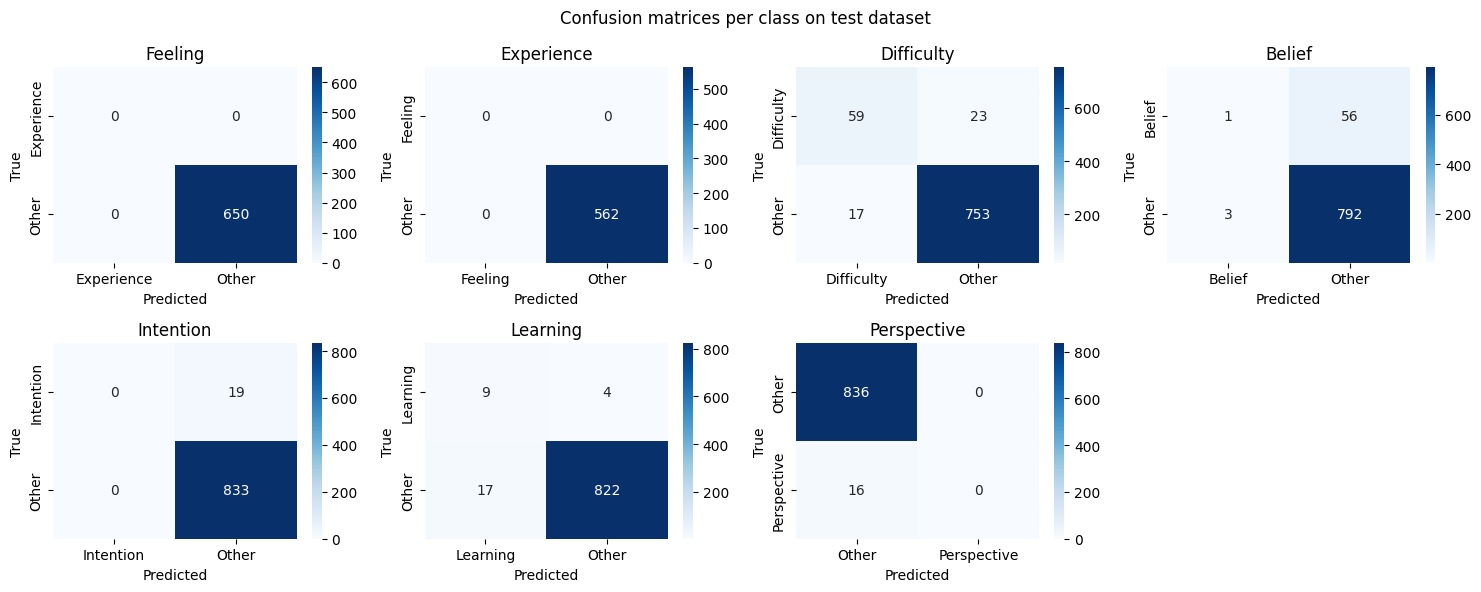

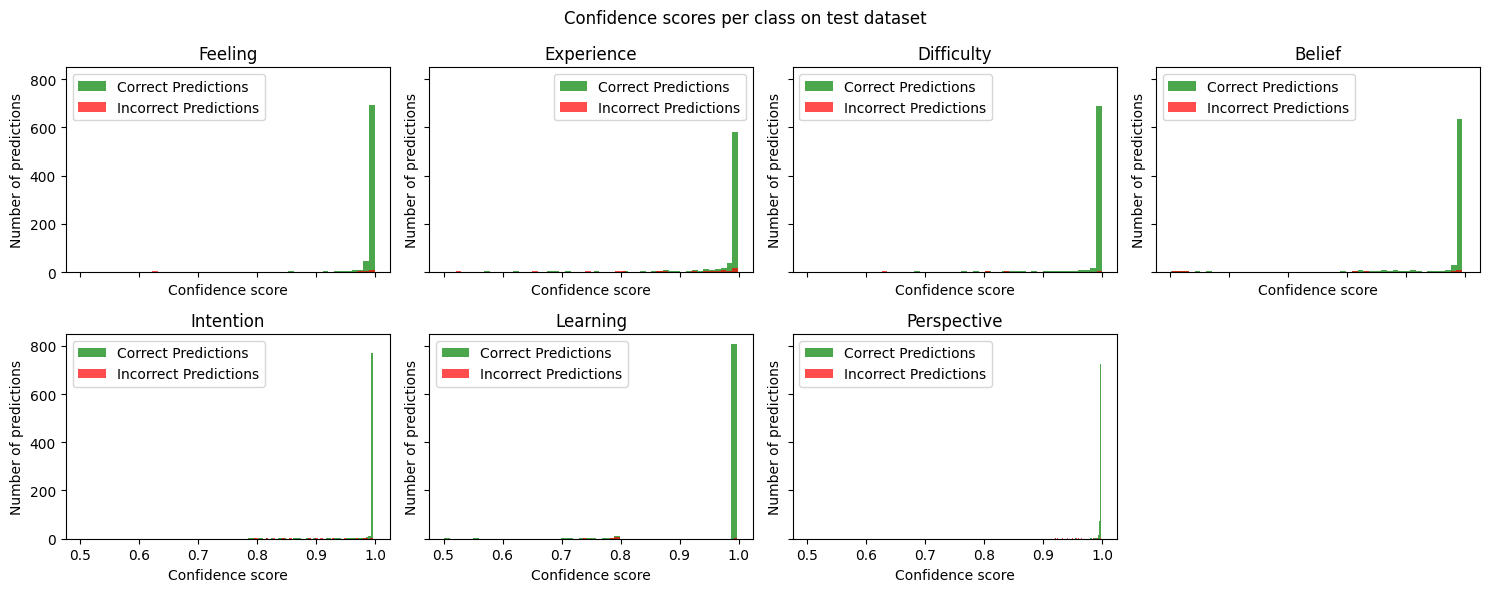

In [31]:
#print(f"\nOverall accuracy of multiple binary clf : {np.mean(accuracies_bin).round(4)}")
## Weighted average accuracy
#weights = [len(test_dataset_downsampled[test_dataset_downsampled['y'] == cat]) for cat in reflective_categories]
## Calculate the weighted average
#weighted_avg = np.round(sum(w * v for w, v in zip(weights, accuracies_bin)) / sum(weights),4)
#print(f"\nWeights : {weights}")
#print(f"Weigted accuracy of multiple binary clf : {weighted_avg}")

fig, axs = plt.subplots(2, 4, figsize=(15, 6)) 
print(reflective_categories)

for i, cat in enumerate(reflective_categories):
    ax = axs[i // 4, i % 4]
    # Create confusion matrix
    cm = confusion_matrix(true_labels_df[cat][0], predicted_labels_df[cat][0], labels=class_labels[i])
    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels[i], yticklabels=class_labels[i], ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"{cat}")
    
fig.delaxes(axs[1, 3])
plt.suptitle(f"Confusion matrices per class on test dataset")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 4, figsize=(15, 6), sharex = True, sharey = True) 

for i, cat in enumerate(reflective_categories):
    ax = axs[i // 4, i % 4]
    
    # Confidence Scores Histogram
    correct_confidence = [pred_confidence_df[cat][i] for i in range(len(pred_confidence_df[cat])) if predicted_labels_df[cat][0][i] == true_labels_df[cat][0][i] ] #and pred_confidence_df[cat][i] < 10]
    incorrect_confidence = [pred_confidence_df[cat][i] for i in range(len(pred_confidence_df[cat])) if predicted_labels_df[cat][0][i] != true_labels_df[cat][0][i] ] #and pred_confidence_df[cat][i] < 10]
    
    ax.hist(correct_confidence, bins=50, color='green', alpha=0.7, label='Correct Predictions')
    ax.hist(incorrect_confidence, bins=50, color='red', alpha=0.7, label='Incorrect Predictions')
    #ax.hist([correct_confidence, incorrect_confidence], bins=50, color=['green', 'red'], alpha=0.7, label=['Correct Predictions', 'Incorrect Predictions'])
    #ax.hist(pred_confidence_df[cat], bins=50)
    ax.legend()
    ax.set_xlabel('Confidence score')
    ax.set_ylabel('Number of predictions')
    ax.set_title(f"{cat}")

fig.delaxes(axs[1, 3])
plt.suptitle(f"Confidence scores per class on test dataset")
plt.tight_layout()
plt.show()

In [32]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score

# Initialize variables to store sum of metrics and count of classes
sum_accuracy = 0.0
sum_weighted_accuracy = 0.0
sum_f1 = 0.0
sum_auc = 0.0
count_classes = 0

# Iterate over each 'cat'
for cat in reflective_categories:
    predicted_labels = list(predicted_labels_df[cat].values)[0]
    true_labels = list(true_labels_df[cat].values)[0]
    
    # Encode labels
    label_encoder = LabelEncoder()
    true_labels_encoded = label_encoder.fit_transform(true_labels)
    predicted_labels_encoded = label_encoder.transform(predicted_labels)
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
    #f1 = f1_score(true_labels, predicted_labels, labels = [cat, 'Other'], pos_label = cat)
    f1_scores = f1_score(true_labels_encoded, predicted_labels_encoded, pos_label=label_encoder.transform([cat])[0])
    #auc = roc_auc_score(true_labels, predicted_labels) if len(set(true_labels)) > 1 else None  # AUC requires both classes
    auc = roc_auc_score(true_labels_encoded, predicted_labels_encoded) if len(set(true_labels_encoded)) > 1 else None
    
     # Sum metrics
    sum_accuracy += accuracy
    sum_weighted_accuracy += balanced_accuracy
    sum_f1 += f1_scores
    if auc is not None:
        sum_auc += auc
        
    # Increment count of classes
    count_classes += 1
    
    # Print metrics for the current class
    print(f"Overall accuracy for class '{cat}' = {accuracy:.4f}")
    print(f"Balanced accuracy for class '{cat}' = {balanced_accuracy:.4f}")
    print(f"F1 score for class '{cat}' = {f1_scores:.4f}")
    if auc is not None:
        print(f"AUC for class '{cat}' = {auc:.4f}")
    else:
        print(f"AUC for class '{cat}' cannot be computed due to insufficient data")
    print("--------------------------------------")

# Calculate averages
avg_accuracy = sum_accuracy / count_classes if count_classes > 0 else 0.0
avg_weighted_accuracy = sum_weighted_accuracy / count_classes if count_classes > 0 else 0.0
avg_f1 = sum_f1 / count_classes if count_classes > 0 else 0.0
avg_auc = sum_auc / count_classes if count_classes > 0 else None

# Print average metrics
print("#########################################")
print("############## AVERAGE ##################")
print("#########################################")
print(f"Average accuracy across classes = {avg_accuracy:.4f}")
print(f"Average balanced accuracy across classes = {avg_weighted_accuracy:.4f}")
print(f"Average F1 score across classes = {avg_f1:.4f}")
if avg_auc is not None:
    print(f"Average AUC across classes = {avg_auc:.4f}")
else:
    print("Average AUC across classes cannot be computed due to insufficient data")


Overall accuracy for class 'Feeling' = 0.9437
Balanced accuracy for class 'Feeling' = 0.9165
F1 score for class 'Feeling' = 0.8652
AUC for class 'Feeling' = 0.9165
--------------------------------------
Overall accuracy for class 'Experience' = 0.8932
Balanced accuracy for class 'Experience' = 0.8778
F1 score for class 'Experience' = 0.8139
AUC for class 'Experience' = 0.8778
--------------------------------------
Overall accuracy for class 'Difficulty' = 0.9531
Balanced accuracy for class 'Difficulty' = 0.8487
F1 score for class 'Difficulty' = 0.7468
AUC for class 'Difficulty' = 0.8487
--------------------------------------
Overall accuracy for class 'Belief' = 0.9308
Balanced accuracy for class 'Belief' = 0.5069
F1 score for class 'Belief' = 0.0328
AUC for class 'Belief' = 0.5069
--------------------------------------
Overall accuracy for class 'Intention' = 0.9777
Balanced accuracy for class 'Intention' = 0.5000
F1 score for class 'Intention' = 0.0000
AUC for class 'Intention' = 0.5

---

# Bonus: visualization after downsampling

In [141]:
# preprocess
sentences_en_tr = pd.read_csv('./../reflection-classification/data/sentences/en/train/sentences.tsv',sep='\t')
sentences_en_val = pd.read_csv('./../reflection-classification/data/sentences/en/val/sentences.tsv',sep='\t')
sentences_en_te = pd.read_csv('./../reflection-classification/data/sentences/en/test/sentences.tsv',sep='\t')
# Change Difficuties to Difficulty in 'y' column of test dataset
sentences_en_te['y'] = np.where(sentences_en_te['y'] == 'Difficulties', 'Difficulty', sentences_en_te['y'])

# Merge the DataFrames
merged_df = pd.concat([sentences_en_tr, sentences_en_val, sentences_en_te], ignore_index=True)

# Remove the 'Reflection' label
merged_df = merged_df[merged_df['y'] != 'Reflection']

# Shuffle the merged DataFrame
merged_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)

train_dataset, original_test_dataset = train_test_split(merged_df, test_size=0.15, random_state=42)

# Check lengths of sets
print("Train set length:", len(train_dataset))
print("Test set length:", len(original_test_dataset))

Train set length: 4822
Test set length: 852


Length of the original dataframe: 5674
Length of the downsampled dataframe with 600 cut: 2890
Length of the downsampled dataframe with 500 cut: 2590
Length of the downsampled dataframe with 400 cut: 2248


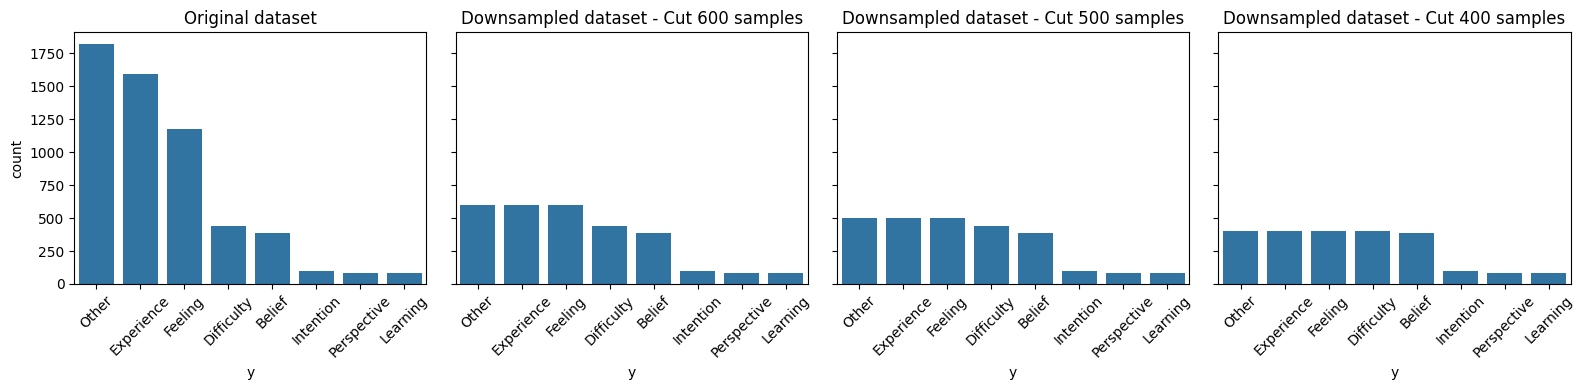

In [164]:
from imblearn.under_sampling import RandomUnderSampler

def downsample_dataset(df, max_values):
    label_counts = dict(df["y"].value_counts().sort_values(ascending=False))

    downsampled_label_counts = label_counts
    for key, value in label_counts.items():
        downsampled_label_counts[key] = value if value < max_values else max_values

    # Downsample to the maximum desired labels per class
    under_sampler = RandomUnderSampler(sampling_strategy= downsampled_label_counts)
    df_downsampled, _ = under_sampler.fit_resample(df, df['y'])

    # sample the dataset randomly
    df_downsampled = df_downsampled.sample(frac = 1)

    
    return df_downsampled

cut_downsampling_train = 600
cut_downsampling_test = 200
# Downsample the training dataset
dataset_downsampled_600 = downsample_dataset(merged_df, 600)
#dataset_downsampled_500 = downsample_dataset(merged_df, 500)
#dataset_downsampled_400 = downsample_dataset(merged_df, 400)
order_labels = merged_df['y'].value_counts().index.tolist()
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

sns.countplot(merged_df, x = 'y', order=order_labels, ax=axs[0])
axs[0].tick_params(axis = 'x', rotation = 45)
axs[0].set_title(f"Original dataset")
print(f"Length of the original dataframe: {len(merged_df)}")

# Downsample and plot for each maximum value
for i, max_value in enumerate([600, 500, 400]):
    dataset_downsampled = downsample_dataset(merged_df, max_value)
    print(f"Length of the downsampled dataframe with {max_value} cut: {len(dataset_downsampled)}")
    sns.countplot(data=dataset_downsampled, x='y', order=order_labels, ax=axs[i+1])
    axs[i+1].tick_params(axis = 'x', labelrotation=45)
    axs[i+1].set_title(f"Downsampled dataset - Cut {max_value} samples")

plt.tight_layout()
plt.show()